# Experiments

#### Imports:

In [1]:
import os
import sys
import math
import sklearn
import matplotlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import statsmodels.api as sm


from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import train_test_split

#### Constants:

In [2]:
CSV_PATH = "complete-frame.csv"
CSV_MINER_PATH = "testminereffectiveness.csv"

#### Aux functions:

In [3]:
def silent_evaluation(model, x_test, y_test):
    f = open('/dev/null', 'w')
    regular_stdout = sys.stdout
    sys.stdout = f
    test_loss, test_acc = model.evaluate(x_test, y_test)
    sys.stdout = regular_stdout
    print('Model Accuracy: {}'.format(test_acc))
    
    
def split_data(train_x, train_y, training=0.70, validation=0.5):
    train_size = training

    train_cnt = math.floor(train_x.shape[0] * train_size)
    x_train = train_x.iloc[0:train_cnt].values
    y_train = train_y.iloc[0:train_cnt].values
    x_test = train_x.iloc[train_cnt:]
    y_test = train_y.iloc[train_cnt:]

    division = validation

    train_cnt = math.floor(x_test.shape[0] * division)
    x_validate = x_test.iloc[0:train_cnt].values
    y_validate = y_test.iloc[0:train_cnt].values
    x_test = x_test.iloc[train_cnt:].values
    y_test = y_test.iloc[train_cnt:].values

    return x_train, y_train, x_test, y_test, x_validate, y_validate


def plot_graphs(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    #plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

#### Load data:

In [4]:
def label_rename (row):
    return row['path_test'].split('/')[len(row['path_test'].split('/')) - 1].split('.')[0]

def load_frame():
    frame1 = pd.read_csv(CSV_PATH, sep=",")
    frame1 = frame1.sample(frac=1).reset_index(drop=True)
    frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
    frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
    frame = pd.merge(frame1, frame2, on='TestClassName')
    frame = frame.drop(['project', 'module', 'path_test','test_name','path_src',
                        'class_name','TestClassName','commit','Nº','Project'], axis=1)
    frame = frame.sample(frac=1).reset_index(drop=True)
    frame = frame.dropna()

    return frame


def load_static_frame():
    frame1 = pd.read_csv(CSV_PATH, sep=",")
    frame1 = frame1.sample(frac=1).reset_index(drop=True)
    frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
    frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
    frame = pd.merge(frame1, frame2, on='TestClassName')
    frame = frame.drop(['project', 'module', 'path_test','test_name','path_src',
                        'class_name','TestClassName','commit','Nº','Project'], axis=1)
    frame = frame.sample(frac=1).reset_index(drop=True)
    frame = frame.dropna()

    return frame


def load_quartile(frame):
    low, high = frame.mutation.quantile([0.25,0.75])
    frame_low = frame.query('mutation<{low}'.format(low=low))
    frame_high = frame.query('mutation>{high}'.format(high=high))
    frame_low['mutation'] = 0
    frame_high['mutation'] = 1
    frame = pd.concat([frame_low, frame_high], ignore_index=True)
    frame = frame.sample(frac=1).reset_index(drop=True)
    return frame;

def load_meaningful_subset(frame):
    columns = [frame.no_mutations,
                         frame.line_coverage,
                         frame.csm_FE,
                         frame.CONNECTIVITY_prod,
                         frame.CONNECTIVITY_test,
                         frame.isEagerTest,
                         frame.LOC_prod, frame.LOC_test, frame.WMC_prod,
                         frame.LCOM1_prod, frame.LCOM2_prod,
                         frame.LCOM4_prod, frame.McCABE_prod,
                         frame.RFC_prod, frame.MPC_prod,
                         frame.RFC_test, frame.MPC_test,
                         frame.LCOM1_test, frame.LCOM2_test,
                         frame.LCOM4_test, frame.LCC_test,
                         frame.LCC_test, frame.WMC_test,
                         frame.McCABE_test, frame.NOP_prod]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)


def load_meaningful_subset_static(frame):
    columns = [frame.no_mutations,
                         frame.csm_FE,
                         frame.CONNECTIVITY_prod,
                         frame.CONNECTIVITY_test,
                         frame.isEagerTest,
                         frame.LOC_prod, frame.LOC_test, frame.WMC_prod,
                         frame.LCOM1_prod, frame.LCOM2_prod,
                         frame.LCOM4_prod, frame.McCABE_prod,
                         frame.RFC_prod, frame.MPC_prod,
                         frame.RFC_test, frame.MPC_test,
                         frame.LCOM1_test, frame.LCOM2_test,
                         frame.LCOM4_test, frame.LCC_test,
                         frame.LCC_test, frame.WMC_test,
                         frame.McCABE_test, frame.NOP_prod]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

def load_meaningful_subset_2(frame):
    #columns = [frame.line_coverage, frame.isAssertionRoulette, frame.isMysteryGuest,
    #   frame.isResourceOptimism, frame.isForTestersOnly, frame.COH_prod, frame.BUSWEIMER_prod,
    #   frame.BUSWEIMER_test, frame.csm_LM, frame.prod_readability]
    
    [frame.line_coverage,
    frame.COH_prod, frame.BUSWEIMER_prod, frame.csm_MC,
       frame.prod_readability, frame.prod_readability]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)




def load_all_data(frame):
    columns = [frame.no_mutations, frame.line_coverage, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability]
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)
    

def load_all_data_with_mine(frame):
    columns = [frame.no_mutations, frame.line_coverage, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability,frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)


def load_all_data_static(frame):
    columns = [frame.no_mutations, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability]
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)
    

def load_all_data_with_mine_static(frame):
    columns = [frame.no_mutations, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability,frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

def load_mine(frame):
    columns = [frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters, frame.mutation]
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

#### Data Manipulations:

In [6]:
def median(data_x, data_y, frame):
    labels = [1,2]
    bins = [0,frame.mutation.median(),1]
    frame['mutation_bins'] = pd.cut(frame.mutation, bins=bins, labels = labels, include_lowest=True)
    data_y = pd.concat([frame.mutation_bins], axis = 1)
    return split_data(data_x, data_y)

# Data Exploration

In [7]:
frame = load_frame()
frame.head()

mutation  no_mutations  line_coverage  isAssertionRoulette  isEagerTest  \
0  0.916667            12       0.900000                    1            1   
1  0.160000            25       0.235294                    0            0   
2  1.000000             3       1.000000                    0            0   
3  0.833333             6       1.000000                    1            0   
4  0.285714             7       1.000000                    1            0   

   isLazyTest  isMysteryGuest  isSensitiveEquality  isResourceOptimism  \
0           0               0                    1                   0   
1           0               0                    0                   0   
2           0               0                    0                   0   
3           0               0                    1                   0   
4           0               0                    0                   0   

   isForTestersOnly  ...  Mockito  BadApi    LOC  Expressions  Depth  \
0                 1  ...      0.0     4.0  144.0        406.0   11.0   
1                 0  ...      0.0     0.0  106.0        258.0   13.0   
2                 1  ...      0.0     0.0   10.0         21.0    8.0   
3                 0  ...      0.0     0.0  168.0        316.0   22.0   
4                 0  ...      0.0     0.0   23.0         34.0   16.0   

   Vocabulary  Understandability  BodySize  Dexterity  NonWhiteCharacters  
0        53.0             3470.0     483.0        3.0              2992.0  
1        55.0             2649.0     319.0        2.0              1956.0  
2         9.0              181.0      23.0        3.0               221.0  
3        50.0             5144.0     463.0        2.0              2377.0  
4        17.0              465.0      55.0        2.0               368.0  

[5 rows x 84 columns]

In [8]:
print(frame.shape)

(2243, 84)


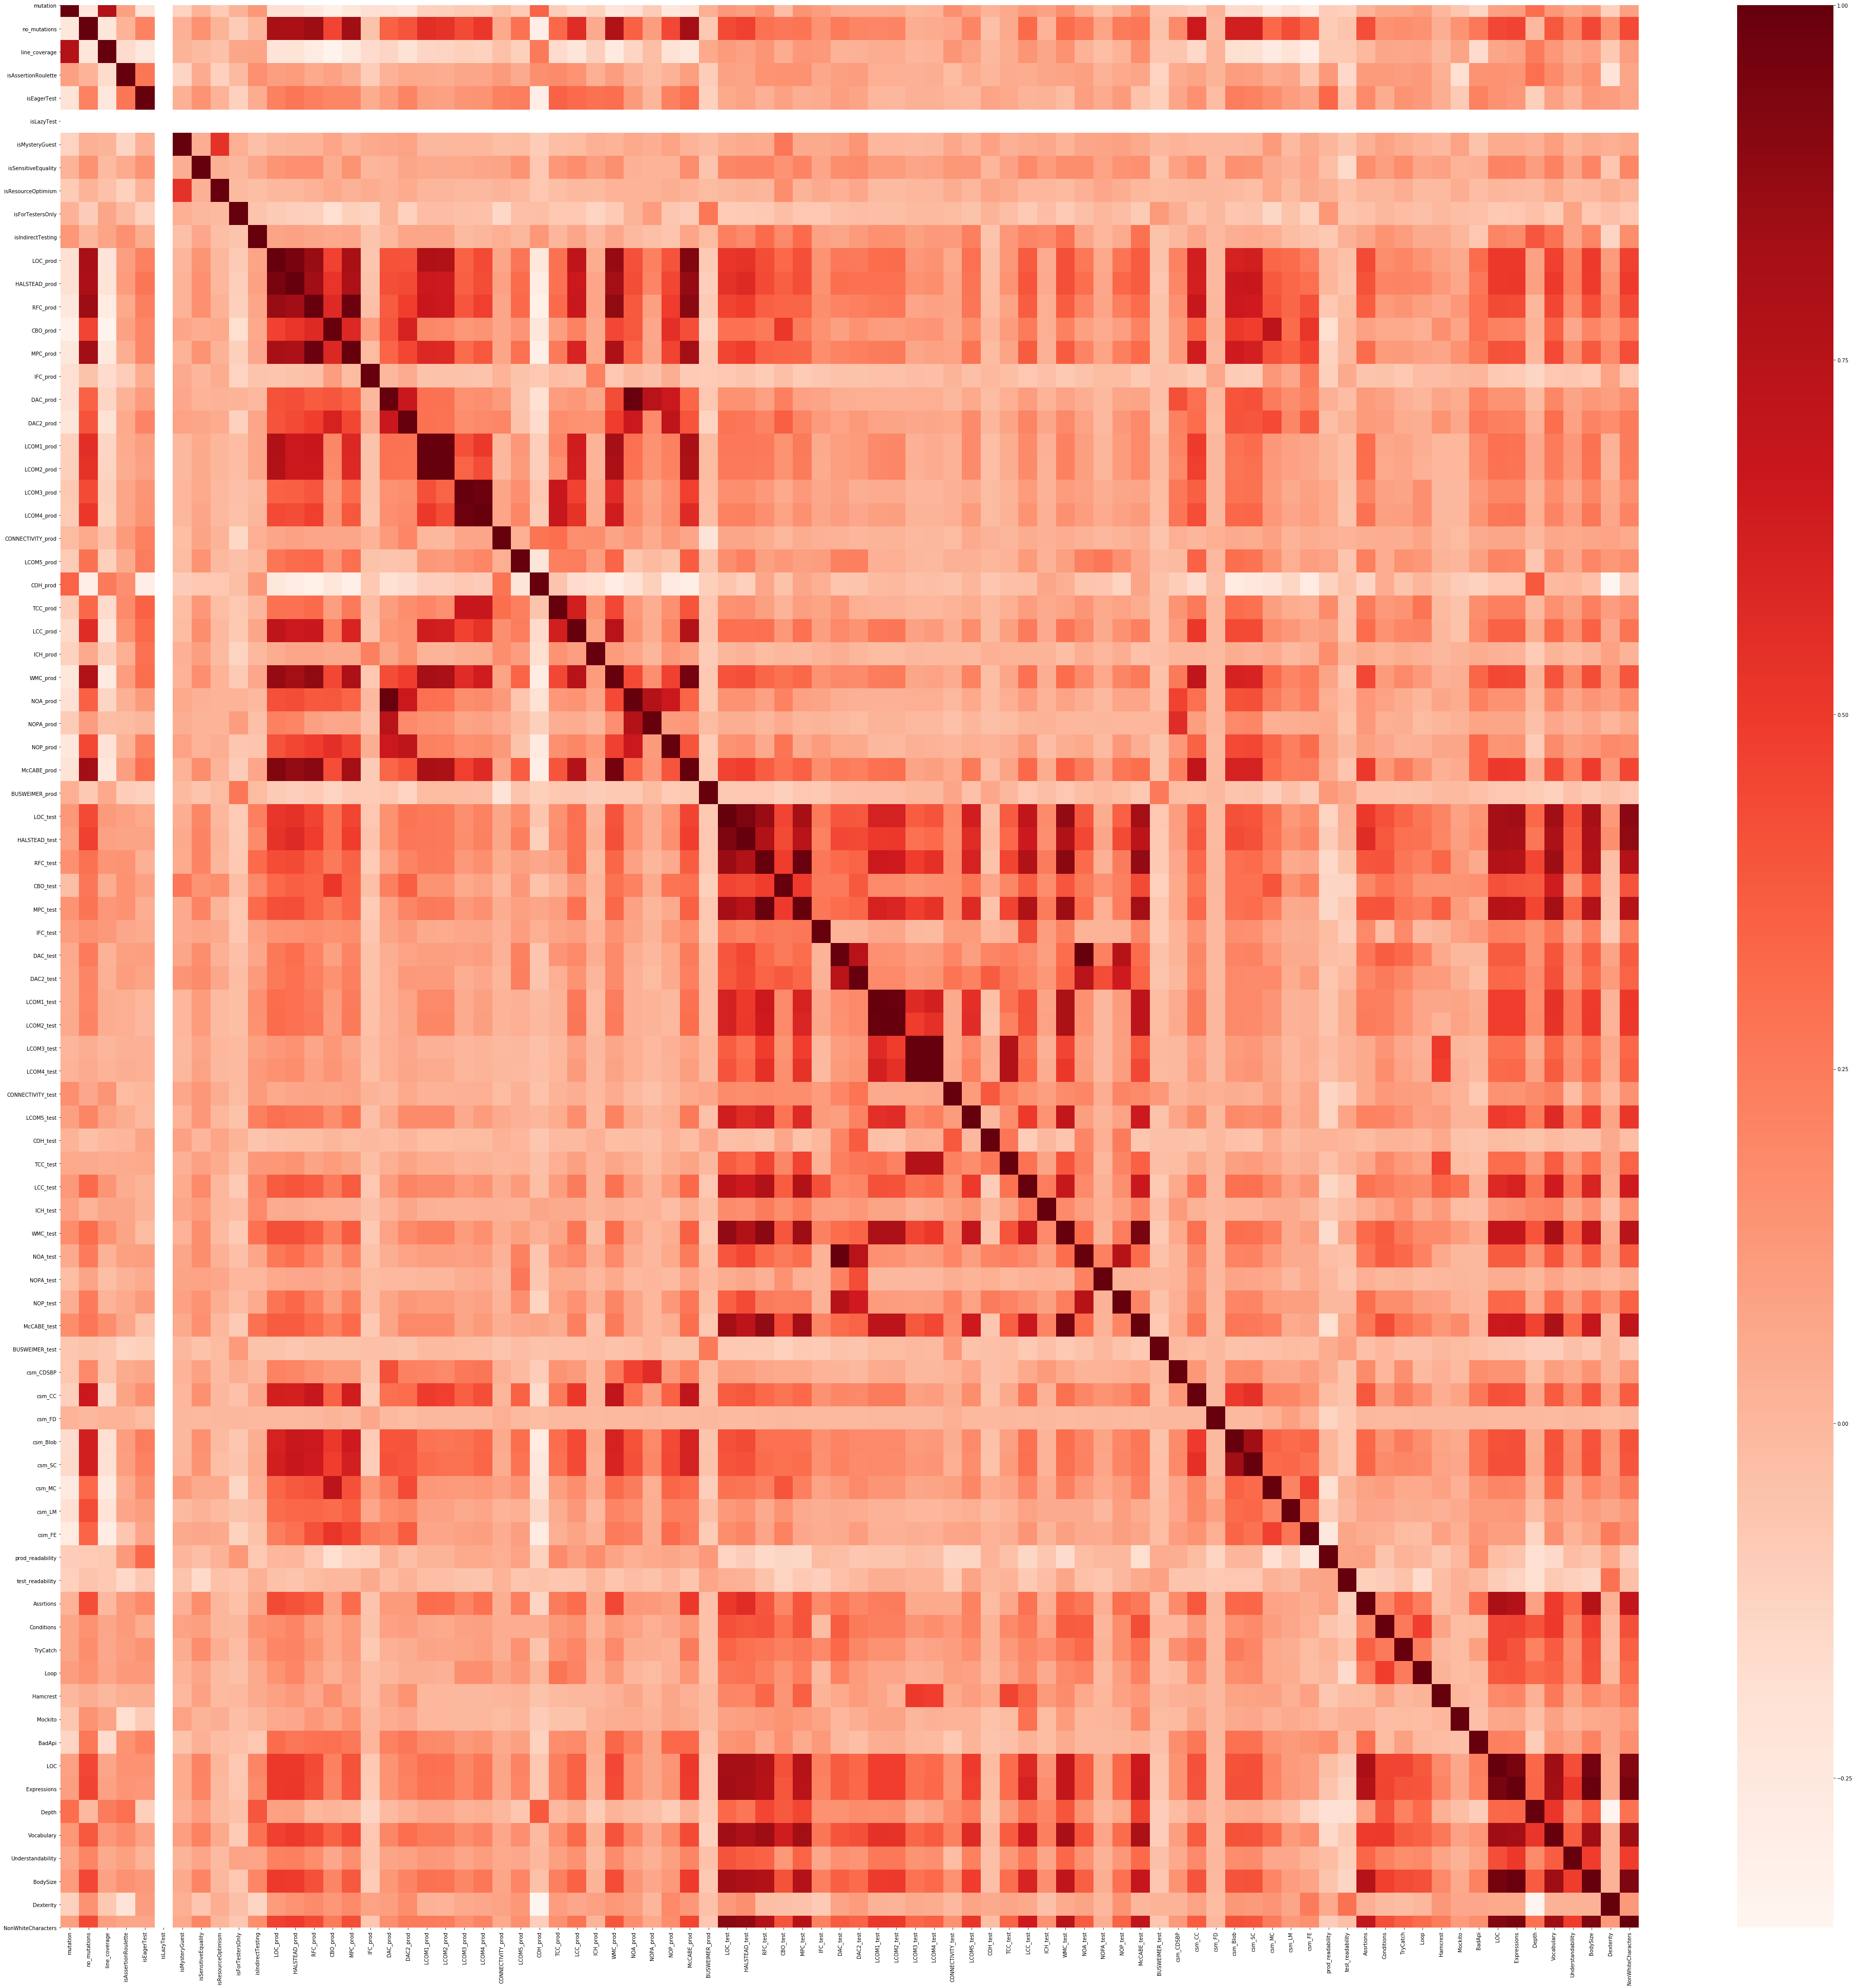

In [8]:
#Using Pearson Correlation
plt.figure(figsize=(69,69))
cor = frame.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

In [9]:
x = frame.drop(['mutation','line_coverage'], axis=1)
y = pd.concat([frame.mutation], axis = 1)

x = x.fillna(0)
y = column_or_1d(y, warn=False)

#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

cols = list(x.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 5)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(x,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Optimum number of features: 12
Score with 12 features: 0.206163
Index(['COH_prod', 'BUSWEIMER_prod', 'BUSWEIMER_test', 'csm_FD', 'csm_LM'], dtype='object')


## Experiment #1: Take all data and divide by the median - Dynamic

-------------------------- Data from the paper + mine ------------------------------------
(1570, 83)
Train on 1570 samples, validate on 337 samples
Epoch 1/2000
1570/1570 [==============================] - 2s 1ms/sample - loss: 284.3230 - accuracy: 0.5083 - val_loss: 61.8167 - val_accuracy: 0.6261
Epoch 2/2000
1570/1570 [==============================] - 0s 155us/sample - loss: 25.6049 - accuracy: 0.6395 - val_loss: 77.9957 - val_accuracy: 0.5579
Epoch 3/2000
1570/1570 [==============================] - 0s 186us/sample - loss: 28.8822 - accuracy: 0.6490 - val_loss: 18.6102 - val_accuracy: 0.6350
Epoch 4/2000
1570/1570 [==============================] - 0s 153us/sample - loss: 15.7411 - accuracy: 0.6745 - val_loss: 15.5070 - val_accuracy: 0.6706
Epoch 5/2000
1570/1570 [==============================] - 0s 145us/sample - loss: 36.6679 - accuracy: 0.6497 - val_loss: 61.3987 - val_accuracy: 0.5964
Epoch 6/2000
1570/1570 [==============================] - 0s 163us/sample - loss: 33.1644 - 

1570/1570 [==============================] - 0s 195us/sample - loss: 0.6634 - accuracy: 0.7618 - val_loss: 5.3508 - val_accuracy: 0.6409
Epoch 109/2000
1570/1570 [==============================] - 0s 177us/sample - loss: 0.7085 - accuracy: 0.7420 - val_loss: 5.2007 - val_accuracy: 0.7033
Epoch 110/2000
1570/1570 [==============================] - 0s 168us/sample - loss: 0.8471 - accuracy: 0.7497 - val_loss: 9.3862 - val_accuracy: 0.7418
Epoch 111/2000
1570/1570 [==============================] - 0s 167us/sample - loss: 1.1235 - accuracy: 0.7873 - val_loss: 7.8108 - val_accuracy: 0.7300
Epoch 112/2000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.8374 - accuracy: 0.7510 - val_loss: 9.3856 - val_accuracy: 0.7211
Epoch 113/2000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.6668 - accuracy: 0.7503 - val_loss: 7.5779 - val_accuracy: 0.6855
Epoch 114/2000
1570/1570 [==============================] - 0s 178us/sample - loss: 0.5333 - accuracy: 

Epoch 162/2000
1570/1570 [==============================] - 0s 179us/sample - loss: 0.8468 - accuracy: 0.7535 - val_loss: 1.7610 - val_accuracy: 0.6884
Epoch 163/2000
1570/1570 [==============================] - 0s 182us/sample - loss: 0.7291 - accuracy: 0.7223 - val_loss: 1.9501 - val_accuracy: 0.6053
Epoch 164/2000
1570/1570 [==============================] - 0s 210us/sample - loss: 0.7876 - accuracy: 0.7427 - val_loss: 1.5590 - val_accuracy: 0.7062
Epoch 165/2000
1570/1570 [==============================] - 0s 204us/sample - loss: 0.5579 - accuracy: 0.7561 - val_loss: 1.9803 - val_accuracy: 0.7300
Epoch 166/2000
1570/1570 [==============================] - 0s 190us/sample - loss: 0.5193 - accuracy: 0.7611 - val_loss: 1.6712 - val_accuracy: 0.7300
Epoch 167/2000
1570/1570 [==============================] - 0s 184us/sample - loss: 0.5878 - accuracy: 0.7427 - val_loss: 2.0277 - val_accuracy: 0.7003
Epoch 168/2000
1570/1570 [==============================] - 0s 191us/sample - loss: 0.59

Epoch 216/2000
1570/1570 [==============================] - 0s 167us/sample - loss: 1.0936 - accuracy: 0.6847 - val_loss: 1.3506 - val_accuracy: 0.6973
Epoch 217/2000
1570/1570 [==============================] - 0s 175us/sample - loss: 0.7916 - accuracy: 0.7325 - val_loss: 1.1497 - val_accuracy: 0.7092
Epoch 218/2000
1570/1570 [==============================] - 0s 173us/sample - loss: 1.1244 - accuracy: 0.6930 - val_loss: 1.7179 - val_accuracy: 0.7122
Epoch 219/2000
1570/1570 [==============================] - 0s 193us/sample - loss: 0.7125 - accuracy: 0.7478 - val_loss: 1.5857 - val_accuracy: 0.7240
Epoch 220/2000
1570/1570 [==============================] - 0s 189us/sample - loss: 0.8631 - accuracy: 0.7172 - val_loss: 2.2075 - val_accuracy: 0.7092
Epoch 221/2000
1570/1570 [==============================] - 0s 179us/sample - loss: 0.6403 - accuracy: 0.7567 - val_loss: 1.4553 - val_accuracy: 0.7418
Epoch 222/2000
1570/1570 [==============================] - 0s 177us/sample - loss: 0.61

Epoch 270/2000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.4128 - accuracy: 0.8178 - val_loss: 0.8576 - val_accuracy: 0.7448
Epoch 271/2000
1570/1570 [==============================] - 0s 163us/sample - loss: 0.4678 - accuracy: 0.7975 - val_loss: 1.0325 - val_accuracy: 0.7300
Epoch 272/2000
1570/1570 [==============================] - 0s 165us/sample - loss: 0.4172 - accuracy: 0.8127 - val_loss: 0.7905 - val_accuracy: 0.7448
Epoch 273/2000
1570/1570 [==============================] - 0s 160us/sample - loss: 0.4106 - accuracy: 0.8178 - val_loss: 0.9057 - val_accuracy: 0.7626
Epoch 274/2000
1570/1570 [==============================] - 0s 168us/sample - loss: 0.4148 - accuracy: 0.8223 - val_loss: 0.8876 - val_accuracy: 0.7329
Epoch 275/2000
1570/1570 [==============================] - 0s 178us/sample - loss: 0.3973 - accuracy: 0.8293 - val_loss: 0.8665 - val_accuracy: 0.7507
Epoch 276/2000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.39

Epoch 324/2000
1570/1570 [==============================] - 0s 170us/sample - loss: 0.3928 - accuracy: 0.8191 - val_loss: 8.6765 - val_accuracy: 0.7774
Epoch 325/2000
1570/1570 [==============================] - 0s 177us/sample - loss: 0.4005 - accuracy: 0.8299 - val_loss: 11.9651 - val_accuracy: 0.7359
Epoch 326/2000
1570/1570 [==============================] - 0s 187us/sample - loss: 1.0203 - accuracy: 0.8191 - val_loss: 1.0880 - val_accuracy: 0.7567
Epoch 327/2000
1570/1570 [==============================] - 0s 176us/sample - loss: 0.7037 - accuracy: 0.7815 - val_loss: 0.8958 - val_accuracy: 0.7478
Epoch 328/2000
1570/1570 [==============================] - 0s 165us/sample - loss: 0.5655 - accuracy: 0.7930 - val_loss: 1.5266 - val_accuracy: 0.7359
Epoch 329/2000
1570/1570 [==============================] - 0s 163us/sample - loss: 1.3358 - accuracy: 0.7312 - val_loss: 1.7626 - val_accuracy: 0.7211
Epoch 330/2000
1570/1570 [==============================] - 0s 161us/sample - loss: 0.7

Epoch 378/2000
1570/1570 [==============================] - 0s 202us/sample - loss: 0.4333 - accuracy: 0.8057 - val_loss: 0.7791 - val_accuracy: 0.7507
Epoch 379/2000
1570/1570 [==============================] - 0s 211us/sample - loss: 0.3923 - accuracy: 0.8299 - val_loss: 0.8137 - val_accuracy: 0.7507
Epoch 380/2000
1570/1570 [==============================] - 0s 224us/sample - loss: 0.3942 - accuracy: 0.8191 - val_loss: 0.8199 - val_accuracy: 0.7507
Epoch 381/2000
1570/1570 [==============================] - 0s 202us/sample - loss: 0.3914 - accuracy: 0.8268 - val_loss: 0.8719 - val_accuracy: 0.7567
Epoch 382/2000
1570/1570 [==============================] - 0s 200us/sample - loss: 0.3899 - accuracy: 0.8172 - val_loss: 0.9188 - val_accuracy: 0.7567
Epoch 383/2000
1570/1570 [==============================] - 0s 198us/sample - loss: 0.3867 - accuracy: 0.8268 - val_loss: 0.9306 - val_accuracy: 0.7537
Epoch 384/2000
1570/1570 [==============================] - 0s 208us/sample - loss: 0.38

Epoch 432/2000
1570/1570 [==============================] - 0s 218us/sample - loss: 0.3529 - accuracy: 0.8433 - val_loss: 0.8239 - val_accuracy: 0.7418
Epoch 433/2000
1570/1570 [==============================] - 0s 228us/sample - loss: 0.3523 - accuracy: 0.8516 - val_loss: 0.8820 - val_accuracy: 0.7181
Epoch 434/2000
1570/1570 [==============================] - 0s 239us/sample - loss: 0.3447 - accuracy: 0.8516 - val_loss: 0.8462 - val_accuracy: 0.7389
Epoch 435/2000
1570/1570 [==============================] - 0s 221us/sample - loss: 0.3413 - accuracy: 0.8561 - val_loss: 0.6867 - val_accuracy: 0.7478
Epoch 436/2000
1570/1570 [==============================] - 0s 213us/sample - loss: 0.5927 - accuracy: 0.6650 - val_loss: 0.9895 - val_accuracy: 0.7211
Epoch 437/2000
1570/1570 [==============================] - 0s 212us/sample - loss: 0.4743 - accuracy: 0.7586 - val_loss: 0.8971 - val_accuracy: 0.7685
Epoch 438/2000
1570/1570 [==============================] - 0s 228us/sample - loss: 0.38

Epoch 486/2000
1570/1570 [==============================] - 0s 196us/sample - loss: 0.5583 - accuracy: 0.8127 - val_loss: 2.6128 - val_accuracy: 0.7596
Epoch 487/2000
1570/1570 [==============================] - 0s 227us/sample - loss: 0.4841 - accuracy: 0.8083 - val_loss: 1.6609 - val_accuracy: 0.7685
Epoch 488/2000
1570/1570 [==============================] - 0s 205us/sample - loss: 0.4639 - accuracy: 0.8153 - val_loss: 2.1665 - val_accuracy: 0.7537
Epoch 489/2000
1570/1570 [==============================] - 0s 197us/sample - loss: 0.4276 - accuracy: 0.8261 - val_loss: 1.8523 - val_accuracy: 0.7745
Epoch 490/2000
1570/1570 [==============================] - 0s 196us/sample - loss: 0.4180 - accuracy: 0.8331 - val_loss: 1.8137 - val_accuracy: 0.7834
Epoch 491/2000
1570/1570 [==============================] - 0s 188us/sample - loss: 0.4038 - accuracy: 0.8401 - val_loss: 1.7463 - val_accuracy: 0.7685
Epoch 492/2000
1570/1570 [==============================] - 0s 202us/sample - loss: 0.37

Epoch 540/2000
1570/1570 [==============================] - 0s 192us/sample - loss: 0.3428 - accuracy: 0.8573 - val_loss: 1.4216 - val_accuracy: 0.7715
Epoch 541/2000
1570/1570 [==============================] - 0s 187us/sample - loss: 0.3371 - accuracy: 0.8605 - val_loss: 1.4495 - val_accuracy: 0.7715
Epoch 542/2000
1570/1570 [==============================] - 0s 175us/sample - loss: 0.3117 - accuracy: 0.8732 - val_loss: 1.8648 - val_accuracy: 0.7834
Epoch 543/2000
1570/1570 [==============================] - 0s 177us/sample - loss: 0.3191 - accuracy: 0.8701 - val_loss: 1.8491 - val_accuracy: 0.7507
Epoch 544/2000
1570/1570 [==============================] - 0s 180us/sample - loss: 0.3125 - accuracy: 0.8701 - val_loss: 1.5870 - val_accuracy: 0.7626
Epoch 545/2000
1570/1570 [==============================] - 0s 184us/sample - loss: 0.3142 - accuracy: 0.8701 - val_loss: 1.7834 - val_accuracy: 0.7329
Epoch 546/2000
1570/1570 [==============================] - 0s 189us/sample - loss: 0.32

Epoch 594/2000
1570/1570 [==============================] - 0s 197us/sample - loss: 0.3111 - accuracy: 0.8662 - val_loss: 16.7312 - val_accuracy: 0.7745
Epoch 595/2000
1570/1570 [==============================] - 0s 192us/sample - loss: 0.3108 - accuracy: 0.8713 - val_loss: 18.2141 - val_accuracy: 0.7774
Epoch 596/2000
1570/1570 [==============================] - 0s 174us/sample - loss: 0.3122 - accuracy: 0.8605 - val_loss: 17.0102 - val_accuracy: 0.7537
Epoch 597/2000
1570/1570 [==============================] - 0s 177us/sample - loss: 0.3321 - accuracy: 0.8541 - val_loss: 19.1577 - val_accuracy: 0.7804
Epoch 598/2000
1570/1570 [==============================] - 0s 181us/sample - loss: 0.3030 - accuracy: 0.8739 - val_loss: 18.8850 - val_accuracy: 0.7715
Epoch 599/2000
1570/1570 [==============================] - 0s 178us/sample - loss: 0.3483 - accuracy: 0.8631 - val_loss: 19.0790 - val_accuracy: 0.7893
Epoch 600/2000
1570/1570 [==============================] - 0s 191us/sample - loss

Epoch 701/2000
1570/1570 [==============================] - 0s 187us/sample - loss: 0.2850 - accuracy: 0.8809 - val_loss: 4.1584 - val_accuracy: 0.7478
Epoch 702/2000
1570/1570 [==============================] - 0s 185us/sample - loss: 0.3807 - accuracy: 0.8624 - val_loss: 0.9941 - val_accuracy: 0.7389
Epoch 703/2000
1570/1570 [==============================] - 0s 204us/sample - loss: 0.3418 - accuracy: 0.8554 - val_loss: 1.2210 - val_accuracy: 0.7596
Epoch 704/2000
1570/1570 [==============================] - 0s 208us/sample - loss: 0.3585 - accuracy: 0.8535 - val_loss: 1.1354 - val_accuracy: 0.7389
Epoch 705/2000
1570/1570 [==============================] - 0s 185us/sample - loss: 0.3246 - accuracy: 0.8586 - val_loss: 1.1113 - val_accuracy: 0.7418
Epoch 706/2000
1570/1570 [==============================] - 0s 181us/sample - loss: 0.3100 - accuracy: 0.8701 - val_loss: 1.7166 - val_accuracy: 0.7478
Epoch 707/2000
1570/1570 [==============================] - 0s 181us/sample - loss: 0.29

Epoch 755/2000
1570/1570 [==============================] - 0s 183us/sample - loss: 0.2450 - accuracy: 0.9019 - val_loss: 5.5588 - val_accuracy: 0.7507
Epoch 756/2000
1570/1570 [==============================] - 0s 189us/sample - loss: 0.2446 - accuracy: 0.8975 - val_loss: 6.2265 - val_accuracy: 0.7567
Epoch 757/2000
1570/1570 [==============================] - 0s 196us/sample - loss: 0.2343 - accuracy: 0.9019 - val_loss: 6.6091 - val_accuracy: 0.7329
Epoch 758/2000
1570/1570 [==============================] - 0s 199us/sample - loss: 0.2726 - accuracy: 0.8815 - val_loss: 6.3887 - val_accuracy: 0.7389
Epoch 759/2000
1570/1570 [==============================] - 0s 179us/sample - loss: 0.2459 - accuracy: 0.9000 - val_loss: 6.9673 - val_accuracy: 0.7478
Epoch 760/2000
1570/1570 [==============================] - 0s 181us/sample - loss: 0.2332 - accuracy: 0.8987 - val_loss: 7.6346 - val_accuracy: 0.7626
Epoch 761/2000
1570/1570 [==============================] - 0s 180us/sample - loss: 0.23

Epoch 809/2000
1570/1570 [==============================] - 0s 177us/sample - loss: 0.2428 - accuracy: 0.8975 - val_loss: 16.5207 - val_accuracy: 0.7745
Epoch 810/2000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.2373 - accuracy: 0.9089 - val_loss: 17.9575 - val_accuracy: 0.7656
Epoch 811/2000
1570/1570 [==============================] - 0s 182us/sample - loss: 0.2246 - accuracy: 0.9108 - val_loss: 18.9608 - val_accuracy: 0.7715
Epoch 812/2000
1570/1570 [==============================] - 0s 201us/sample - loss: 0.2186 - accuracy: 0.9057 - val_loss: 19.1087 - val_accuracy: 0.7537
Epoch 813/2000
1570/1570 [==============================] - 0s 174us/sample - loss: 0.2322 - accuracy: 0.9083 - val_loss: 20.0142 - val_accuracy: 0.7537
Epoch 814/2000
1570/1570 [==============================] - 0s 176us/sample - loss: 0.2200 - accuracy: 0.9096 - val_loss: 20.1491 - val_accuracy: 0.7418
Epoch 815/2000
1570/1570 [==============================] - 0s 176us/sample - loss

Epoch 916/2000
1570/1570 [==============================] - 0s 184us/sample - loss: 0.2525 - accuracy: 0.8924 - val_loss: 13.8642 - val_accuracy: 0.7537
Epoch 917/2000
1570/1570 [==============================] - 0s 176us/sample - loss: 0.2370 - accuracy: 0.9019 - val_loss: 15.1510 - val_accuracy: 0.7418
Epoch 918/2000
1570/1570 [==============================] - 0s 175us/sample - loss: 0.2286 - accuracy: 0.9051 - val_loss: 12.9412 - val_accuracy: 0.7507
Epoch 919/2000
1570/1570 [==============================] - 0s 177us/sample - loss: 0.3240 - accuracy: 0.8847 - val_loss: 8.2851 - val_accuracy: 0.7596
Epoch 920/2000
1570/1570 [==============================] - 0s 173us/sample - loss: 0.2877 - accuracy: 0.8955 - val_loss: 8.0965 - val_accuracy: 0.7685
Epoch 921/2000
1570/1570 [==============================] - 0s 188us/sample - loss: 0.3733 - accuracy: 0.8331 - val_loss: 7.5360 - val_accuracy: 0.7418
Epoch 922/2000
1570/1570 [==============================] - 0s 189us/sample - loss: 0

1570/1570 [==============================] - 0s 185us/sample - loss: 0.1969 - accuracy: 0.9197 - val_loss: 10.4755 - val_accuracy: 0.7596
Epoch 1023/2000
1570/1570 [==============================] - 0s 190us/sample - loss: 0.1875 - accuracy: 0.9255 - val_loss: 11.7451 - val_accuracy: 0.7359
Epoch 1024/2000
1570/1570 [==============================] - 0s 177us/sample - loss: 0.1797 - accuracy: 0.9287 - val_loss: 11.4403 - val_accuracy: 0.7448
Epoch 1025/2000
1570/1570 [==============================] - 0s 173us/sample - loss: 0.1843 - accuracy: 0.9261 - val_loss: 10.9753 - val_accuracy: 0.7270
Epoch 1026/2000
1570/1570 [==============================] - 0s 172us/sample - loss: 0.2093 - accuracy: 0.9146 - val_loss: 12.5909 - val_accuracy: 0.7389
Epoch 1027/2000
1570/1570 [==============================] - 0s 180us/sample - loss: 0.2213 - accuracy: 0.9083 - val_loss: 11.6676 - val_accuracy: 0.7507
Epoch 1028/2000
1570/1570 [==============================] - 0s 195us/sample - loss: 0.2730 

1570/1570 [==============================] - 0s 177us/sample - loss: 0.2133 - accuracy: 0.9140 - val_loss: 22.0036 - val_accuracy: 0.7537
Epoch 1129/2000
1570/1570 [==============================] - 0s 174us/sample - loss: 0.1958 - accuracy: 0.9268 - val_loss: 24.4430 - val_accuracy: 0.7507
Epoch 1130/2000
1570/1570 [==============================] - 0s 182us/sample - loss: 0.1738 - accuracy: 0.9395 - val_loss: 24.8728 - val_accuracy: 0.7478
Epoch 1131/2000
1570/1570 [==============================] - 0s 184us/sample - loss: 0.1640 - accuracy: 0.9363 - val_loss: 25.6822 - val_accuracy: 0.7478
Epoch 1132/2000
1570/1570 [==============================] - 0s 211us/sample - loss: 0.1520 - accuracy: 0.9459 - val_loss: 26.9706 - val_accuracy: 0.7300
Epoch 1133/2000
1570/1570 [==============================] - 0s 186us/sample - loss: 0.1543 - accuracy: 0.9395 - val_loss: 27.4490 - val_accuracy: 0.7418
Epoch 1134/2000
1570/1570 [==============================] - 0s 186us/sample - loss: 0.2116 

1570/1570 [==============================] - 0s 174us/sample - loss: 0.1486 - accuracy: 0.9459 - val_loss: 15.6204 - val_accuracy: 0.7240
Epoch 1235/2000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.1548 - accuracy: 0.9376 - val_loss: 13.4221 - val_accuracy: 0.7448
Epoch 1236/2000
1570/1570 [==============================] - 0s 158us/sample - loss: 0.1427 - accuracy: 0.9459 - val_loss: 15.2197 - val_accuracy: 0.7507
Epoch 1237/2000
1570/1570 [==============================] - 0s 160us/sample - loss: 0.1349 - accuracy: 0.9510 - val_loss: 16.5356 - val_accuracy: 0.7211
Epoch 1238/2000
1570/1570 [==============================] - 0s 164us/sample - loss: 0.1384 - accuracy: 0.9516 - val_loss: 16.1920 - val_accuracy: 0.7359
Epoch 1239/2000
1570/1570 [==============================] - 0s 167us/sample - loss: 0.1353 - accuracy: 0.9446 - val_loss: 15.7799 - val_accuracy: 0.7418
Epoch 1240/2000
1570/1570 [==============================] - 0s 178us/sample - loss: 0.1599 

1570/1570 [==============================] - 0s 176us/sample - loss: 0.1378 - accuracy: 0.9503 - val_loss: 25.0560 - val_accuracy: 0.7537
Epoch 1341/2000
1570/1570 [==============================] - 0s 180us/sample - loss: 0.1320 - accuracy: 0.9484 - val_loss: 25.8798 - val_accuracy: 0.7537
Epoch 1342/2000
1570/1570 [==============================] - 0s 164us/sample - loss: 0.1274 - accuracy: 0.9567 - val_loss: 28.5104 - val_accuracy: 0.7507
Epoch 1343/2000
1570/1570 [==============================] - 0s 163us/sample - loss: 0.1197 - accuracy: 0.9548 - val_loss: 30.3001 - val_accuracy: 0.7448
Epoch 1344/2000
1570/1570 [==============================] - 0s 168us/sample - loss: 0.1215 - accuracy: 0.9554 - val_loss: 33.3378 - val_accuracy: 0.7359
Epoch 1345/2000
1570/1570 [==============================] - 0s 168us/sample - loss: 0.1158 - accuracy: 0.9586 - val_loss: 34.3328 - val_accuracy: 0.7448
Epoch 1346/2000
1570/1570 [==============================] - 0s 186us/sample - loss: 0.1569 

1570/1570 [==============================] - 0s 163us/sample - loss: 0.1725 - accuracy: 0.9408 - val_loss: 9.6928 - val_accuracy: 0.7567
Epoch 1447/2000
1570/1570 [==============================] - 0s 162us/sample - loss: 0.1529 - accuracy: 0.9471 - val_loss: 10.6342 - val_accuracy: 0.7300
Epoch 1448/2000
1570/1570 [==============================] - 0s 179us/sample - loss: 0.1700 - accuracy: 0.9363 - val_loss: 10.5108 - val_accuracy: 0.7537
Epoch 1449/2000
1570/1570 [==============================] - 0s 174us/sample - loss: 0.1542 - accuracy: 0.9490 - val_loss: 11.0418 - val_accuracy: 0.7448
Epoch 1450/2000
1570/1570 [==============================] - 0s 164us/sample - loss: 0.1527 - accuracy: 0.9471 - val_loss: 11.9596 - val_accuracy: 0.7151
Epoch 1451/2000
1570/1570 [==============================] - 0s 163us/sample - loss: 0.1506 - accuracy: 0.9465 - val_loss: 12.0300 - val_accuracy: 0.7448
Epoch 1452/2000
1570/1570 [==============================] - 0s 163us/sample - loss: 0.1597 -

1570/1570 [==============================] - 0s 184us/sample - loss: 0.2663 - accuracy: 0.8879 - val_loss: 6.6797 - val_accuracy: 0.7567
Epoch 1553/2000
1570/1570 [==============================] - 0s 177us/sample - loss: 0.2531 - accuracy: 0.8924 - val_loss: 6.5368 - val_accuracy: 0.7567
Epoch 1554/2000
1570/1570 [==============================] - 0s 180us/sample - loss: 0.2541 - accuracy: 0.8885 - val_loss: 7.0992 - val_accuracy: 0.7478
Epoch 1555/2000
1570/1570 [==============================] - 0s 181us/sample - loss: 0.2354 - accuracy: 0.8936 - val_loss: 6.8834 - val_accuracy: 0.7448
Epoch 1556/2000
1570/1570 [==============================] - 0s 188us/sample - loss: 0.2293 - accuracy: 0.8930 - val_loss: 7.9682 - val_accuracy: 0.7537
Epoch 1557/2000
1570/1570 [==============================] - 0s 198us/sample - loss: 0.2244 - accuracy: 0.8981 - val_loss: 8.1046 - val_accuracy: 0.7567
Epoch 1558/2000
1570/1570 [==============================] - 0s 180us/sample - loss: 0.2146 - accu

1570/1570 [==============================] - 0s 167us/sample - loss: 0.1900 - accuracy: 0.9242 - val_loss: 7.3373 - val_accuracy: 0.7389
Epoch 1659/2000
1570/1570 [==============================] - 0s 180us/sample - loss: 0.1538 - accuracy: 0.9382 - val_loss: 9.6434 - val_accuracy: 0.7270
Epoch 1660/2000
1570/1570 [==============================] - 0s 170us/sample - loss: 0.1538 - accuracy: 0.9395 - val_loss: 9.7167 - val_accuracy: 0.7389
Epoch 1661/2000
1570/1570 [==============================] - 0s 162us/sample - loss: 0.1747 - accuracy: 0.9274 - val_loss: 9.5442 - val_accuracy: 0.7359
Epoch 1662/2000
1570/1570 [==============================] - 0s 162us/sample - loss: 0.1386 - accuracy: 0.9439 - val_loss: 10.8282 - val_accuracy: 0.7448
Epoch 1663/2000
1570/1570 [==============================] - 0s 163us/sample - loss: 0.1343 - accuracy: 0.9408 - val_loss: 11.1930 - val_accuracy: 0.7389
Epoch 1664/2000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.1238 - ac

1570/1570 [==============================] - 0s 182us/sample - loss: 0.1709 - accuracy: 0.9242 - val_loss: 9.9278 - val_accuracy: 0.7389
Epoch 1765/2000
1570/1570 [==============================] - 0s 176us/sample - loss: 0.1663 - accuracy: 0.9268 - val_loss: 9.3193 - val_accuracy: 0.7537
Epoch 1766/2000
1570/1570 [==============================] - 0s 163us/sample - loss: 0.1710 - accuracy: 0.9299 - val_loss: 12.1680 - val_accuracy: 0.7418
Epoch 1767/2000
1570/1570 [==============================] - 0s 163us/sample - loss: 0.1621 - accuracy: 0.9325 - val_loss: 11.4936 - val_accuracy: 0.7626
Epoch 1768/2000
1570/1570 [==============================] - 0s 161us/sample - loss: 0.1478 - accuracy: 0.9420 - val_loss: 11.7824 - val_accuracy: 0.7537
Epoch 1769/2000
1570/1570 [==============================] - 0s 166us/sample - loss: 0.1916 - accuracy: 0.9261 - val_loss: 10.5512 - val_accuracy: 0.7478
Epoch 1770/2000
1570/1570 [==============================] - 0s 178us/sample - loss: 0.1568 - 

1570/1570 [==============================] - 0s 175us/sample - loss: 0.1113 - accuracy: 0.9567 - val_loss: 18.7174 - val_accuracy: 0.7448
Epoch 1871/2000
1570/1570 [==============================] - 0s 162us/sample - loss: 0.1093 - accuracy: 0.9592 - val_loss: 20.2174 - val_accuracy: 0.7240
Epoch 1872/2000
1570/1570 [==============================] - 0s 163us/sample - loss: 0.0945 - accuracy: 0.9631 - val_loss: 21.0380 - val_accuracy: 0.7329
Epoch 1873/2000
1570/1570 [==============================] - 0s 163us/sample - loss: 0.1069 - accuracy: 0.9605 - val_loss: 17.3349 - val_accuracy: 0.7359
Epoch 1874/2000
1570/1570 [==============================] - 0s 170us/sample - loss: 0.1472 - accuracy: 0.9433 - val_loss: 16.1242 - val_accuracy: 0.7478
Epoch 1875/2000
1570/1570 [==============================] - 0s 181us/sample - loss: 0.1094 - accuracy: 0.9573 - val_loss: 15.9967 - val_accuracy: 0.7300
Epoch 1876/2000
1570/1570 [==============================] - 0s 167us/sample - loss: 0.0865 

1570/1570 [==============================] - 0s 188us/sample - loss: 0.1965 - accuracy: 0.9287 - val_loss: 15.1871 - val_accuracy: 0.7507
Epoch 1977/2000
1570/1570 [==============================] - 0s 181us/sample - loss: 0.1494 - accuracy: 0.9490 - val_loss: 16.3357 - val_accuracy: 0.7507
Epoch 1978/2000
1570/1570 [==============================] - 0s 176us/sample - loss: 0.1267 - accuracy: 0.9548 - val_loss: 20.3154 - val_accuracy: 0.7300
Epoch 1979/2000
1570/1570 [==============================] - 0s 189us/sample - loss: 0.1160 - accuracy: 0.9605 - val_loss: 19.2770 - val_accuracy: 0.7448
Epoch 1980/2000
1570/1570 [==============================] - 0s 208us/sample - loss: 0.1185 - accuracy: 0.9567 - val_loss: 19.3452 - val_accuracy: 0.7448
Epoch 1981/2000
1570/1570 [==============================] - 0s 195us/sample - loss: 0.2314 - accuracy: 0.9191 - val_loss: 11.6570 - val_accuracy: 0.7478
Epoch 1982/2000
1570/1570 [==============================] - 0s 187us/sample - loss: 0.1782 

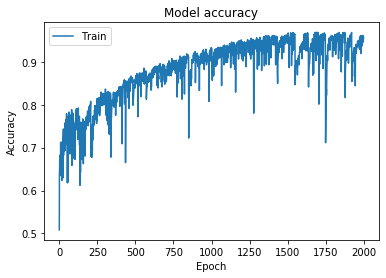

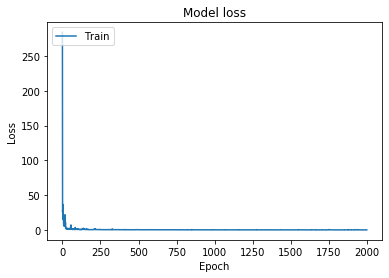

Overfit checks:
Model Accuracy: 0.9656050801277161


In [217]:
"""
print("-------------------------- Data from the paper ------------------------------------")
frame = load_frame()
data_x, data_y, number_of_features = load_all_data(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = median(data_x, data_y, frame)

print(x_train.shape)

model = keras.Sequential()

model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=40,restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, verbose=0,
          validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])

silent_evaluation(model, x_test, y_test)
plot_graphs(history)
print("Overfit checks:")
silent_evaluation(model, x_train, y_train)


######################################################################################

"""


print("-------------------------- Data from the paper + mine ------------------------------------")

frame = load_frame()
data_x, data_y, number_of_features = load_all_data_with_mine(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = median(data_x, data_y, frame)

print(x_train.shape)

model = keras.Sequential()

model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(40, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=40,restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=2000, verbose=1,
          validation_data=(x_test, y_test))#, callbacks=[early_stopping_monitor])

silent_evaluation(model, x_test, y_test)
plot_graphs(history)
print("Overfit checks:")
silent_evaluation(model, x_train, y_train)

-------------------------- Data from the paper + mine ------------------------------------
(1570, 83)
Model Accuracy: 0.7982195615768433


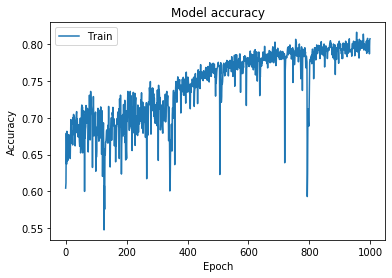

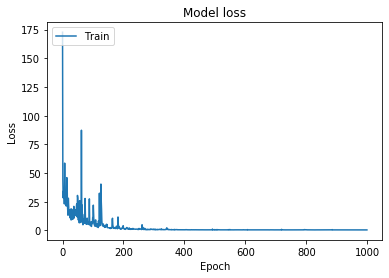

Overfit checks:
Model Accuracy: 0.8203821778297424


In [216]:
print("-------------------------- Data from the paper + mine ------------------------------------")

frame = load_frame()
data_x, data_y, number_of_features = load_all_data_with_mine(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = median(data_x, data_y, frame)

print(x_train.shape)

model = keras.Sequential()

model.add(keras.layers.Dropout(0.05, input_shape=(number_of_features,)))
model.add(keras.layers.Dense(40, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=40,restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=2000, verbose=1,
          validation_data=(x_validate, y_validate))#, callbacks=[early_stopping_monitor])

silent_evaluation(model, x_test, y_test)
plot_graphs(history)
print("Overfit checks:")
silent_evaluation(model, x_train, y_train)

## Experiment #2: Take half of the data - Dynamic


-------------------------- Data from the paper ------------------------------------
(782, 68)


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model Accuracy: 0.8392857313156128


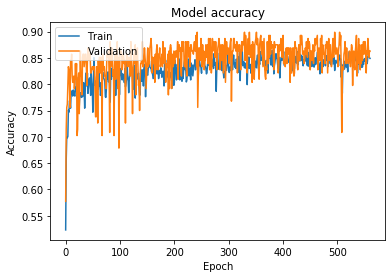

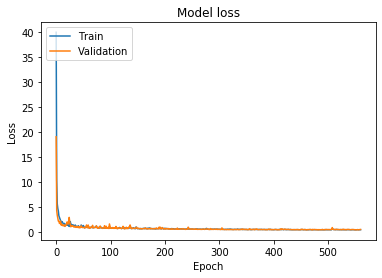

Overfit checks:
Model Accuracy: 0.8823529481887817
-------------------------- Data from the paper + mine ------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(782, 83)
Model Accuracy: 0.9345238208770752


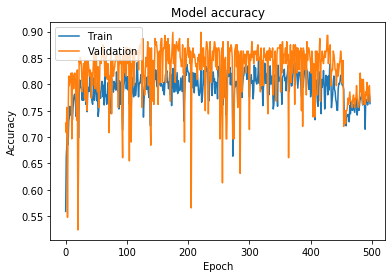

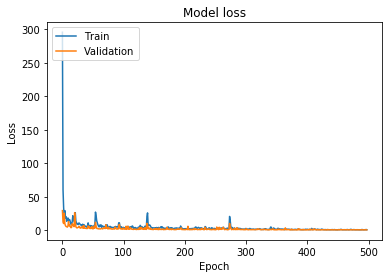

Overfit checks:
Model Accuracy: 0.877237856388092


In [28]:
print("-------------------------- Data from the paper ------------------------------------")
frame = load_frame()
frame = load_quartile(frame)
data_x, data_y, number_of_features = load_all_data(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data_y)


print(x_train.shape)

model = keras.Sequential()

model.add(keras.layers.Dropout(0.2, input_shape=(number_of_features,)))
model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=100,restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, verbose=0,
          validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])

silent_evaluation(model, x_test, y_test)
plot_graphs(history)
print("Overfit checks:")
silent_evaluation(model, x_train, y_train)


######################################################################################

print("-------------------------- Data from the paper + mine ------------------------------------")

frame = load_frame()
frame = load_quartile(frame)
data_x, data_y, number_of_features = load_all_data_with_mine(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data_y)


print(x_train.shape)

model = keras.Sequential()

model.add(keras.layers.Dropout(0.2, input_shape=(number_of_features,)))
model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=100,restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, verbose=0,
          validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])

silent_evaluation(model, x_test, y_test)
plot_graphs(history)
print("Overfit checks:")
silent_evaluation(model, x_train, y_train)

## Experiment #3: Take all data and divide by the median - Static

-------------------------- Data from the paper ------------------------------------
(1570, 67)
Model Accuracy: 0.7744807004928589


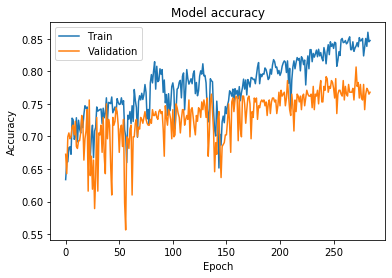

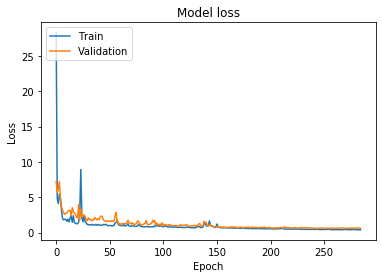

Overfit checks:
Model Accuracy: 0.8452229499816895
-------------------------- Data from the paper + mine ------------------------------------
(1570, 83)
Model Accuracy: 0.780415415763855


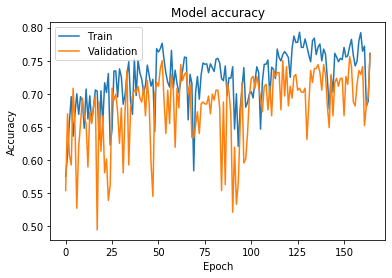

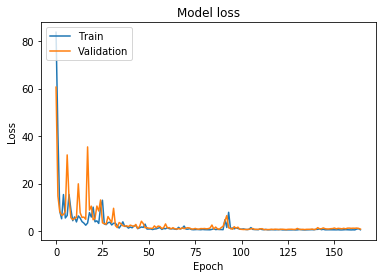

Overfit checks:
Model Accuracy: 0.7751592397689819


In [22]:
print("-------------------------- Data from the paper ------------------------------------")
frame = load_frame()
data_x, data_y, number_of_features = load_all_data_static(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = median(data_x, data_y, frame)

print(x_train.shape)

model = keras.Sequential()

model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=40,restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, verbose=0,
          validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])

silent_evaluation(model, x_test, y_test)
plot_graphs(history)
print("Overfit checks:")
silent_evaluation(model, x_train, y_train)


######################################################################################

print("-------------------------- Data from the paper + mine ------------------------------------")

frame = load_frame()
data_x, data_y, number_of_features = load_all_data_with_mine(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = median(data_x, data_y, frame)

print(x_train.shape)

model = keras.Sequential()

model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(40, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=40,restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, verbose=0,
          validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])

silent_evaluation(model, x_test, y_test)
plot_graphs(history)
print("Overfit checks:")
silent_evaluation(model, x_train, y_train)

## Experiment #4: Take half of the data - Static

In [70]:
from sklearn.model_selection import StratifiedKFold

print("-------------------------- Data from the paper ------------------------------------")

frame = load_frame()
frame = load_quartile(frame)
data_x, data_y, number_of_features = load_all_data_static(frame)

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []

data_x = data_x.values
data_y = data_y.values

for train, test in kfold.split(data_x, data_y):
    
    
    model = keras.Sequential()

    model.add(keras.layers.Dropout(0.2, input_shape=(number_of_features,)))
    model.add(keras.layers.Dense(40, activation='relu'))#, kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(20, activation='relu'))#, kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    #early_stopping_monitor = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
    
    early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=20,
                              verbose=0, mode='auto')
   
    history = model.fit(data_x[train], data_y[train], epochs=1000, verbose=0) #,
              #validation_data=(x_validate, y_validate)
                        #, callbacks=[early_stopping_monitor])
   
    #history = model.fit(data_x[train], data_y[train], epochs=400, verbose=0) #,
              #validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])

    #silent_evaluation(model, x_test, y_test)
    #plot_graphs(history)
    #print("Overfit checks:")
    #silent_evaluation(model, x_train, y_train)
    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("Overfit: %.2f%%" % (overfit[1]*100))
    print("-------------------------------------------")


    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


######################################################################################

print("-------------------------- Data from the paper + mine ------------------------------------")


frame = load_frame()
frame = load_quartile(frame)
data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []

data_x = data_x.values
data_y = data_y.values

for train, test in kfold.split(data_x, data_y):
    
    
    model = keras.Sequential()

    model.add(keras.layers.Dropout(0.2, input_shape=(number_of_features,)))
    model.add(keras.layers.Dense(40, activation='relu'))#, kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(20, activation='relu'))#, kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    #early_stopping_monitor = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
    
    
    early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='loss',
                                                           min_delta=0,
                                                           patience=20,
                                                           verbose=0, mode='auto')
   
    history = model.fit(data_x[train], data_y[train], epochs=1000, verbose=0) #,
              #validation_data=(x_validate, y_validate)
                       # , callbacks=[early_stopping_monitor])

    #silent_evaluation(model, x_test, y_test)
    #plot_graphs(history)
    #print("Overfit checks:")
    #silent_evaluation(model, x_train, y_train)
    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("Overfit: %.2f%%" % (overfit[1]*100))
    print("-------------------------------------------")

    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


-------------------------- Data from the paper ------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


accuracy: 83.93%
Overfit: 92.15%
-------------------------------------------
accuracy: 91.07%
Overfit: 93.74%
-------------------------------------------
accuracy: 85.71%
Overfit: 92.35%
-------------------------------------------
accuracy: 86.61%
Overfit: 91.95%
-------------------------------------------
accuracy: 85.71%
Overfit: 89.56%
-------------------------------------------
accuracy: 90.18%
Overfit: 94.14%
-------------------------------------------
accuracy: 87.50%
Overfit: 94.23%
-------------------------------------------
accuracy: 86.61%
Overfit: 94.33%
-------------------------------------------
accuracy: 83.78%
Overfit: 95.13%
-------------------------------------------
accuracy: 94.59%
Overfit: 92.85%
-------------------------------------------
87.57% (+/- 3.24%)
-------------------------- Data from the paper + mine ------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


accuracy: 87.50%
Overfit: 93.34%
-------------------------------------------
accuracy: 83.04%
Overfit: 92.05%
-------------------------------------------
accuracy: 86.61%
Overfit: 92.84%
-------------------------------------------
accuracy: 88.39%
Overfit: 88.87%
-------------------------------------------
accuracy: 91.96%
Overfit: 92.84%
-------------------------------------------
accuracy: 94.64%
Overfit: 91.55%
-------------------------------------------
accuracy: 90.18%
Overfit: 91.55%
-------------------------------------------
accuracy: 90.18%
Overfit: 89.26%
-------------------------------------------
accuracy: 88.29%
Overfit: 94.44%
-------------------------------------------
accuracy: 94.59%
Overfit: 92.06%
-------------------------------------------
89.54% (+/- 3.41%)


'\nframe = load_frame()\nframe = load_quartile(frame)\ndata_x, data_y, number_of_features = load_all_data_with_mine_static(frame)\nx_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data_y)\n\n\nprint(x_train.shape)\n\nmodel = keras.Sequential()\n\nmodel.add(keras.layers.Dropout(0.2, input_shape=(number_of_features,)))\nmodel.add(keras.layers.Dense(40, activation=\'relu\', kernel_regularizer= keras.regularizers.l2(0.01)))\nmodel.add(keras.layers.Dense(20, activation=\'relu\', kernel_regularizer= keras.regularizers.l2(0.01)))\nmodel.add(keras.layers.Dense(3, activation=\'softmax\'))\n\nmodel.compile(optimizer=\'adam\',\n              loss=\'sparse_categorical_crossentropy\',\n              metrics=[\'accuracy\'])\n\n#early_stopping_monitor = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)\n\nhistory = model.fit(x_train, y_train, epochs=100, verbose=0)#,\n          #validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor]

In [138]:
from sklearn.model_selection import StratifiedKFold

print("-------------------------- Data from the paper ------------------------------------")

frame = load_frame()
frame = load_quartile(frame)
data_x, data_y, number_of_features = load_all_data(frame)

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []

data_x = data_x.values
data_y = data_y.values

for train, test in kfold.split(data_x, data_y):
    
    
    model = keras.Sequential()

    model.add(keras.layers.Dropout(0.3, input_shape=(number_of_features,)))
    model.add(keras.layers.Dense(40, activation='relu'))#, kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(20, activation='relu'))#, kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    #early_stopping_monitor = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
    
    early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=20,
                              verbose=0, mode='auto')
   
    history = model.fit(data_x[train], data_y[train], epochs=1000, verbose=0) #,
              #validation_data=(x_validate, y_validate)
                        #, callbacks=[early_stopping_monitor])
   
    #history = model.fit(data_x[train], data_y[train], epochs=400, verbose=0) #,
              #validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])

    #silent_evaluation(model, x_test, y_test)
    #plot_graphs(history)
    #print("Overfit checks:")
    #silent_evaluation(model, x_train, y_train)
    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("Overfit: %.2f%%" % (overfit[1]*100))
    print("-------------------------------------------")


    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


######################################################################################

print("-------------------------- Data from the paper + mine ------------------------------------")


frame = load_frame()
frame = load_quartile(frame)
data_x, data_y, number_of_features = load_all_data_with_mine(frame)

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []

data_x = data_x.values
data_y = data_y.values

for train, test in kfold.split(data_x, data_y):
    
    
    model = keras.Sequential()

    model.add(keras.layers.Dropout(0.3, input_shape=(number_of_features,)))
    model.add(keras.layers.Dense(40, activation='relu'))#, kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(20, activation='relu'))#, kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    #early_stopping_monitor = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
    
    
    early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='loss',
                                                           min_delta=0,
                                                           patience=20,
                                                           verbose=0, mode='auto')
   
    history = model.fit(data_x[train], data_y[train], epochs=1000, verbose=0) #,
              #validation_data=(x_validate, y_validate)
                       # , callbacks=[early_stopping_monitor])

    #silent_evaluation(model, x_test, y_test)
    #plot_graphs(history)
    #print("Overfit checks:")
    #silent_evaluation(model, x_train, y_train)
    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("Overfit: %.2f%%" % (overfit[1]*100))
    print("-------------------------------------------")

    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


-------------------------- Data from the paper ------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


accuracy: 86.61%
Overfit: 91.25%
-------------------------------------------
accuracy: 86.61%
Overfit: 90.26%
-------------------------------------------
accuracy: 82.14%
Overfit: 92.54%
-------------------------------------------


KeyboardInterrupt: 

## Experiment #5: Predicting Mutation Score
   Try to predict the mutation score itself

(1570, 82)
Train on 1570 samples, validate on 336 samples
Epoch 1/1000
1570/1570 [==============================] - 1s 734us/sample - loss: 113182.8795 - mae: 106.0400 - val_loss: 139054.0076 - val_mae: 153.7570
Epoch 2/1000
1570/1570 [==============================] - 0s 139us/sample - loss: 113736.5660 - mae: 83.2776 - val_loss: 52778.3592 - val_mae: 78.8578
Epoch 3/1000
1570/1570 [==============================] - 0s 142us/sample - loss: 174392.0985 - mae: 107.4330 - val_loss: 3250.6254 - val_mae: 27.2419
Epoch 4/1000
1570/1570 [==============================] - 0s 149us/sample - loss: 7450.4787 - mae: 23.5551 - val_loss: 1853.9014 - val_mae: 15.7264
Epoch 5/1000
1570/1570 [==============================] - 0s 149us/sample - loss: 3544.1816 - mae: 16.4785 - val_loss: 913.2954 - val_mae: 11.5479
Epoch 6/1000
1570/1570 [==============================] - 0s 140us/sample - loss: 4650.2080 - mae: 18.3478 - val_loss: 4315.4333 - val_mae: 25.4449
Epoch 7/1000
1570/1570 [===================

Epoch 113/1000
1570/1570 [==============================] - 0s 164us/sample - loss: 3260.6287 - mae: 7.9197 - val_loss: 43.0516 - val_mae: 2.4566
Epoch 114/1000
1570/1570 [==============================] - 0s 180us/sample - loss: 1005.8430 - mae: 5.1977 - val_loss: 469.5725 - val_mae: 5.1665
Epoch 115/1000
1570/1570 [==============================] - 0s 157us/sample - loss: 7654.0933 - mae: 10.2062 - val_loss: 211.5944 - val_mae: 4.4589
Epoch 116/1000
1570/1570 [==============================] - 0s 172us/sample - loss: 546.0067 - mae: 3.9360 - val_loss: 285.3604 - val_mae: 4.3094
Epoch 117/1000
1570/1570 [==============================] - 0s 202us/sample - loss: 270.0816 - mae: 3.8784 - val_loss: 87.6496 - val_mae: 2.5590
Epoch 118/1000
1570/1570 [==============================] - 0s 193us/sample - loss: 91.4600 - mae: 2.3059 - val_loss: 81.2252 - val_mae: 2.3175
Epoch 119/1000
1570/1570 [==============================] - 0s 206us/sample - loss: 21.9667 - mae: 1.7421 - val_loss: 68.883

1570/1570 [==============================] - 0s 160us/sample - loss: 0.6789 - mae: 0.3252 - val_loss: 1.0681 - val_mae: 0.3578
Epoch 171/1000
1570/1570 [==============================] - 0s 161us/sample - loss: 0.6697 - mae: 0.3240 - val_loss: 1.0232 - val_mae: 0.3377
Epoch 172/1000
1570/1570 [==============================] - 0s 178us/sample - loss: 0.6635 - mae: 0.3140 - val_loss: 0.9771 - val_mae: 0.3287
Epoch 173/1000
1570/1570 [==============================] - 0s 171us/sample - loss: 0.6576 - mae: 0.3088 - val_loss: 0.9562 - val_mae: 0.3248
Epoch 174/1000
1570/1570 [==============================] - 0s 173us/sample - loss: 0.6517 - mae: 0.2988 - val_loss: 0.9626 - val_mae: 0.3301
Epoch 175/1000
1570/1570 [==============================] - 0s 163us/sample - loss: 0.6511 - mae: 0.2982 - val_loss: 0.9257 - val_mae: 0.3241
Epoch 176/1000
1570/1570 [==============================] - 0s 165us/sample - loss: 0.6378 - mae: 0.2875 - val_loss: 0.8700 - val_mae: 0.3013
Epoch 177/1000
1570/1

Epoch 228/1000
1570/1570 [==============================] - 0s 183us/sample - loss: 0.5878 - mae: 0.2293 - val_loss: 0.5597 - val_mae: 0.2393
Epoch 229/1000
1570/1570 [==============================] - 0s 179us/sample - loss: 0.5718 - mae: 0.2267 - val_loss: 0.5870 - val_mae: 0.2656
Epoch 230/1000
1570/1570 [==============================] - 0s 169us/sample - loss: 2.1003 - mae: 0.3379 - val_loss: 0.5543 - val_mae: 0.2305
Epoch 231/1000
1570/1570 [==============================] - 0s 171us/sample - loss: 4.7005 - mae: 0.5619 - val_loss: 3.1539 - val_mae: 0.6791
Epoch 232/1000
1570/1570 [==============================] - 0s 183us/sample - loss: 7.0914 - mae: 0.4853 - val_loss: 0.6384 - val_mae: 0.2730
Epoch 233/1000
1570/1570 [==============================] - 0s 174us/sample - loss: 4.4459 - mae: 0.3724 - val_loss: 0.6216 - val_mae: 0.2813
Epoch 234/1000
1570/1570 [==============================] - 0s 162us/sample - loss: 2.0704 - mae: 0.3218 - val_loss: 3.5759 - val_mae: 0.6479
Epoch 

Epoch 286/1000
1570/1570 [==============================] - 0s 159us/sample - loss: 0.5303 - mae: 0.2239 - val_loss: 0.5360 - val_mae: 0.2354
Epoch 287/1000
1570/1570 [==============================] - 0s 164us/sample - loss: 0.5299 - mae: 0.2238 - val_loss: 0.5356 - val_mae: 0.2353
Epoch 288/1000
1570/1570 [==============================] - 0s 165us/sample - loss: 0.5294 - mae: 0.2240 - val_loss: 0.5351 - val_mae: 0.2355
Epoch 289/1000
1570/1570 [==============================] - 0s 193us/sample - loss: 0.5290 - mae: 0.2240 - val_loss: 0.5346 - val_mae: 0.2355
Epoch 290/1000
1570/1570 [==============================] - 0s 174us/sample - loss: 0.5285 - mae: 0.2244 - val_loss: 0.5341 - val_mae: 0.2356
Epoch 291/1000
1570/1570 [==============================] - 0s 155us/sample - loss: 0.5280 - mae: 0.2239 - val_loss: 0.5336 - val_mae: 0.2355
Epoch 292/1000
1570/1570 [==============================] - 0s 157us/sample - loss: 0.5275 - mae: 0.2240 - val_loss: 0.5332 - val_mae: 0.2354
Epoch 

Epoch 344/1000
1570/1570 [==============================] - 0s 156us/sample - loss: 0.4982 - mae: 0.2246 - val_loss: 0.5034 - val_mae: 0.2351
Epoch 345/1000
1570/1570 [==============================] - 0s 160us/sample - loss: 0.5003 - mae: 0.2263 - val_loss: 0.5028 - val_mae: 0.2349
Epoch 346/1000
1570/1570 [==============================] - 0s 175us/sample - loss: 0.5862 - mae: 0.2366 - val_loss: 0.5019 - val_mae: 0.2351
Epoch 347/1000
1570/1570 [==============================] - 0s 168us/sample - loss: 0.5069 - mae: 0.2277 - val_loss: 0.5012 - val_mae: 0.2353
Epoch 348/1000
1570/1570 [==============================] - 0s 173us/sample - loss: 0.4982 - mae: 0.2266 - val_loss: 0.5004 - val_mae: 0.2356
Epoch 349/1000
1570/1570 [==============================] - 0s 182us/sample - loss: 0.4953 - mae: 0.2261 - val_loss: 0.4997 - val_mae: 0.2355
Epoch 350/1000
1570/1570 [==============================] - 0s 158us/sample - loss: 0.4940 - mae: 0.2242 - val_loss: 0.4991 - val_mae: 0.2348
Epoch 

Epoch 402/1000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.4485 - mae: 0.2241 - val_loss: 0.4534 - val_mae: 0.2343
Epoch 403/1000
1570/1570 [==============================] - 0s 167us/sample - loss: 0.4474 - mae: 0.2233 - val_loss: 0.4525 - val_mae: 0.2339
Epoch 404/1000
1570/1570 [==============================] - 0s 154us/sample - loss: 0.4464 - mae: 0.2230 - val_loss: 0.4514 - val_mae: 0.2340
Epoch 405/1000
1570/1570 [==============================] - 0s 157us/sample - loss: 0.4452 - mae: 0.2230 - val_loss: 0.4502 - val_mae: 0.2342
Epoch 406/1000
1570/1570 [==============================] - 0s 154us/sample - loss: 0.4441 - mae: 0.2236 - val_loss: 0.4491 - val_mae: 0.2342
Epoch 407/1000
1570/1570 [==============================] - 0s 158us/sample - loss: 0.4429 - mae: 0.2231 - val_loss: 0.4479 - val_mae: 0.2343
Epoch 408/1000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.4418 - mae: 0.2236 - val_loss: 0.4468 - val_mae: 0.2343
Epoch 

Epoch 460/1000
1570/1570 [==============================] - 0s 164us/sample - loss: 0.3644 - mae: 0.2065 - val_loss: 0.3628 - val_mae: 0.2090
Epoch 461/1000
1570/1570 [==============================] - 0s 154us/sample - loss: 0.3541 - mae: 0.1964 - val_loss: 0.3557 - val_mae: 0.2051
Epoch 462/1000
1570/1570 [==============================] - 0s 156us/sample - loss: 0.3540 - mae: 0.1978 - val_loss: 0.3537 - val_mae: 0.2002
Epoch 463/1000
1570/1570 [==============================] - 0s 156us/sample - loss: 0.3501 - mae: 0.1926 - val_loss: 0.3543 - val_mae: 0.2042
Epoch 464/1000
1570/1570 [==============================] - 0s 156us/sample - loss: 0.3484 - mae: 0.1929 - val_loss: 0.3557 - val_mae: 0.2052
Epoch 465/1000
1570/1570 [==============================] - 0s 172us/sample - loss: 0.3469 - mae: 0.1930 - val_loss: 0.3518 - val_mae: 0.2065
Epoch 466/1000
1570/1570 [==============================] - 0s 167us/sample - loss: 0.3459 - mae: 0.1969 - val_loss: 0.3473 - val_mae: 0.2032
Epoch 

Epoch 518/1000
1570/1570 [==============================] - 0s 175us/sample - loss: 0.2729 - mae: 0.2227 - val_loss: 0.2738 - val_mae: 0.2298
Epoch 519/1000
1570/1570 [==============================] - 0s 159us/sample - loss: 0.2592 - mae: 0.2038 - val_loss: 0.2556 - val_mae: 0.2003
Epoch 520/1000
1570/1570 [==============================] - 0s 157us/sample - loss: 0.2471 - mae: 0.1798 - val_loss: 0.2528 - val_mae: 0.1900
Epoch 521/1000
1570/1570 [==============================] - 0s 155us/sample - loss: 0.2436 - mae: 0.1753 - val_loss: 0.2529 - val_mae: 0.1914
Epoch 522/1000
1570/1570 [==============================] - 0s 156us/sample - loss: 0.2449 - mae: 0.1790 - val_loss: 0.2678 - val_mae: 0.2140
Epoch 523/1000
1570/1570 [==============================] - 0s 173us/sample - loss: 0.3074 - mae: 0.2398 - val_loss: 0.2857 - val_mae: 0.2383
Epoch 524/1000
1570/1570 [==============================] - 0s 164us/sample - loss: 0.2836 - mae: 0.2287 - val_loss: 0.2699 - val_mae: 0.2340
Epoch 

Epoch 576/1000
1570/1570 [==============================] - 0s 168us/sample - loss: 0.1881 - mae: 0.2244 - val_loss: 0.1925 - val_mae: 0.2343
Epoch 577/1000
1570/1570 [==============================] - 0s 165us/sample - loss: 0.1868 - mae: 0.2244 - val_loss: 0.1912 - val_mae: 0.2343
Epoch 578/1000
1570/1570 [==============================] - 0s 157us/sample - loss: 0.1855 - mae: 0.2239 - val_loss: 0.1899 - val_mae: 0.2343
Epoch 579/1000
1570/1570 [==============================] - 0s 154us/sample - loss: 0.1842 - mae: 0.2242 - val_loss: 0.1884 - val_mae: 0.2347
Epoch 580/1000
1570/1570 [==============================] - 0s 148us/sample - loss: 0.1828 - mae: 0.2245 - val_loss: 0.1871 - val_mae: 0.2347
Epoch 581/1000
1570/1570 [==============================] - 0s 158us/sample - loss: 0.1816 - mae: 0.2242 - val_loss: 0.1858 - val_mae: 0.2347
Epoch 582/1000
1570/1570 [==============================] - 0s 166us/sample - loss: 0.1803 - mae: 0.2248 - val_loss: 0.1846 - val_mae: 0.2346
Epoch 

Epoch 634/1000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.1238 - mae: 0.2235 - val_loss: 0.1282 - val_mae: 0.2348
Epoch 635/1000
1570/1570 [==============================] - 0s 167us/sample - loss: 0.1228 - mae: 0.2238 - val_loss: 0.1274 - val_mae: 0.2345
Epoch 636/1000
1570/1570 [==============================] - 0s 162us/sample - loss: 0.1219 - mae: 0.2246 - val_loss: 0.1264 - val_mae: 0.2347
Epoch 637/1000
1570/1570 [==============================] - 0s 156us/sample - loss: 0.1210 - mae: 0.2243 - val_loss: 0.1256 - val_mae: 0.2344
Epoch 638/1000
1570/1570 [==============================] - 0s 154us/sample - loss: 0.1370 - mae: 0.2345 - val_loss: 0.1248 - val_mae: 0.2364
Epoch 639/1000
1570/1570 [==============================] - 0s 158us/sample - loss: 0.1195 - mae: 0.2249 - val_loss: 0.1242 - val_mae: 0.2343
Epoch 640/1000
1570/1570 [==============================] - 0s 173us/sample - loss: 0.1187 - mae: 0.2239 - val_loss: 0.1231 - val_mae: 0.2347
Epoch 

Epoch 692/1000
1570/1570 [==============================] - 0s 165us/sample - loss: 0.0899 - mae: 0.2260 - val_loss: 0.0934 - val_mae: 0.2343
Epoch 693/1000
1570/1570 [==============================] - 0s 163us/sample - loss: 0.0881 - mae: 0.2237 - val_loss: 0.0931 - val_mae: 0.2341
Epoch 694/1000
1570/1570 [==============================] - 0s 146us/sample - loss: 0.0878 - mae: 0.2241 - val_loss: 0.0925 - val_mae: 0.2347
Epoch 695/1000
1570/1570 [==============================] - 0s 147us/sample - loss: 0.0874 - mae: 0.2243 - val_loss: 0.0923 - val_mae: 0.2344
Epoch 696/1000
1570/1570 [==============================] - 0s 152us/sample - loss: 0.0870 - mae: 0.2246 - val_loss: 0.0918 - val_mae: 0.2346
Epoch 697/1000
1570/1570 [==============================] - 0s 163us/sample - loss: 0.0867 - mae: 0.2235 - val_loss: 0.0915 - val_mae: 0.2346
Epoch 698/1000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.0863 - mae: 0.2242 - val_loss: 0.0911 - val_mae: 0.2348
Epoch 

Epoch 750/1000
1570/1570 [==============================] - 0s 174us/sample - loss: 0.0771 - mae: 0.2242 - val_loss: 0.0819 - val_mae: 0.2350
Epoch 751/1000
1570/1570 [==============================] - 0s 164us/sample - loss: 0.0771 - mae: 0.2254 - val_loss: 0.0819 - val_mae: 0.2345
Epoch 752/1000
1570/1570 [==============================] - 0s 154us/sample - loss: 0.0771 - mae: 0.2243 - val_loss: 0.0818 - val_mae: 0.2347
Epoch 753/1000
1570/1570 [==============================] - 0s 156us/sample - loss: 0.0768 - mae: 0.2236 - val_loss: 0.0818 - val_mae: 0.2345
Epoch 754/1000
1570/1570 [==============================] - 0s 157us/sample - loss: 0.0768 - mae: 0.2244 - val_loss: 0.0817 - val_mae: 0.2345
Epoch 755/1000
1570/1570 [==============================] - 0s 162us/sample - loss: 0.0767 - mae: 0.2237 - val_loss: 0.0816 - val_mae: 0.2346
Epoch 756/1000
1570/1570 [==============================] - 0s 176us/sample - loss: 0.0766 - mae: 0.2238 - val_loss: 0.0815 - val_mae: 0.2348
Epoch 

Epoch 808/1000
1570/1570 [==============================] - 0s 171us/sample - loss: 0.0737 - mae: 0.2243 - val_loss: 0.0787 - val_mae: 0.2347
Epoch 809/1000
1570/1570 [==============================] - 0s 155us/sample - loss: 0.0737 - mae: 0.2251 - val_loss: 0.0788 - val_mae: 0.2343
Epoch 810/1000
1570/1570 [==============================] - 0s 154us/sample - loss: 0.0737 - mae: 0.2250 - val_loss: 0.0786 - val_mae: 0.2345
Epoch 811/1000
1570/1570 [==============================] - 0s 155us/sample - loss: 0.0736 - mae: 0.2239 - val_loss: 0.0785 - val_mae: 0.2351
Epoch 812/1000
1570/1570 [==============================] - 0s 156us/sample - loss: 0.0743 - mae: 0.2244 - val_loss: 0.0787 - val_mae: 0.2352
Epoch 813/1000
1570/1570 [==============================] - 0s 166us/sample - loss: 0.0740 - mae: 0.2258 - val_loss: 0.0790 - val_mae: 0.2343
Epoch 814/1000
1570/1570 [==============================] - 0s 160us/sample - loss: 0.0739 - mae: 0.2238 - val_loss: 0.0788 - val_mae: 0.2346
Epoch 

Epoch 866/1000
1570/1570 [==============================] - 0s 158us/sample - loss: 0.0728 - mae: 0.2251 - val_loss: 0.0774 - val_mae: 0.2353
Epoch 867/1000
1570/1570 [==============================] - 0s 156us/sample - loss: 0.0727 - mae: 0.2262 - val_loss: 0.0777 - val_mae: 0.2342
Epoch 868/1000
1570/1570 [==============================] - 0s 160us/sample - loss: 0.0726 - mae: 0.2235 - val_loss: 0.0776 - val_mae: 0.2345
Epoch 869/1000
1570/1570 [==============================] - 0s 172us/sample - loss: 0.0726 - mae: 0.2243 - val_loss: 0.0777 - val_mae: 0.2342
Epoch 870/1000
1570/1570 [==============================] - 0s 165us/sample - loss: 0.0727 - mae: 0.2238 - val_loss: 0.0775 - val_mae: 0.2348
Epoch 871/1000
1570/1570 [==============================] - 0s 157us/sample - loss: 0.0726 - mae: 0.2247 - val_loss: 0.0776 - val_mae: 0.2343
Epoch 872/1000
1570/1570 [==============================] - 0s 154us/sample - loss: 0.0726 - mae: 0.2237 - val_loss: 0.0774 - val_mae: 0.2353
Epoch 

Epoch 924/1000
1570/1570 [==============================] - 0s 153us/sample - loss: 0.0724 - mae: 0.2257 - val_loss: 0.0775 - val_mae: 0.2342
Epoch 925/1000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.0724 - mae: 0.2232 - val_loss: 0.0773 - val_mae: 0.2349
Epoch 926/1000
1570/1570 [==============================] - 0s 169us/sample - loss: 0.0725 - mae: 0.2256 - val_loss: 0.0773 - val_mae: 0.2347
Epoch 927/1000
1570/1570 [==============================] - 0s 155us/sample - loss: 0.0724 - mae: 0.2247 - val_loss: 0.0775 - val_mae: 0.2343
Epoch 928/1000
1570/1570 [==============================] - 0s 154us/sample - loss: 0.0725 - mae: 0.2248 - val_loss: 0.0773 - val_mae: 0.2347
Epoch 929/1000
1570/1570 [==============================] - 0s 156us/sample - loss: 0.0726 - mae: 0.2247 - val_loss: 0.0777 - val_mae: 0.2344
Epoch 930/1000
1570/1570 [==============================] - 0s 155us/sample - loss: 0.0728 - mae: 0.2257 - val_loss: 0.0778 - val_mae: 0.2343
Epoch 

Epoch 982/1000
1570/1570 [==============================] - 0s 155us/sample - loss: 0.0724 - mae: 0.2245 - val_loss: 0.0772 - val_mae: 0.2353
Epoch 983/1000
1570/1570 [==============================] - 0s 174us/sample - loss: 0.0726 - mae: 0.2250 - val_loss: 0.0774 - val_mae: 0.2344
Epoch 984/1000
1570/1570 [==============================] - 0s 164us/sample - loss: 0.0724 - mae: 0.2251 - val_loss: 0.0773 - val_mae: 0.2347
Epoch 985/1000
1570/1570 [==============================] - 0s 157us/sample - loss: 0.0724 - mae: 0.2245 - val_loss: 0.0773 - val_mae: 0.2348
Epoch 986/1000
1570/1570 [==============================] - 0s 161us/sample - loss: 0.0724 - mae: 0.2239 - val_loss: 0.0772 - val_mae: 0.2350
Epoch 987/1000
1570/1570 [==============================] - 0s 164us/sample - loss: 0.0726 - mae: 0.2258 - val_loss: 0.0773 - val_mae: 0.2348
Epoch 988/1000
1570/1570 [==============================] - 0s 162us/sample - loss: 0.0724 - mae: 0.2250 - val_loss: 0.0776 - val_mae: 0.2340
Epoch 

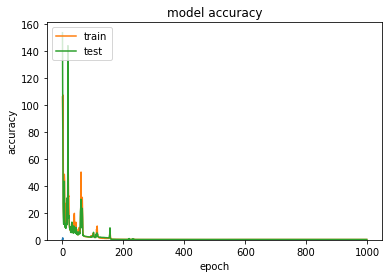

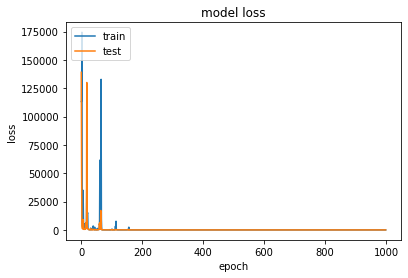

Model Accuracy: 0.22884522378444672
Overfit checks:
Model Accuracy: 0.2240038514137268


In [12]:
frame = load_frame()
data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(2) #.mul(10)

sns.distplot(data_y);


x_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data_y)

print(x_train.shape)
model = keras.Sequential()
model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

#early_stopping_monitor = keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True)


history = model.fit(x_train, y_train, epochs=1000, verbose=1, validation_data=(x_validate, y_validate))
#, callbacks=[early_stopping_monitor])


# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

silent_evaluation(model, x_test, y_test)


print("Overfit checks:")
silent_evaluation(model, x_train, y_train)

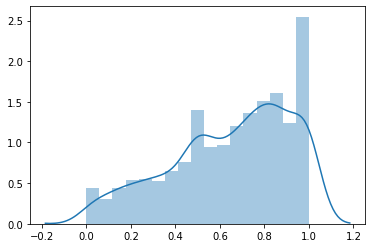

In [149]:
frame = load_frame()
data_x, data_y, number_of_features = load_all_data_with_mine(frame)
data_y = pd.concat([frame.mutation], axis = 1) #.round(2) #.mul(10)

sns.distplot(data_y);

In [99]:
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import FactorAnalyzer






kmo_all,kmo_model=calculate_kmo(data_x)
print(kmo_model)

fa = FactorAnalyzer(n_factors=6, rotation='varimax')
data_x = data_x.dropna()
fa.fit(data_x)


0.7476723982640964


/Users/Dor/anaconda3/lib/python3.6/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=6, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [200]:
import tensorflow

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

frame = load_frame()
frame = load_quartile(frame)

data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

data_x = data_x.values
data_y = data_y.values

dropout = 0.15
while dropout < 0.3:
    
    seed = 7
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cvscores = []
    overscores = []
    
    for train, validation_and_test in kfold.split(data_x, data_y):
        
        x_validation, x_test, y_validation, y_test = train_test_split(data_x[validation_and_test], data_y[validation_and_test], test_size=.5, random_state=seed)

        model = keras.Sequential()

        model.add(keras.layers.Dropout(dropout, input_shape=(number_of_features,)))
        model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
        model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
        model.add(keras.layers.Dense(2, activation='softmax'))

        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

        early_stopping_monitor = keras.callbacks.EarlyStopping(patience=40,restore_best_weights=True)

        history = model.fit(data_x[train], data_y[train], epochs=1000, verbose=0,
                            validation_data=(x_validation, y_validation), callbacks=[early_stopping_monitor])

        #plot_graphs(history)
     
        scores = model.evaluate(x_test, y_test, verbose=0)
        overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print("Overfit: %.2f%%" % (overfit[1]*100))
        #print("-------------------------------------------")

        cvscores.append(scores[1] * 100)
        overscores.append(overfit[1]*100)
    print("-------------------------------------------")
    print("The result, with a dropout of {} is:".format(dropout))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
    print("-------------------------------------------")
    dropout *= 1.01


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


accuracy: 83.93%
Overfit: 86.28%
accuracy: 80.36%
Overfit: 84.39%
accuracy: 82.14%
Overfit: 83.80%
accuracy: 78.57%
Overfit: 83.90%
accuracy: 82.14%
Overfit: 88.17%
accuracy: 89.29%
Overfit: 87.38%
accuracy: 87.50%
Overfit: 86.38%
accuracy: 89.29%
Overfit: 87.48%
accuracy: 85.71%
Overfit: 87.98%
accuracy: 94.64%
Overfit: 87.49%
-------------------------------------------
The result, with a dropout of 0.15 is:
85.36% (+/- 4.64%)
And overfit of 86.32% (+/- 1.61%)
-------------------------------------------
accuracy: 80.36%
Overfit: 86.78%
accuracy: 76.79%
Overfit: 79.03%
accuracy: 82.14%
Overfit: 88.57%
accuracy: 78.57%
Overfit: 88.47%
accuracy: 83.93%
Overfit: 87.57%
accuracy: 91.07%
Overfit: 88.97%
accuracy: 85.71%
Overfit: 85.98%
accuracy: 91.07%
Overfit: 87.77%
accuracy: 80.36%
Overfit: 85.80%
accuracy: 92.86%
Overfit: 88.58%
-------------------------------------------
The result, with a dropout of 0.1515 is:
84.29% (+/- 5.40%)
And overfit of 86.75% (+/- 2.78%)
----------------------

accuracy: 80.36%
Overfit: 86.28%
accuracy: 83.93%
Overfit: 81.41%
accuracy: 83.93%
Overfit: 88.57%
accuracy: 73.21%
Overfit: 85.49%
accuracy: 82.14%
Overfit: 87.57%
accuracy: 92.86%
Overfit: 87.38%
accuracy: 89.29%
Overfit: 82.01%
accuracy: 78.57%
Overfit: 82.50%
accuracy: 83.93%
Overfit: 85.80%
accuracy: 91.07%
Overfit: 84.21%
-------------------------------------------
The result, with a dropout of 0.17588679673855476 is:
83.93% (+/- 5.65%)
And overfit of 85.12% (+/- 2.37%)
-------------------------------------------
accuracy: 89.29%
Overfit: 86.78%
accuracy: 73.21%
Overfit: 80.72%
accuracy: 82.14%
Overfit: 87.67%
accuracy: 73.21%
Overfit: 86.48%
accuracy: 83.93%
Overfit: 89.26%
accuracy: 82.14%
Overfit: 84.69%
accuracy: 80.36%
Overfit: 83.60%
accuracy: 92.86%
Overfit: 87.48%
accuracy: 82.14%
Overfit: 86.69%
accuracy: 91.07%
Overfit: 84.61%
-------------------------------------------
The result, with a dropout of 0.17764566470594031 is:
83.04% (+/- 6.35%)
And overfit of 85.80% (+/- 2

accuracy: 78.57%
Overfit: 86.58%
accuracy: 80.36%
Overfit: 80.62%
accuracy: 83.93%
Overfit: 87.97%
accuracy: 71.43%
Overfit: 84.39%
accuracy: 82.14%
Overfit: 89.26%
accuracy: 89.29%
Overfit: 86.98%
accuracy: 85.71%
Overfit: 85.88%
accuracy: 83.93%
Overfit: 86.88%
accuracy: 83.93%
Overfit: 85.10%
accuracy: 91.07%
Overfit: 84.71%
-------------------------------------------
The result, with a dropout of 0.20624110177966457 is:
83.04% (+/- 5.25%)
And overfit of 85.84% (+/- 2.25%)
-------------------------------------------
accuracy: 80.36%
Overfit: 83.30%
accuracy: 76.79%
Overfit: 80.22%
accuracy: 85.71%
Overfit: 88.37%
accuracy: 76.79%
Overfit: 90.26%
accuracy: 85.71%
Overfit: 88.17%
accuracy: 83.93%
Overfit: 86.98%
accuracy: 89.29%
Overfit: 86.28%
accuracy: 80.36%
Overfit: 85.09%
accuracy: 82.14%
Overfit: 85.70%
accuracy: 91.07%
Overfit: 84.81%
-------------------------------------------
The result, with a dropout of 0.2083035127974612 is:
83.21% (+/- 4.60%)
And overfit of 85.92% (+/- 2.

accuracy: 82.14%
Overfit: 88.07%
accuracy: 71.43%
Overfit: 73.66%
accuracy: 83.93%
Overfit: 86.88%
accuracy: 67.86%
Overfit: 81.21%
accuracy: 87.50%
Overfit: 84.69%
accuracy: 89.29%
Overfit: 86.98%
accuracy: 87.50%
Overfit: 88.27%
accuracy: 92.86%
Overfit: 88.57%
accuracy: 85.71%
Overfit: 86.49%
accuracy: 92.86%
Overfit: 85.00%
-------------------------------------------
The result, with a dropout of 0.24183391165236973 is:
84.11% (+/- 7.96%)
And overfit of 84.98% (+/- 4.31%)
-------------------------------------------
accuracy: 82.14%
Overfit: 85.98%
accuracy: 82.14%
Overfit: 85.69%
accuracy: 83.93%
Overfit: 88.77%
accuracy: 69.64%
Overfit: 86.18%
accuracy: 80.36%
Overfit: 83.00%
accuracy: 87.50%
Overfit: 88.57%
accuracy: 85.71%
Overfit: 82.70%
accuracy: 85.71%
Overfit: 87.48%
accuracy: 78.57%
Overfit: 86.79%
accuracy: 91.07%
Overfit: 84.31%
-------------------------------------------
The result, with a dropout of 0.24425225076889343 is:
82.68% (+/- 5.54%)
And overfit of 85.95% (+/- 2

accuracy: 80.36%
Overfit: 83.70%
accuracy: 85.71%
Overfit: 81.41%
accuracy: 73.21%
Overfit: 84.49%
accuracy: 73.21%
Overfit: 82.41%
accuracy: 82.14%
Overfit: 86.88%
accuracy: 85.71%
Overfit: 86.78%
accuracy: 89.29%
Overfit: 84.89%
accuracy: 89.29%
Overfit: 86.88%
accuracy: 75.00%
Overfit: 85.30%
accuracy: 91.07%
Overfit: 83.61%
-------------------------------------------
The result, with a dropout of 0.2835692804219332 is:
82.50% (+/- 6.48%)
And overfit of 84.64% (+/- 1.80%)
-------------------------------------------
accuracy: 82.14%
Overfit: 84.69%
accuracy: 83.93%
Overfit: 84.69%
accuracy: 83.93%
Overfit: 87.28%
accuracy: 78.57%
Overfit: 84.69%
accuracy: 75.00%
Overfit: 79.82%
accuracy: 91.07%
Overfit: 85.59%
accuracy: 83.93%
Overfit: 85.69%
accuracy: 89.29%
Overfit: 87.18%
accuracy: 82.14%
Overfit: 85.70%
accuracy: 91.07%
Overfit: 81.93%
-------------------------------------------
The result, with a dropout of 0.28640497322615255 is:
84.11% (+/- 4.95%)
And overfit of 84.72% (+/- 2.

In [186]:
frame = load_frame()
data_x, data_y, number_of_features = load_mine(frame)


data_x[data_x.columns[1:]].corr()['mutation'][:]


#matrix = np.triu(data_x.corr())
#sns.heatmap(data_x.corr(), annot=True, mask=matrix)

Conditions            0.070423
TryCatch              0.070250
Loop                  0.109013
Hamcrest              0.002298
Mockito              -0.067717
BadApi               -0.137157
LOC                   0.091534
Expressions           0.104815
Depth                 0.301232
Vocabulary            0.136554
Understandability     0.076682
BodySize              0.110602
Dexterity            -0.116257
NonWhiteCharacters    0.098463
mutation              1.000000
Name: mutation, dtype: float64

In [ ]:
#data_x = StandardScaler().fit_transform(data_x)

#pca = PCA(.95) #(n_components=2) 
# Here we can also give the percentage as a paramter to the PCA function as pca = PCA(.95). .95 means that we want to include 95% of the variance. Hence PCA will return the no of components which describe 95% of the variance. However we know from above computation that 2 components are enough so we have passed the 2 components.
#principalComponents = pca.fit_transform(data_x) 
#data_x = pd.DataFrame(data = principalComponents) #, columns = ['principal component 1', 'principal component 2'])
#data_x.head(5) # prints the top 5 rows

#number_of_features = 43

In [211]:
import tensorflow

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)


frame = load_frame()
frame = load_quartile(frame)

data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

data_x = data_x.values
data_y = data_y.values

    
seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
overscores = []

for train, validation_and_test in kfold.split(data_x, data_y):

    x_validation, x_test, y_validation, y_test = train_test_split(data_x[validation_and_test], data_y[validation_and_test], test_size=.5, random_state=seed)

    model = keras.Sequential()

    model.add(keras.layers.Dropout(0.2, input_shape=(number_of_features,)))
    model.add(keras.layers.Dense(40, activation='relu'))
    model.add(keras.layers.Dense(20, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

    early_stopping_monitor = keras.callbacks.EarlyStopping(patience=100,restore_best_weights=True)

    history = model.fit(data_x[train], data_y[train], epochs=1000, verbose=0,
                        validation_data=(x_validation, y_validation), callbacks=[early_stopping_monitor])

    #plot_graphs(history)

    scores = model.evaluate(x_test, y_test, verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("Overfit: %.2f%%" % (overfit[1]*100))
    #print("-------------------------------------------")

    cvscores.append(scores[1] * 100)
    overscores.append(overfit[1]*100)
print("-------------------------------------------")
print("The result, with a dropout of {} is:".format(dropout))
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


accuracy: 91.07%
Overfit: 88.97%
accuracy: 87.50%
Overfit: 85.59%
accuracy: 78.57%
Overfit: 87.87%
accuracy: 76.79%
Overfit: 90.56%
accuracy: 82.14%
Overfit: 88.07%
accuracy: 89.29%
Overfit: 89.07%
accuracy: 91.07%
Overfit: 89.76%
accuracy: 83.93%
Overfit: 88.47%
accuracy: 82.14%
Overfit: 89.28%
accuracy: 91.07%
Overfit: 86.10%
-------------------------------------------
The result, with a dropout of 0.3010145052593078 is:
85.36% (+/- 5.10%)
And overfit of 88.37% (+/- 1.47%)
-------------------------------------------


In [16]:
pa = [0,1,2,3,4,5,7,10,12,15,18,20,25,30,35,40,50,60,70,80,90,100,150,250,350,450, 550,650,750,850,950]

for p in pa:

    import tensorflow

    from numpy.random import seed
    seed(1)
    tensorflow.random.set_seed(2)


    frame = load_frame()
    frame = load_quartile(frame)

    data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

    data_x = data_x.values
    data_y = data_y.values
    
    scaler = StandardScaler()
    scaler.fit(data_x)
    data_x = scaler.transform(data_x)
       
    seed = 7
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
    cvscores = []
    overscores = []

    for train, validation_and_test in kfold.split(data_x, data_y):

        x_validation, x_test, y_validation, y_test = train_test_split(data_x[validation_and_test], data_y[validation_and_test], test_size=.5, random_state=seed)

        model = keras.Sequential()

        model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
        model.add(keras.layers.Dense(40, activation='relu'))
        model.add(keras.layers.Dense(20, activation='relu'))
        model.add(keras.layers.Dense(2, activation='softmax'))

        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

        early_stopping_monitor = keras.callbacks.EarlyStopping(patience=p,restore_best_weights=True)

        history = model.fit(data_x[train], data_y[train], epochs=1000, verbose=0,
                            validation_data=(x_validation, y_validation), callbacks=[early_stopping_monitor])

        #plot_graphs(history)

        scores = model.evaluate(x_test, y_test, verbose=0)
        overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print("Overfit: %.2f%%" % (overfit[1]*100))
        #print("-------------------------------------------")

        cvscores.append(scores[1] * 100)
        overscores.append(overfit[1]*100)
    print("-------------------------------------------")
    print("The result, with a patience of {} is:".format(p))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
    print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 89.29%
Overfit: 91.75%
accuracy: 89.29%
Overfit: 90.06%
accuracy: 85.71%
Overfit: 95.53%
accuracy: 87.50%
Overfit: 88.87%
accuracy: 85.71%
Overfit: 98.21%
accuracy: 85.71%
Overfit: 94.73%
accuracy: 82.14%
Overfit: 90.76%
accuracy: 91.07%
Overfit: 97.12%
accuracy: 89.29%
Overfit: 89.28%
accuracy: 87.50%
Overfit: 93.74%
-------------------------------------------
The result, with a patience of 0 is:
87.32% (+/- 2.45%)
And overfit of 93.00% (+/- 3.17%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 89.29%
Overfit: 91.75%
accuracy: 89.29%
Overfit: 90.06%
accuracy: 85.71%
Overfit: 95.53%
accuracy: 87.50%
Overfit: 88.87%
accuracy: 85.71%
Overfit: 98.21%
accuracy: 85.71%
Overfit: 94.73%
accuracy: 82.14%
Overfit: 90.76%
accuracy: 91.07%
Overfit: 97.12%
accuracy: 89.29%
Overfit: 89.28%
accuracy: 87.50%
Overfit: 93.74%
-------------------------------------------
The result, with a patience of 1 is:
87.32% (+/- 2.45%)
And overfit of 93.00% (+/- 3.17%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 92.86%
Overfit: 94.53%
accuracy: 92.86%
Overfit: 94.63%
accuracy: 89.29%
Overfit: 98.01%
accuracy: 87.50%
Overfit: 88.87%
accuracy: 89.29%
Overfit: 99.30%
accuracy: 85.71%
Overfit: 94.73%
accuracy: 87.50%
Overfit: 93.14%
accuracy: 91.07%
Overfit: 97.12%
accuracy: 89.29%
Overfit: 89.28%
accuracy: 85.71%
Overfit: 97.72%
-------------------------------------------
The result, with a patience of 2 is:
89.11% (+/- 2.45%)
And overfit of 94.73% (+/- 3.36%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 92.86%
Overfit: 94.53%
accuracy: 92.86%
Overfit: 94.63%
accuracy: 89.29%
Overfit: 98.01%
accuracy: 87.50%
Overfit: 88.87%
accuracy: 89.29%
Overfit: 99.80%
accuracy: 85.71%
Overfit: 94.73%
accuracy: 87.50%
Overfit: 98.81%
accuracy: 91.07%
Overfit: 97.12%
accuracy: 87.50%
Overfit: 97.12%
accuracy: 85.71%
Overfit: 97.72%
-------------------------------------------
The result, with a patience of 3 is:
88.93% (+/- 2.50%)
And overfit of 96.13% (+/- 2.97%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 92.86%
Overfit: 94.53%
accuracy: 92.86%
Overfit: 94.63%
accuracy: 89.29%
Overfit: 98.01%
accuracy: 87.50%
Overfit: 88.87%
accuracy: 89.29%
Overfit: 99.80%
accuracy: 85.71%
Overfit: 94.73%
accuracy: 87.50%
Overfit: 98.81%
accuracy: 91.07%
Overfit: 97.12%
accuracy: 85.71%
Overfit: 98.31%
accuracy: 85.71%
Overfit: 97.72%
-------------------------------------------
The result, with a patience of 4 is:
88.75% (+/- 2.65%)
And overfit of 96.25% (+/- 3.03%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 92.86%
Overfit: 94.53%
accuracy: 92.86%
Overfit: 94.63%
accuracy: 89.29%
Overfit: 98.01%
accuracy: 87.50%
Overfit: 88.87%
accuracy: 89.29%
Overfit: 99.80%
accuracy: 85.71%
Overfit: 94.73%
accuracy: 87.50%
Overfit: 98.81%
accuracy: 91.07%
Overfit: 97.12%
accuracy: 85.71%
Overfit: 98.31%
accuracy: 85.71%
Overfit: 97.72%
-------------------------------------------
The result, with a patience of 5 is:
88.75% (+/- 2.65%)
And overfit of 96.25% (+/- 3.03%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 92.86%
Overfit: 94.53%
accuracy: 92.86%
Overfit: 94.63%
accuracy: 89.29%
Overfit: 98.01%
accuracy: 87.50%
Overfit: 88.87%
accuracy: 89.29%
Overfit: 99.80%
accuracy: 85.71%
Overfit: 94.73%
accuracy: 87.50%
Overfit: 98.81%
accuracy: 91.07%
Overfit: 97.12%
accuracy: 85.71%
Overfit: 98.31%
accuracy: 85.71%
Overfit: 97.72%
-------------------------------------------
The result, with a patience of 7 is:
88.75% (+/- 2.65%)
And overfit of 96.25% (+/- 3.03%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 92.86%
Overfit: 94.53%
accuracy: 92.86%
Overfit: 94.63%
accuracy: 89.29%
Overfit: 98.01%
accuracy: 87.50%
Overfit: 88.87%
accuracy: 91.07%
Overfit: 100.00%
accuracy: 85.71%
Overfit: 94.73%
accuracy: 87.50%
Overfit: 98.81%
accuracy: 91.07%
Overfit: 97.12%
accuracy: 85.71%
Overfit: 98.31%
accuracy: 85.71%
Overfit: 97.72%
-------------------------------------------
The result, with a patience of 10 is:
88.93% (+/- 2.74%)
And overfit of 96.27% (+/- 3.05%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 92.86%
Overfit: 94.53%
accuracy: 92.86%
Overfit: 94.63%
accuracy: 89.29%
Overfit: 98.01%
accuracy: 87.50%
Overfit: 88.87%
accuracy: 91.07%
Overfit: 100.00%
accuracy: 85.71%
Overfit: 94.73%
accuracy: 87.50%
Overfit: 98.81%
accuracy: 91.07%
Overfit: 97.12%
accuracy: 85.71%
Overfit: 98.31%
accuracy: 85.71%
Overfit: 97.72%
-------------------------------------------
The result, with a patience of 12 is:
88.93% (+/- 2.74%)
And overfit of 96.27% (+/- 3.05%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 92.86%
Overfit: 94.53%
accuracy: 92.86%
Overfit: 94.63%
accuracy: 89.29%
Overfit: 98.01%
accuracy: 87.50%
Overfit: 88.87%


KeyboardInterrupt: 

In [227]:
pa = [550,650,750,850,950]

for p in pa:

    import tensorflow

    from numpy.random import seed
    seed(1)
    tensorflow.random.set_seed(2)


    frame = load_frame()
    frame = load_quartile(frame)

    data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

    data_x = data_x.values
    data_y = data_y.values
       
    seed = 7
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
    cvscores = []
    overscores = []

    for train, validation_and_test in kfold.split(data_x, data_y):

        x_validation, x_test, y_validation, y_test = train_test_split(data_x[validation_and_test], data_y[validation_and_test], test_size=.5, random_state=seed)

        model = keras.Sequential()

        model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
        model.add(keras.layers.Dense(40, activation='relu'))
        model.add(keras.layers.Dense(20, activation='relu'))
        model.add(keras.layers.Dense(2, activation='softmax'))

        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

        early_stopping_monitor = keras.callbacks.EarlyStopping(patience=p,restore_best_weights=True)

        history = model.fit(data_x[train], data_y[train], epochs=1000, verbose=0,
                            validation_data=(x_validation, y_validation), callbacks=[early_stopping_monitor])

        #plot_graphs(history)

        scores = model.evaluate(x_test, y_test, verbose=0)
        overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print("Overfit: %.2f%%" % (overfit[1]*100))
        #print("-------------------------------------------")

        cvscores.append(scores[1] * 100)
        overscores.append(overfit[1]*100)
    print("-------------------------------------------")
    print("The result, with a patience of {} is:".format(p))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
    print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 85.71%
Overfit: 90.36%
accuracy: 91.07%
Overfit: 97.91%
accuracy: 87.50%
Overfit: 99.60%
accuracy: 91.07%
Overfit: 88.57%
accuracy: 85.71%
Overfit: 93.84%
accuracy: 91.07%
Overfit: 96.92%
accuracy: 78.57%
Overfit: 95.13%
accuracy: 91.07%
Overfit: 92.45%
accuracy: 91.07%
Overfit: 93.35%
accuracy: 92.86%
Overfit: 96.03%
-------------------------------------------
The result, with a patience of 550 is:
88.57% (+/- 4.09%)
And overfit of 94.41% (+/- 3.23%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 85.71%
Overfit: 90.36%
accuracy: 91.07%
Overfit: 97.91%
accuracy: 87.50%
Overfit: 99.60%
accuracy: 91.07%
Overfit: 88.57%
accuracy: 85.71%
Overfit: 93.84%
accuracy: 91.07%
Overfit: 96.92%
accuracy: 78.57%
Overfit: 95.13%
accuracy: 91.07%
Overfit: 92.45%
accuracy: 91.07%
Overfit: 93.35%
accuracy: 92.86%
Overfit: 96.03%
-------------------------------------------
The result, with a patience of 650 is:
88.57% (+/- 4.09%)
And overfit of 94.41% (+/- 3.23%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 92.86%
Overfit: 99.70%
accuracy: 91.07%
Overfit: 97.91%
accuracy: 87.50%
Overfit: 99.60%
accuracy: 91.07%
Overfit: 88.57%
accuracy: 91.07%
Overfit: 98.91%
accuracy: 91.07%
Overfit: 99.90%
accuracy: 83.93%
Overfit: 99.11%
accuracy: 92.86%
Overfit: 97.42%
accuracy: 91.07%
Overfit: 93.35%
accuracy: 92.86%
Overfit: 96.03%
-------------------------------------------
The result, with a patience of 750 is:
90.54% (+/- 2.65%)
And overfit of 97.05% (+/- 3.42%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 92.86%
Overfit: 99.70%
accuracy: 91.07%
Overfit: 97.91%
accuracy: 87.50%
Overfit: 99.60%
accuracy: 91.07%
Overfit: 88.57%
accuracy: 91.07%
Overfit: 98.91%
accuracy: 91.07%
Overfit: 99.90%
accuracy: 83.93%
Overfit: 99.11%
accuracy: 92.86%
Overfit: 97.42%
accuracy: 91.07%
Overfit: 93.35%
accuracy: 85.71%
Overfit: 99.70%
-------------------------------------------
The result, with a patience of 850 is:
89.82% (+/- 2.88%)
And overfit of 97.42% (+/- 3.49%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 92.86%
Overfit: 99.70%
accuracy: 91.07%
Overfit: 97.91%
accuracy: 87.50%
Overfit: 99.60%
accuracy: 91.07%
Overfit: 88.57%
accuracy: 91.07%
Overfit: 98.91%
accuracy: 91.07%
Overfit: 99.90%
accuracy: 83.93%
Overfit: 99.11%
accuracy: 92.86%
Overfit: 97.42%
accuracy: 91.07%
Overfit: 93.35%
accuracy: 85.71%
Overfit: 99.70%
-------------------------------------------
The result, with a patience of 950 is:
89.82% (+/- 2.88%)
And overfit of 97.42% (+/- 3.49%)
-------------------------------------------


In [8]:
#Only dropout 
from sklearn.model_selection import StratifiedKFold



pa = [0,0.02,0.04,0.05,0.11,0.15,0.17,0.19,0.20,0.21,0.23,0.25,0.28,0.33,0.38,0.44,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.9,0.95,0.97]


for p in pa:

    import tensorflow

    from numpy.random import seed
    seed(1)
    tensorflow.random.set_seed(2)


    frame = load_frame()
    frame = load_quartile(frame)

    data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

    data_x = data_x.values
    data_y = data_y.values
       
    seed = 7
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
    cvscores = []
    overscores = []

    for train, test in kfold.split(data_x, data_y):

        model = keras.Sequential()

        model.add(keras.layers.Dropout(p, input_shape=(number_of_features,)))
        model.add(keras.layers.Dense(40, activation='relu'))
        model.add(keras.layers.Dense(20, activation='relu'))
        model.add(keras.layers.Dense(2, activation='softmax'))

        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


        history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0)

        scores = model.evaluate(data_x[test], data_y[test], verbose=0)
        overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print("Overfit: %.2f%%" % (overfit[1]*100))
        #print("-------------------------------------------")

        cvscores.append(scores[1] * 100)
        overscores.append(overfit[1]*100)
    print("-------------------------------------------")
    print("The result, with a patience of {} is:".format(p))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
    print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 91.07%
Overfit: 99.80%
accuracy: 88.39%
Overfit: 99.01%
accuracy: 84.82%
Overfit: 100.00%
accuracy: 91.96%
Overfit: 100.00%
accuracy: 89.29%
Overfit: 94.04%
accuracy: 94.64%
Overfit: 99.50%
accuracy: 88.39%
Overfit: 98.81%
accuracy: 88.39%
Overfit: 100.00%
accuracy: 90.09%
Overfit: 97.42%
accuracy: 93.69%
Overfit: 97.22%
-------------------------------------------
The result, with a patience of 0 is:
90.07% (+/- 2.74%)
And overfit of 98.58% (+/- 1.80%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 90.18%
Overfit: 99.30%
accuracy: 93.75%
Overfit: 96.12%
accuracy: 86.61%
Overfit: 98.91%
accuracy: 91.07%
Overfit: 99.40%
accuracy: 92.86%
Overfit: 97.32%
accuracy: 91.96%
Overfit: 98.71%
accuracy: 86.61%
Overfit: 98.61%
accuracy: 86.61%
Overfit: 99.60%
accuracy: 89.19%
Overfit: 97.32%
accuracy: 93.69%
Overfit: 99.40%
-------------------------------------------
The result, with a patience of 0.02 is:
90.25% (+/- 2.75%)
And overfit of 98.47% (+/- 1.10%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 90.18%
Overfit: 98.71%
accuracy: 91.96%
Overfit: 97.32%
accuracy: 86.61%
Overfit: 98.41%
accuracy: 84.82%
Overfit: 88.37%
accuracy: 94.64%
Overfit: 97.42%
accuracy: 95.54%
Overfit: 98.01%
accuracy: 88.39%
Overfit: 97.32%
accuracy: 87.50%
Overfit: 98.81%
accuracy: 88.29%
Overfit: 97.22%
accuracy: 91.89%
Overfit: 98.41%
-------------------------------------------
The result, with a patience of 0.04 is:
89.98% (+/- 3.31%)
And overfit of 97.00% (+/- 2.93%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 91.07%
Overfit: 97.61%
accuracy: 93.75%
Overfit: 93.44%
accuracy: 86.61%
Overfit: 99.01%
accuracy: 93.75%
Overfit: 99.30%
accuracy: 91.96%
Overfit: 97.02%
accuracy: 93.75%
Overfit: 99.50%
accuracy: 87.50%
Overfit: 97.91%
accuracy: 88.39%
Overfit: 99.01%
accuracy: 86.49%
Overfit: 95.73%
accuracy: 94.59%
Overfit: 98.61%
-------------------------------------------
The result, with a patience of 0.05 is:
90.79% (+/- 3.08%)
And overfit of 97.71% (+/- 1.81%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 89.29%
Overfit: 95.83%
accuracy: 89.29%
Overfit: 93.74%
accuracy: 89.29%
Overfit: 95.73%
accuracy: 93.75%
Overfit: 96.52%
accuracy: 93.75%
Overfit: 92.74%
accuracy: 91.96%
Overfit: 96.22%
accuracy: 90.18%
Overfit: 95.53%
accuracy: 85.71%
Overfit: 97.02%
accuracy: 90.09%
Overfit: 95.43%
accuracy: 90.99%
Overfit: 96.92%
-------------------------------------------
The result, with a patience of 0.11 is:
90.43% (+/- 2.26%)
And overfit of 95.57% (+/- 1.29%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 88.39%
Overfit: 94.63%
accuracy: 90.18%
Overfit: 90.85%
accuracy: 91.07%
Overfit: 95.13%
accuracy: 90.18%
Overfit: 96.62%
accuracy: 91.96%
Overfit: 93.04%
accuracy: 91.07%
Overfit: 95.33%
accuracy: 89.29%
Overfit: 94.04%
accuracy: 89.29%
Overfit: 95.92%
accuracy: 90.99%
Overfit: 94.74%
accuracy: 89.19%
Overfit: 94.84%
-------------------------------------------
The result, with a patience of 0.15 is:
90.16% (+/- 1.06%)
And overfit of 94.51% (+/- 1.53%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 88.39%
Overfit: 94.93%
accuracy: 89.29%
Overfit: 89.76%
accuracy: 91.07%
Overfit: 95.23%
accuracy: 92.86%
Overfit: 93.04%
accuracy: 91.07%
Overfit: 90.95%
accuracy: 91.07%
Overfit: 94.53%
accuracy: 90.18%
Overfit: 95.13%
accuracy: 82.14%
Overfit: 93.84%
accuracy: 88.29%
Overfit: 93.94%
accuracy: 86.49%
Overfit: 93.94%
-------------------------------------------
The result, with a patience of 0.17 is:
89.08% (+/- 2.89%)
And overfit of 93.53% (+/- 1.73%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 87.50%
Overfit: 94.53%
accuracy: 90.18%
Overfit: 91.45%
accuracy: 87.50%
Overfit: 93.94%
accuracy: 93.75%
Overfit: 96.22%
accuracy: 91.07%
Overfit: 91.25%
accuracy: 91.07%
Overfit: 95.23%
accuracy: 88.39%
Overfit: 92.05%
accuracy: 87.50%
Overfit: 94.73%
accuracy: 89.19%
Overfit: 91.36%
accuracy: 87.39%
Overfit: 95.63%
-------------------------------------------
The result, with a patience of 0.19 is:
89.35% (+/- 2.03%)
And overfit of 93.64% (+/- 1.83%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 89.29%
Overfit: 94.93%
accuracy: 89.29%
Overfit: 90.06%
accuracy: 84.82%
Overfit: 92.54%
accuracy: 93.75%
Overfit: 94.53%
accuracy: 92.86%
Overfit: 93.14%
accuracy: 91.07%
Overfit: 95.03%
accuracy: 89.29%
Overfit: 93.54%
accuracy: 86.61%
Overfit: 93.84%
accuracy: 87.39%
Overfit: 93.55%
accuracy: 84.68%
Overfit: 94.84%
-------------------------------------------
The result, with a patience of 0.2 is:
88.90% (+/- 2.94%)
And overfit of 93.60% (+/- 1.42%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 90.18%
Overfit: 94.63%
accuracy: 89.29%
Overfit: 90.16%
accuracy: 87.50%
Overfit: 93.44%
accuracy: 93.75%
Overfit: 94.43%
accuracy: 89.29%
Overfit: 90.95%
accuracy: 92.86%
Overfit: 93.54%
accuracy: 88.39%
Overfit: 92.74%
accuracy: 85.71%
Overfit: 94.53%
accuracy: 88.29%
Overfit: 91.96%
accuracy: 86.49%
Overfit: 93.94%
-------------------------------------------
The result, with a patience of 0.21 is:
89.17% (+/- 2.43%)
And overfit of 93.03% (+/- 1.48%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 90.18%
Overfit: 95.23%
accuracy: 87.50%
Overfit: 92.05%
accuracy: 89.29%
Overfit: 94.93%
accuracy: 94.64%
Overfit: 94.53%
accuracy: 91.96%
Overfit: 90.66%
accuracy: 91.07%
Overfit: 94.14%
accuracy: 88.39%
Overfit: 92.84%
accuracy: 86.61%
Overfit: 94.14%
accuracy: 86.49%
Overfit: 90.37%
accuracy: 87.39%
Overfit: 93.05%
-------------------------------------------
The result, with a patience of 0.23 is:
89.35% (+/- 2.50%)
And overfit of 93.19% (+/- 1.63%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 88.39%
Overfit: 94.33%
accuracy: 87.50%
Overfit: 89.86%
accuracy: 89.29%
Overfit: 90.66%
accuracy: 93.75%
Overfit: 93.14%
accuracy: 91.07%
Overfit: 91.95%
accuracy: 91.07%
Overfit: 94.33%
accuracy: 87.50%
Overfit: 92.35%
accuracy: 85.71%
Overfit: 94.33%
accuracy: 87.39%
Overfit: 91.46%
accuracy: 85.59%
Overfit: 94.04%
-------------------------------------------
The result, with a patience of 0.25 is:
88.73% (+/- 2.46%)
And overfit of 92.65% (+/- 1.56%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 87.50%
Overfit: 92.94%
accuracy: 87.50%
Overfit: 89.56%
accuracy: 91.07%
Overfit: 93.04%
accuracy: 91.07%
Overfit: 92.35%
accuracy: 92.86%
Overfit: 91.15%
accuracy: 92.86%
Overfit: 92.94%
accuracy: 83.93%
Overfit: 87.08%
accuracy: 84.82%
Overfit: 92.25%
accuracy: 91.89%
Overfit: 91.76%
accuracy: 87.39%
Overfit: 93.15%
-------------------------------------------
The result, with a patience of 0.28 is:
89.09% (+/- 3.11%)
And overfit of 91.62% (+/- 1.84%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 86.61%
Overfit: 92.05%
accuracy: 88.39%
Overfit: 89.66%
accuracy: 89.29%
Overfit: 91.35%
accuracy: 92.86%
Overfit: 90.85%
accuracy: 86.61%
Overfit: 89.86%
accuracy: 89.29%
Overfit: 91.85%
accuracy: 88.39%
Overfit: 90.95%
accuracy: 87.50%
Overfit: 91.65%
accuracy: 88.29%
Overfit: 90.17%
accuracy: 85.59%
Overfit: 91.46%
-------------------------------------------
The result, with a patience of 0.33 is:
88.28% (+/- 1.91%)
And overfit of 90.99% (+/- 0.80%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 83.93%
Overfit: 88.97%
accuracy: 83.04%
Overfit: 88.77%
accuracy: 89.29%
Overfit: 92.15%
accuracy: 91.96%
Overfit: 91.55%
accuracy: 91.96%
Overfit: 90.16%
accuracy: 91.96%
Overfit: 92.15%
accuracy: 87.50%
Overfit: 89.36%
accuracy: 84.82%
Overfit: 91.85%
accuracy: 86.49%
Overfit: 88.68%
accuracy: 82.88%
Overfit: 91.36%
-------------------------------------------
The result, with a patience of 0.38 is:
87.38% (+/- 3.54%)
And overfit of 90.50% (+/- 1.38%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 85.71%
Overfit: 88.37%
accuracy: 86.61%
Overfit: 88.77%
accuracy: 84.82%
Overfit: 90.06%
accuracy: 93.75%
Overfit: 91.05%
accuracy: 90.18%
Overfit: 90.26%
accuracy: 89.29%
Overfit: 90.46%
accuracy: 85.71%
Overfit: 90.66%
accuracy: 84.82%
Overfit: 89.26%
accuracy: 84.68%
Overfit: 87.98%
accuracy: 82.88%
Overfit: 90.57%
-------------------------------------------
The result, with a patience of 0.44 is:
86.85% (+/- 3.10%)
And overfit of 89.74% (+/- 1.01%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 85.71%
Overfit: 89.46%
accuracy: 83.04%
Overfit: 86.98%
accuracy: 89.29%
Overfit: 90.36%
accuracy: 91.07%
Overfit: 90.06%
accuracy: 90.18%
Overfit: 87.18%
accuracy: 90.18%
Overfit: 89.36%
accuracy: 85.71%
Overfit: 89.86%
accuracy: 84.82%
Overfit: 90.36%
accuracy: 81.98%
Overfit: 86.89%
accuracy: 77.48%
Overfit: 83.81%
-------------------------------------------
The result, with a patience of 0.5 is:
85.95% (+/- 4.13%)
And overfit of 88.43% (+/- 2.04%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 83.04%
Overfit: 87.97%
accuracy: 84.82%
Overfit: 86.48%
accuracy: 90.18%
Overfit: 88.87%
accuracy: 89.29%
Overfit: 89.17%
accuracy: 90.18%
Overfit: 88.87%
accuracy: 90.18%
Overfit: 88.37%
accuracy: 85.71%
Overfit: 86.58%
accuracy: 81.25%
Overfit: 88.97%
accuracy: 88.29%
Overfit: 86.49%
accuracy: 83.78%
Overfit: 89.47%
-------------------------------------------
The result, with a patience of 0.55 is:
86.67% (+/- 3.19%)
And overfit of 88.12% (+/- 1.12%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 81.25%
Overfit: 85.09%
accuracy: 87.50%
Overfit: 85.59%
accuracy: 89.29%
Overfit: 86.98%
accuracy: 93.75%
Overfit: 88.57%
accuracy: 87.50%
Overfit: 86.28%
accuracy: 91.07%
Overfit: 88.57%
accuracy: 80.36%
Overfit: 88.37%
accuracy: 83.93%
Overfit: 89.76%
accuracy: 86.49%
Overfit: 86.69%
accuracy: 81.98%
Overfit: 89.47%
-------------------------------------------
The result, with a patience of 0.6 is:
86.31% (+/- 4.19%)
And overfit of 87.54% (+/- 1.55%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 82.14%
Overfit: 85.49%
accuracy: 84.82%
Overfit: 85.49%
accuracy: 91.07%
Overfit: 87.77%
accuracy: 87.50%
Overfit: 84.19%
accuracy: 87.50%
Overfit: 85.39%
accuracy: 87.50%
Overfit: 88.67%
accuracy: 78.57%
Overfit: 86.78%
accuracy: 87.50%
Overfit: 87.97%
accuracy: 87.39%
Overfit: 86.40%
accuracy: 81.98%
Overfit: 90.17%
-------------------------------------------
The result, with a patience of 0.65 is:
85.60% (+/- 3.50%)
And overfit of 86.83% (+/- 1.72%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 86.61%
Overfit: 87.18%
accuracy: 83.93%
Overfit: 86.38%
accuracy: 88.39%
Overfit: 86.58%
accuracy: 88.39%
Overfit: 85.59%
accuracy: 84.82%
Overfit: 85.69%
accuracy: 86.61%
Overfit: 87.77%
accuracy: 81.25%
Overfit: 87.57%
accuracy: 86.61%
Overfit: 87.18%
accuracy: 89.19%
Overfit: 85.00%
accuracy: 83.78%
Overfit: 87.69%
-------------------------------------------
The result, with a patience of 0.7 is:
85.96% (+/- 2.36%)
And overfit of 86.66% (+/- 0.93%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 83.93%
Overfit: 85.88%
accuracy: 84.82%
Overfit: 83.40%
accuracy: 79.46%
Overfit: 80.72%
accuracy: 77.68%
Overfit: 79.52%
accuracy: 76.79%
Overfit: 76.34%
accuracy: 87.50%
Overfit: 84.89%
accuracy: 83.04%
Overfit: 86.28%
accuracy: 76.79%
Overfit: 80.32%
accuracy: 88.29%
Overfit: 84.51%
accuracy: 81.08%
Overfit: 84.11%
-------------------------------------------
The result, with a patience of 0.75 is:
81.94% (+/- 4.04%)
And overfit of 82.60% (+/- 3.06%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 82.14%
Overfit: 82.90%
accuracy: 81.25%
Overfit: 81.21%
accuracy: 87.50%
Overfit: 83.50%
accuracy: 67.86%
Overfit: 70.28%
accuracy: 72.32%
Overfit: 69.38%
accuracy: 82.14%
Overfit: 84.49%
accuracy: 66.96%
Overfit: 70.18%
accuracy: 78.57%
Overfit: 83.10%
accuracy: 88.29%
Overfit: 84.21%
accuracy: 79.28%
Overfit: 83.81%
-------------------------------------------
The result, with a patience of 0.8 is:
78.63% (+/- 7.04%)
And overfit of 79.31% (+/- 6.19%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 82.14%
Overfit: 83.30%
accuracy: 83.93%
Overfit: 83.50%
accuracy: 89.29%
Overfit: 84.39%
accuracy: 77.68%
Overfit: 73.36%
accuracy: 73.21%
Overfit: 71.77%
accuracy: 83.04%
Overfit: 84.59%
accuracy: 75.00%
Overfit: 71.97%
accuracy: 78.57%
Overfit: 81.81%
accuracy: 84.68%
Overfit: 82.72%
accuracy: 74.77%
Overfit: 77.76%
-------------------------------------------
The result, with a patience of 0.85 is:
80.23% (+/- 4.93%)
And overfit of 79.52% (+/- 5.03%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 50.00%
Overfit: 50.20%
accuracy: 62.50%
Overfit: 59.44%
accuracy: 58.04%
Overfit: 61.13%
accuracy: 53.57%
Overfit: 54.27%
accuracy: 89.29%
Overfit: 79.82%
accuracy: 71.43%
Overfit: 75.94%
accuracy: 68.75%
Overfit: 66.30%
accuracy: 50.00%
Overfit: 51.29%
accuracy: 71.17%
Overfit: 65.44%
accuracy: 72.97%
Overfit: 75.67%
-------------------------------------------
The result, with a patience of 0.9 is:
64.77% (+/- 11.75%)
And overfit of 63.95% (+/- 10.06%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 50.00%
Overfit: 50.10%
accuracy: 50.89%
Overfit: 48.51%
accuracy: 50.00%
Overfit: 49.90%
accuracy: 50.00%
Overfit: 49.90%
accuracy: 56.25%
Overfit: 54.97%
accuracy: 50.89%
Overfit: 51.09%
accuracy: 50.00%
Overfit: 49.90%
accuracy: 50.00%
Overfit: 50.20%
accuracy: 50.45%
Overfit: 52.63%
accuracy: 51.35%
Overfit: 52.93%
-------------------------------------------
The result, with a patience of 0.95 is:
50.98% (+/- 1.82%)
And overfit of 51.01% (+/- 1.83%)
-------------------------------------------


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 50.00%
Overfit: 49.90%
accuracy: 46.43%
Overfit: 47.51%
accuracy: 50.00%
Overfit: 49.90%
accuracy: 50.00%
Overfit: 50.10%
accuracy: 50.00%
Overfit: 49.90%
accuracy: 50.00%
Overfit: 49.90%
accuracy: 50.00%
Overfit: 50.00%
accuracy: 50.00%
Overfit: 50.10%
accuracy: 50.45%
Overfit: 50.65%
accuracy: 50.45%
Overfit: 50.05%
-------------------------------------------
The result, with a patience of 0.97 is:
49.73% (+/- 1.12%)
And overfit of 49.80% (+/- 0.79%)
-------------------------------------------


In [8]:
#Only dropout 
from sklearn.model_selection import StratifiedKFold



pa = [0,0.02,0.04,0.05,0.11,0.15,0.17,0.19,0.20,0.21,0.23,0.25,0.28,0.33,0.38,0.44,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.9,0.95,0.97]


for p in pa:

    import tensorflow

    from numpy.random import seed
    seed(1)
    tensorflow.random.set_seed(2)


    frame = load_frame()
    frame = load_quartile(frame)

    data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

    data_x = data_x.values
    data_y = data_y.values
       
    seed = 7
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
    cvscores = []
    overscores = []

    for train, test in kfold.split(data_x, data_y):

        model = keras.Sequential()

        model.add(keras.layers.Dropout(p, input_shape=(number_of_features,)))
        model.add(keras.layers.Dense(40, activation='relu'))
        model.add(keras.layers.Dense(20, activation='relu'))
        model.add(keras.layers.Dense(2, activation='softmax'))

        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

        early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.003, patience=40, verbose=1, mode='max', restore_best_weights=True)

        history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0,
                            callbacks=[early_stopping_monitor])
        
        scores = model.evaluate(data_x[test], data_y[test], verbose=0)
        overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print("Overfit: %.2f%%" % (overfit[1]*100))
        #print("-------------------------------------------")

        cvscores.append(scores[1] * 100)
        overscores.append(overfit[1]*100)
    print("-------------------------------------------")
    print("The result, with a patience of {} is:".format(p))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
    print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
accuracy: 88.39%
Overfit: 86.48%
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
accuracy: 83.04%
Overfit: 89.07%
Restoring model weights from the end of the best epoch.
Epoch 00165: early stopping
accuracy: 86.61%
Overfit: 94.23%
Restoring model weights from the end of the best epoch.
Epoch 00256: early stopping
accuracy: 90.18%
Overfit: 95.43%
Restoring model weights from the end of the best epoch.
Epoch 00144: early stopping
accuracy: 91.96%
Overfit: 92.74%
Restoring model weights from the end of the best epoch.
Epoch 00129: early stopping
accuracy: 86.61%
Overfit: 91.25%
Restoring model weights from the end of the best epoch.
Epoch 00164: early stopping
accuracy: 82.14%
Overfit: 93.14%
Restoring model weights from the end of the best epoch.
Epoch 00182: early stopping
accuracy: 89.29%
Overfit: 93.44%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
accuracy: 84.82%
Overfit: 87.08%
Restoring model weights from the end of the best epoch.
Epoch 00131: early stopping
accuracy: 85.71%
Overfit: 90.66%
Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
accuracy: 83.93%
Overfit: 91.35%
Restoring model weights from the end of the best epoch.
Epoch 00152: early stopping
accuracy: 89.29%
Overfit: 91.25%
Restoring model weights from the end of the best epoch.
Epoch 00201: early stopping
accuracy: 87.50%
Overfit: 90.66%
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
accuracy: 85.71%
Overfit: 89.96%
Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping
accuracy: 83.93%
Overfit: 88.07%
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
accuracy: 83.04%
Overfit: 85.79%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
accuracy: 81.25%
Overfit: 86.58%
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
accuracy: 88.39%
Overfit: 89.86%
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
accuracy: 83.04%
Overfit: 86.98%
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
accuracy: 85.71%
Overfit: 82.90%
Restoring model weights from the end of the best epoch.
Epoch 00127: early stopping
accuracy: 90.18%
Overfit: 90.16%
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
accuracy: 84.82%
Overfit: 89.17%
Restoring model weights from the end of the best epoch.
Epoch 00149: early stopping
accuracy: 85.71%
Overfit: 88.87%
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
accuracy: 87.50%
Overfit: 89.86%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
accuracy: 85.71%
Overfit: 90.16%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 87.50%
Overfit: 88.67%
Restoring model weights from the end of the best epoch.
Epoch 00127: early stopping
accuracy: 85.71%
Overfit: 89.26%
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
accuracy: 89.29%
Overfit: 91.35%
Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
accuracy: 87.50%
Overfit: 88.07%
Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
accuracy: 83.04%
Overfit: 87.08%
Restoring model weights from the end of the best epoch.
Epoch 00161: early stopping
accuracy: 85.71%
Overfit: 90.46%
Restoring model weights from the end of the best epoch.
Epoch 00144: early stopping
accuracy: 86.61%
Overfit: 89.96%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
accuracy: 75.89%
Overfit: 74.35%
Restoring model weights from the end of the best epoch.
Epoch 00133: early stopping
accuracy: 82.14%
Overfit: 85.49%
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
accuracy: 86.61%
Overfit: 87.87%
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
accuracy: 88.39%
Overfit: 88.47%
Restoring model weights from the end of the best epoch.
Epoch 00185: early stopping
accuracy: 84.82%
Overfit: 85.59%
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
accuracy: 85.71%
Overfit: 88.87%
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
accuracy: 75.00%
Overfit: 79.72%
Restoring model weights from the end of the best epoch.
Epoch 00084: early stopping
accuracy: 75.89%
Overfit: 77.93%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping
accuracy: 79.46%
Overfit: 86.98%
Restoring model weights from the end of the best epoch.
Epoch 00171: early stopping
accuracy: 86.61%
Overfit: 87.87%
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
accuracy: 85.71%
Overfit: 87.97%
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 85.71%
Overfit: 84.39%
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
accuracy: 80.36%
Overfit: 82.50%
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
accuracy: 77.68%
Overfit: 71.87%
Restoring model weights from the end of the best epoch.
Epoch 00209: early stopping
accuracy: 85.71%
Overfit: 90.66%
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
accuracy: 85.71%
Overfit: 85.49%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
accuracy: 86.61%
Overfit: 88.57%
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
accuracy: 78.57%
Overfit: 85.09%
Restoring model weights from the end of the best epoch.
Epoch 00195: early stopping
accuracy: 90.18%
Overfit: 89.46%
Restoring model weights from the end of the best epoch.
Epoch 00159: early stopping
accuracy: 88.39%
Overfit: 90.06%
Restoring model weights from the end of the best epoch.
Epoch 00162: early stopping
accuracy: 90.18%
Overfit: 87.08%
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
accuracy: 83.93%
Overfit: 86.88%
Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping
accuracy: 79.46%
Overfit: 87.87%
Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping
accuracy: 87.50%
Overfit: 85.79%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
accuracy: 84.82%
Overfit: 83.80%
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
accuracy: 91.07%
Overfit: 87.77%
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
accuracy: 86.61%
Overfit: 85.39%
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
accuracy: 88.39%
Overfit: 86.58%
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
accuracy: 83.04%
Overfit: 78.93%
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
accuracy: 85.71%
Overfit: 86.78%
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
accuracy: 80.36%
Overfit: 85.79%
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
accuracy: 82.14%
Overfit: 85.88%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
accuracy: 87.50%
Overfit: 88.77%
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
accuracy: 82.14%
Overfit: 81.31%
Restoring model weights from the end of the best epoch.
Epoch 00201: early stopping
accuracy: 90.18%
Overfit: 88.77%
Restoring model weights from the end of the best epoch.
Epoch 00170: early stopping
accuracy: 80.36%
Overfit: 78.53%
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 79.46%
Overfit: 83.90%
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
accuracy: 86.61%
Overfit: 84.79%
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
accuracy: 78.57%
Overfit: 87.57%
Restoring model weights from the end of the best epoch.
Epoch 00114: early stopping
accuracy: 82.14%
Overfit: 84.39%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
accuracy: 88.39%
Overfit: 87.18%
Restoring model weights from the end of the best epoch.
Epoch 00201: early stopping
accuracy: 87.50%
Overfit: 88.57%
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
accuracy: 86.61%
Overfit: 87.87%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 90.18%
Overfit: 87.28%
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
accuracy: 87.50%
Overfit: 86.78%
Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping
accuracy: 85.71%
Overfit: 87.28%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 82.14%
Overfit: 86.48%
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
accuracy: 82.14%
Overfit: 83.80%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00170: early stopping
accuracy: 84.82%
Overfit: 88.37%
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
accuracy: 81.25%
Overfit: 86.48%
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
accuracy: 83.04%
Overfit: 83.90%
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
accuracy: 91.07%
Overfit: 87.57%
Restoring model weights from the end of the best epoch.
Epoch 00166: early stopping
accuracy: 89.29%
Overfit: 86.68%
Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
accuracy: 83.04%
Overfit: 87.57%
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
accuracy: 80.36%
Overfit: 86.88%
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
accuracy: 79.46%
Overfit: 84.39%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00138: early stopping
accuracy: 86.61%
Overfit: 86.48%
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
accuracy: 86.61%
Overfit: 86.98%
Restoring model weights from the end of the best epoch.
Epoch 00126: early stopping
accuracy: 85.71%
Overfit: 85.49%
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
accuracy: 89.29%
Overfit: 87.48%
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
accuracy: 84.82%
Overfit: 86.08%
Restoring model weights from the end of the best epoch.
Epoch 00159: early stopping
accuracy: 86.61%
Overfit: 86.88%
Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
accuracy: 82.14%
Overfit: 84.10%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 86.61%
Overfit: 85.49%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00149: early stopping
accuracy: 85.71%
Overfit: 88.17%
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
accuracy: 83.93%
Overfit: 85.19%
Restoring model weights from the end of the best epoch.
Epoch 00089: early stopping
accuracy: 91.07%
Overfit: 86.88%
Restoring model weights from the end of the best epoch.
Epoch 00129: early stopping
accuracy: 89.29%
Overfit: 86.68%
Restoring model weights from the end of the best epoch.
Epoch 00166: early stopping
accuracy: 84.82%
Overfit: 81.31%
Restoring model weights from the end of the best epoch.
Epoch 00159: early stopping
accuracy: 85.71%
Overfit: 87.77%
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
accuracy: 80.36%
Overfit: 86.88%
Restoring model weights from the end of the best epoch.
Epoch 00176: early stopping
accuracy: 83.04%
Overfit: 85.09%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 75.00%
Overfit: 77.83%
Restoring model weights from the end of the best epoch.
Epoch 00163: early stopping
accuracy: 86.61%
Overfit: 86.08%
Restoring model weights from the end of the best epoch.
Epoch 00167: early stopping
accuracy: 83.04%
Overfit: 83.60%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 79.46%
Overfit: 78.43%
Restoring model weights from the end of the best epoch.
Epoch 00129: early stopping
accuracy: 82.14%
Overfit: 84.39%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 81.25%
Overfit: 86.08%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 76.79%
Overfit: 85.59%
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 74.11%
Overfit: 79.82%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
accuracy: 85.71%
Overfit: 86.18%
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
accuracy: 83.04%
Overfit: 84.79%
Restoring model weights from the end of the best epoch.
Epoch 00136: early stopping
accuracy: 90.18%
Overfit: 85.29%
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
accuracy: 86.61%
Overfit: 85.79%
Restoring model weights from the end of the best epoch.
Epoch 00156: early stopping
accuracy: 87.50%
Overfit: 86.48%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 83.93%
Overfit: 86.58%
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 81.25%
Overfit: 86.08%
Restoring model weights from the end of the best epoch.
Epoch 00151: early stopping
accuracy: 81.25%
Overfit: 77.83%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
accuracy: 87.50%
Overfit: 84.99%
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
accuracy: 83.93%
Overfit: 85.69%
Restoring model weights from the end of the best epoch.
Epoch 00172: early stopping
accuracy: 85.71%
Overfit: 82.80%
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
accuracy: 68.75%
Overfit: 72.27%
Restoring model weights from the end of the best epoch.
Epoch 00189: early stopping
accuracy: 90.18%
Overfit: 84.49%
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
accuracy: 80.36%
Overfit: 82.70%
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 71.43%
Overfit: 81.11%
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
accuracy: 75.89%
Overfit: 74.95%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
accuracy: 85.71%
Overfit: 84.99%
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
accuracy: 81.25%
Overfit: 82.50%
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
accuracy: 89.29%
Overfit: 83.90%
Restoring model weights from the end of the best epoch.
Epoch 00131: early stopping
accuracy: 86.61%
Overfit: 81.51%
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
accuracy: 87.50%
Overfit: 83.00%
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
accuracy: 83.93%
Overfit: 85.69%
Restoring model weights from the end of the best epoch.
Epoch 00123: early stopping
accuracy: 76.79%
Overfit: 82.41%
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
accuracy: 78.57%
Overfit: 77.83%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
accuracy: 81.25%
Overfit: 83.70%
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
accuracy: 78.57%
Overfit: 79.03%
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
accuracy: 89.29%
Overfit: 81.91%
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
accuracy: 75.00%
Overfit: 73.56%
Restoring model weights from the end of the best epoch.
Epoch 00169: early stopping
accuracy: 87.50%
Overfit: 82.41%
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
accuracy: 85.71%
Overfit: 81.71%
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
accuracy: 70.54%
Overfit: 75.05%
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
accuracy: 71.43%
Overfit: 74.06%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00090: early stopping
accuracy: 79.46%
Overfit: 83.30%
Restoring model weights from the end of the best epoch.
Epoch 00142: early stopping
accuracy: 81.25%
Overfit: 77.44%
Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping
accuracy: 87.50%
Overfit: 77.73%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 80.36%
Overfit: 81.41%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 80.36%
Overfit: 77.93%
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 83.04%
Overfit: 83.80%
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
accuracy: 76.79%
Overfit: 82.41%
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 66.96%
Overfit: 69.78%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
accuracy: 71.43%
Overfit: 79.82%
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
accuracy: 69.64%
Overfit: 70.08%
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
accuracy: 83.04%
Overfit: 76.14%
Restoring model weights from the end of the best epoch.
Epoch 00143: early stopping
accuracy: 70.54%
Overfit: 71.37%
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
accuracy: 67.86%
Overfit: 71.07%
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
accuracy: 51.79%
Overfit: 54.37%
Restoring model weights from the end of the best epoch.
Epoch 00152: early stopping
accuracy: 73.21%
Overfit: 81.11%
Restoring model weights from the end of the best epoch.
Epoch 00090: early stopping
accuracy: 75.00%
Overfit: 78.43%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping
accuracy: 80.36%
Overfit: 82.50%
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
accuracy: 82.14%
Overfit: 84.19%
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
accuracy: 59.82%
Overfit: 55.47%
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
accuracy: 75.89%
Overfit: 76.94%
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
accuracy: 50.89%
Overfit: 50.20%
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 85.71%
Overfit: 84.49%
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 63.39%
Overfit: 64.91%
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
accuracy: 75.00%
Overfit: 76.44%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
accuracy: 81.25%
Overfit: 83.90%
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
accuracy: 76.79%
Overfit: 81.81%
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
accuracy: 84.82%
Overfit: 76.54%
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
accuracy: 80.36%
Overfit: 78.13%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 71.43%
Overfit: 68.49%
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
accuracy: 69.64%
Overfit: 64.71%
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
accuracy: 76.79%
Overfit: 83.60%
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
accuracy: 69.64%
Overfit: 68.39%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00090: early stopping
accuracy: 83.04%
Overfit: 80.52%
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
accuracy: 77.68%
Overfit: 78.93%
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
accuracy: 81.25%
Overfit: 70.68%
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
accuracy: 74.11%
Overfit: 73.16%
Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
accuracy: 50.00%
Overfit: 50.70%
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
accuracy: 75.89%
Overfit: 68.89%
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
accuracy: 77.68%
Overfit: 71.17%
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
accuracy: 75.00%
Overfit: 77.93%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 81.25%
Overfit: 81.61%
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
accuracy: 65.18%
Overfit: 66.10%
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
accuracy: 82.14%
Overfit: 75.84%
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
accuracy: 55.36%
Overfit: 56.46%
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
accuracy: 50.00%
Overfit: 50.20%
Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
accuracy: 58.04%
Overfit: 60.34%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 66.96%
Overfit: 66.60%
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
accuracy: 72.32%
Overfit: 76.04%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping
accuracy: 80.36%
Overfit: 81.31%
Restoring model weights from the end of the best epoch.
Epoch 00135: early stopping
accuracy: 71.43%
Overfit: 72.86%
Restoring model weights from the end of the best epoch.
Epoch 00089: early stopping
accuracy: 58.93%
Overfit: 56.96%
Restoring model weights from the end of the best epoch.
Epoch 00089: early stopping
accuracy: 78.57%
Overfit: 79.22%
Restoring model weights from the end of the best epoch.
Epoch 00127: early stopping
accuracy: 51.79%
Overfit: 51.09%
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
accuracy: 59.82%
Overfit: 59.54%
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
accuracy: 70.54%
Overfit: 73.66%
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
accuracy: 75.89%
Overfit: 78.53%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 78.57%
Overfit: 76.74%
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 66.96%
Overfit: 65.41%
Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping
accuracy: 82.14%
Overfit: 76.34%
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 56.25%
Overfit: 57.95%
Restoring model weights from the end of the best epoch.
Epoch 00132: early stopping
accuracy: 68.75%
Overfit: 61.53%
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
accuracy: 50.00%
Overfit: 50.50%
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
accuracy: 57.14%
Overfit: 56.46%
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
accuracy: 43.75%
Overfit: 45.23%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00132: early stopping
accuracy: 50.00%
Overfit: 50.30%
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
accuracy: 62.50%
Overfit: 69.28%
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
accuracy: 51.79%
Overfit: 51.39%
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
accuracy: 57.14%
Overfit: 53.78%
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
accuracy: 56.25%
Overfit: 52.39%
Restoring model weights from the end of the best epoch.
Epoch 00143: early stopping
accuracy: 60.71%
Overfit: 58.95%
Restoring model weights from the end of the best epoch.
Epoch 00123: early stopping
accuracy: 62.50%
Overfit: 62.13%
Restoring model weights from the end of the best epoch.
Epoch 00170: early stopping
accuracy: 58.04%
Overfit: 58.75%
Restoring model weights from the end of the best epoch.
Epoch 00

In [24]:
import tensorflow
from numpy.random import seed
from sklearn.model_selection import KFold


seed(1)
tensorflow.random.set_seed(2)


frame = load_frame()
data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(2) #.mul(10)


data_x = data_x.values
data_y = data_y.values

seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=False, random_state=seed)
cvscores = []
overscores = []

for train, test in kfold.split(data_x, data_y):

    #x_validation, x_test, y_validation, y_test = train_test_split(data_x[validation_and_test], data_y[validation_and_test], test_size=.5, random_state=seed)


    model = keras.Sequential()
    model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
    model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])


    #early_stopping_monitor = keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)

    history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0)#,
                        #validation_data=(x_validation, y_validation), callbacks=[early_stopping_monitor])


        
    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print('{}: {}'.format(model.metrics_names[1], scores[1]))
    print('Overfit {}: {}'.format(model.metrics_names[1], overfit[1]))
    #print("-------------------------------------------")

    cvscores.append(scores[1])
    overscores.append(overfit[1])
    
print("-------------------------------------------")
print("Final results")
print('{} (+/- {})'.format(np.mean(cvscores), np.std(cvscores)))
print('And overfit of {} (+/- {})'.format(np.mean(overscores), np.std(overscores)))
print("-------------------------------------------")

mae: 0.17132797837257385
Overfit mae: 0.11431755870580673
mae: 0.21339420974254608
Overfit mae: 0.22781069576740265
mae: 0.13745127618312836
Overfit mae: 0.10758867859840393
mae: 0.1259179264307022
Overfit mae: 0.10969855636358261
mae: 0.24461963772773743
Overfit mae: 0.22527958452701569
mae: 0.12540178000926971
Overfit mae: 0.10915671288967133
mae: 0.13794752955436707
Overfit mae: 0.09840158373117447
mae: 0.21876104176044464
Overfit mae: 0.2282463014125824
mae: 0.2231644243001938
Overfit mae: 0.2274065464735031
mae: 0.21518519520759583
Overfit mae: 0.22836452722549438
-------------------------------------------
Final results
0.18131710588932037 (+/- 0.04408735781908035)
And overfit of 0.16762706637382507 (+/- 0.05991357937455177)
-------------------------------------------


In [25]:
import tensorflow
from numpy.random import seed
from sklearn.model_selection import KFold


seed(1)
tensorflow.random.set_seed(2)


frame = load_frame()
data_x, data_y, number_of_features = load_all_data_static(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(2) #.mul(10)


data_x = data_x.values
data_y = data_y.values

seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=False, random_state=seed)
cvscores = []
overscores = []

for train, test in kfold.split(data_x, data_y):

    #x_validation, x_test, y_validation, y_test = train_test_split(data_x[validation_and_test], data_y[validation_and_test], test_size=.5, random_state=seed)


    model = keras.Sequential()
    model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
    model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])


    #early_stopping_monitor = keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)

    history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0)#,
                        #validation_data=(x_validation, y_validation), callbacks=[early_stopping_monitor])


        
    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print('{}: {}'.format(model.metrics_names[1], scores[1]))
    print('Overfit {}: {}'.format(model.metrics_names[1], overfit[1]))
    #print("-------------------------------------------")

    cvscores.append(scores[1])
    overscores.append(overfit[1])
    
print("-------------------------------------------")
print("Final results")
print('{} (+/- {})'.format(np.mean(cvscores), np.std(cvscores)))
print('And overfit of {} (+/- {})'.format(np.mean(overscores), np.std(overscores)))
print("-------------------------------------------")

mae: 0.16852757334709167
Overfit mae: 0.10190494358539581
mae: 0.2133183777332306
Overfit mae: 0.22775670886039734
mae: 0.13833077251911163
Overfit mae: 0.0948004275560379
mae: 0.12880386412143707
Overfit mae: 0.11386672407388687
mae: 0.16476523876190186
Overfit mae: 0.11010368913412094
mae: 0.2405385971069336
Overfit mae: 0.22614240646362305
mae: 0.13541461527347565
Overfit mae: 0.07905972003936768
mae: 0.2184688299894333
Overfit mae: 0.22797422111034393
mae: 0.2232544720172882
Overfit mae: 0.22750604152679443
mae: 0.14856231212615967
Overfit mae: 0.10749660432338715
-------------------------------------------
Final results
0.17799845337867737 (+/- 0.03972787782549858)
And overfit of 0.15166115760803223 (+/- 0.062449872493743896)
-------------------------------------------


In [27]:
import tensorflow
from numpy.random import seed
from sklearn.model_selection import KFold


seed(1)
tensorflow.random.set_seed(2)


frame = load_frame()
data_x, data_y, number_of_features = load_meaningful_subset(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(2) #.mul(10)


data_x = data_x.values
data_y = data_y.values

seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=False, random_state=seed)
cvscores = []
overscores = []

for train, test in kfold.split(data_x, data_y):

    #x_validation, x_test, y_validation, y_test = train_test_split(data_x[validation_and_test], data_y[validation_and_test], test_size=.5, random_state=seed)


    model = keras.Sequential()
    model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
    model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])


    #early_stopping_monitor = keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)

    history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=1)#,
                        #validation_data=(x_validation, y_validation), callbacks=[early_stopping_monitor])


        
    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print('{}: {}'.format(model.metrics_names[1], scores[1]))
    print('Overfit {}: {}'.format(model.metrics_names[1], overfit[1]))
    #print("-------------------------------------------")

    cvscores.append(scores[1])
    overscores.append(overfit[1])
    
print("-------------------------------------------")
print("Final results")
print('{} (+/- {})'.format(np.mean(cvscores), np.std(cvscores)))
print('And overfit of {} (+/- {})'.format(np.mean(overscores), np.std(overscores)))
print("-------------------------------------------")

Train on 2018 samples
Epoch 1/2000
2018/2018 [==============================] - 2s 832us/sample - loss: 43200.4320 - mae: 33.7596
Epoch 2/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 32469.6353 - mae: 41.4310
Epoch 3/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 12226.0816 - mae: 22.7271
Epoch 4/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 8102.8799 - mae: 14.9574
Epoch 5/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 14157.9800 - mae: 18.8441
Epoch 6/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 23780.4693 - mae: 26.6500
Epoch 7/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 4082.3070 - mae: 12.3490
Epoch 8/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 9457.1414 - mae: 15.9385
Epoch 9/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 17731.3191 - mae: 24.8896
Epoch 10/2000
201

2018/2018 [==============================] - 0s 73us/sample - loss: 153.1669 - mae: 2.3076
Epoch 157/2000
2018/2018 [==============================] - 0s 83us/sample - loss: 299.8847 - mae: 2.7681
Epoch 158/2000
2018/2018 [==============================] - 0s 84us/sample - loss: 314.0517 - mae: 2.9969
Epoch 159/2000
2018/2018 [==============================] - 0s 77us/sample - loss: 1433.8294 - mae: 3.2386
Epoch 160/2000
2018/2018 [==============================] - 0s 91us/sample - loss: 29.1063 - mae: 1.2473
Epoch 161/2000
2018/2018 [==============================] - 0s 94us/sample - loss: 11.6688 - mae: 0.9140
Epoch 162/2000
2018/2018 [==============================] - 0s 94us/sample - loss: 7.8860 - mae: 0.9192
Epoch 163/2000
2018/2018 [==============================] - 0s 96us/sample - loss: 4.3165 - mae: 0.7869
Epoch 164/2000
2018/2018 [==============================] - 0s 79us/sample - loss: 7.9042 - mae: 0.7880
Epoch 165/2000
2018/2018 [==============================] - 0s 76us/

2018/2018 [==============================] - 0s 71us/sample - loss: 0.4628 - mae: 0.2162
Epoch 313/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.4566 - mae: 0.2142
Epoch 314/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.4534 - mae: 0.2123
Epoch 315/2000
2018/2018 [==============================] - 0s 76us/sample - loss: 0.4468 - mae: 0.2107
Epoch 316/2000
2018/2018 [==============================] - 0s 79us/sample - loss: 0.4428 - mae: 0.2080
Epoch 317/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.4390 - mae: 0.2067
Epoch 318/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.4529 - mae: 0.2118
Epoch 319/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.4904 - mae: 0.2215
Epoch 320/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.7066 - mae: 0.2437
Epoch 321/2000
2018/2018 [==============================] - 0s 70us/sample - lo

2018/2018 [==============================] - 0s 68us/sample - loss: 0.2206 - mae: 0.1764
Epoch 469/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.1703 - mae: 0.1689
Epoch 470/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.1622 - mae: 0.1597
Epoch 471/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.1574 - mae: 0.1579
Epoch 472/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.1549 - mae: 0.1565
Epoch 473/2000
2018/2018 [==============================] - 0s 76us/sample - loss: 0.1643 - mae: 0.1729
Epoch 474/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.1609 - mae: 0.1730
Epoch 475/2000
2018/2018 [==============================] - 0s 80us/sample - loss: 0.1536 - mae: 0.1657
Epoch 476/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.1508 - mae: 0.1628
Epoch 477/2000
2018/2018 [==============================] - 0s 69us/sample - lo

2018/2018 [==============================] - 0s 72us/sample - loss: 0.0350 - mae: 0.1339
Epoch 625/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0352 - mae: 0.1341
Epoch 626/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0384 - mae: 0.1407
Epoch 627/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0372 - mae: 0.1390
Epoch 628/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0357 - mae: 0.1365
Epoch 629/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0355 - mae: 0.1357
Epoch 630/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0368 - mae: 0.1388
Epoch 631/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0360 - mae: 0.1380
Epoch 632/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.1044 - mae: 0.1485
Epoch 633/2000
2018/2018 [==============================] - 0s 77us/sample - lo

2018/2018 [==============================] - 0s 81us/sample - loss: 0.0244 - mae: 0.1141
Epoch 781/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0263 - mae: 0.1189
Epoch 782/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0261 - mae: 0.1178
Epoch 783/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0285 - mae: 0.1248
Epoch 784/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0253 - mae: 0.1154
Epoch 785/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0248 - mae: 0.1154
Epoch 786/2000
2018/2018 [==============================] - 0s 77us/sample - loss: 0.0238 - mae: 0.1123
Epoch 787/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0242 - mae: 0.1134
Epoch 788/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0246 - mae: 0.1138
Epoch 789/2000
2018/2018 [==============================] - 0s 66us/sample - lo

2018/2018 [==============================] - 0s 69us/sample - loss: 0.0213 - mae: 0.1061
Epoch 937/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0212 - mae: 0.1060
Epoch 938/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0213 - mae: 0.1074
Epoch 939/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0206 - mae: 0.1040
Epoch 940/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0202 - mae: 0.1029
Epoch 941/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0214 - mae: 0.1052
Epoch 942/2000
2018/2018 [==============================] - 0s 80us/sample - loss: 0.0223 - mae: 0.1085
Epoch 943/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0215 - mae: 0.1070
Epoch 944/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0222 - mae: 0.1075
Epoch 945/2000
2018/2018 [==============================] - 0s 69us/sample - lo

2018/2018 [==============================] - 0s 66us/sample - loss: 0.0200 - mae: 0.1028
Epoch 1093/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0214 - mae: 0.1085
Epoch 1094/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0194 - mae: 0.1026
Epoch 1095/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0193 - mae: 0.1002
Epoch 1096/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0196 - mae: 0.1021
Epoch 1097/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0199 - mae: 0.1029
Epoch 1098/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0197 - mae: 0.1024
Epoch 1099/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0187 - mae: 0.0983
Epoch 1100/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0194 - mae: 0.1011
Epoch 1101/2000
2018/2018 [==============================] - 0s 67us/sa

2018/2018 [==============================] - 0s 68us/sample - loss: 0.0200 - mae: 0.1034
Epoch 1249/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0209 - mae: 0.1060
Epoch 1250/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0187 - mae: 0.0984
Epoch 1251/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0182 - mae: 0.0974
Epoch 1252/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0185 - mae: 0.0987
Epoch 1253/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0181 - mae: 0.0969
Epoch 1254/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0188 - mae: 0.0996
Epoch 1255/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0179 - mae: 0.0966
Epoch 1256/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0178 - mae: 0.0961
Epoch 1257/2000
2018/2018 [==============================] - 0s 69us/sa

2018/2018 [==============================] - 0s 65us/sample - loss: 0.0176 - mae: 0.0967
Epoch 1405/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0174 - mae: 0.0969
Epoch 1406/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0174 - mae: 0.0953
Epoch 1407/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0174 - mae: 0.0960
Epoch 1408/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0179 - mae: 0.0970
Epoch 1409/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0176 - mae: 0.0961
Epoch 1410/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0179 - mae: 0.0982
Epoch 1411/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0176 - mae: 0.0966
Epoch 1412/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0177 - mae: 0.0965
Epoch 1413/2000
2018/2018 [==============================] - 0s 64us/sa

2018/2018 [==============================] - 0s 76us/sample - loss: 0.0176 - mae: 0.0960
Epoch 1561/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0169 - mae: 0.0939
Epoch 1562/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0171 - mae: 0.0957
Epoch 1563/2000
2018/2018 [==============================] - 0s 80us/sample - loss: 0.0182 - mae: 0.0989
Epoch 1564/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0171 - mae: 0.0947
Epoch 1565/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.0172 - mae: 0.0950
Epoch 1566/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0170 - mae: 0.0948
Epoch 1567/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0178 - mae: 0.0977
Epoch 1568/2000
2018/2018 [==============================] - 0s 79us/sample - loss: 0.0182 - mae: 0.0979
Epoch 1569/2000
2018/2018 [==============================] - 0s 104us/s

2018/2018 [==============================] - 0s 71us/sample - loss: 0.0193 - mae: 0.1023
Epoch 1639/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.0187 - mae: 0.0996
Epoch 1640/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0177 - mae: 0.0965
Epoch 1641/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0177 - mae: 0.0969
Epoch 1642/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0182 - mae: 0.0985
Epoch 1643/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0177 - mae: 0.0968
Epoch 1644/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0191 - mae: 0.1003
Epoch 1645/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0188 - mae: 0.1011
Epoch 1646/2000
2018/2018 [==============================] - 0s 85us/sample - loss: 0.0182 - mae: 0.0986
Epoch 1647/2000
2018/2018 [==============================] - 0s 93us/sa

2018/2018 [==============================] - 0s 69us/sample - loss: 0.0170 - mae: 0.0945
Epoch 1795/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0196 - mae: 0.1024
Epoch 1796/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.0173 - mae: 0.0948
Epoch 1797/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0173 - mae: 0.0961
Epoch 1798/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0169 - mae: 0.0949
Epoch 1799/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0188 - mae: 0.0997
Epoch 1800/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0173 - mae: 0.0956
Epoch 1801/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0168 - mae: 0.0947
Epoch 1802/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0171 - mae: 0.0948
Epoch 1803/2000
2018/2018 [==============================] - 0s 66us/sa

2018/2018 [==============================] - 0s 69us/sample - loss: 0.0162 - mae: 0.0926
Epoch 1951/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0171 - mae: 0.0955
Epoch 1952/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0168 - mae: 0.0958
Epoch 1953/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0171 - mae: 0.0951
Epoch 1954/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0168 - mae: 0.0943
Epoch 1955/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0158 - mae: 0.0909
Epoch 1956/2000
2018/2018 [==============================] - 0s 64us/sample - loss: 0.0167 - mae: 0.0949
Epoch 1957/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0174 - mae: 0.0970
Epoch 1958/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0162 - mae: 0.0928
Epoch 1959/2000
2018/2018 [==============================] - 0s 70us/sa

2018/2018 [==============================] - 0s 67us/sample - loss: 14.4920 - mae: 1.0583
Epoch 106/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 14.0995 - mae: 1.0913
Epoch 107/2000
2018/2018 [==============================] - 0s 64us/sample - loss: 11.7027 - mae: 1.0296
Epoch 108/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 10.2412 - mae: 0.9865
Epoch 109/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 10.0599 - mae: 0.9323
Epoch 110/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 10.6885 - mae: 0.9607
Epoch 111/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 9.4019 - mae: 0.9343
Epoch 112/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 9.4648 - mae: 0.9260
Epoch 113/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 8.9543 - mae: 0.8931
Epoch 114/2000
2018/2018 [==============================] - 0s 71us/sampl

2018/2018 [==============================] - 0s 72us/sample - loss: 0.4706 - mae: 0.2041
Epoch 262/2000
2018/2018 [==============================] - 0s 76us/sample - loss: 0.4535 - mae: 0.1987
Epoch 263/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.4468 - mae: 0.1945
Epoch 264/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.4984 - mae: 0.2064
Epoch 265/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.4474 - mae: 0.1960
Epoch 266/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.4461 - mae: 0.1955
Epoch 267/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.4433 - mae: 0.1932
Epoch 268/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.4425 - mae: 0.1931
Epoch 269/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.4464 - mae: 0.1934
Epoch 270/2000
2018/2018 [==============================] - 0s 70us/sample - lo

2018/2018 [==============================] - 0s 69us/sample - loss: 0.1787 - mae: 0.1675
Epoch 418/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.1759 - mae: 0.1650
Epoch 419/2000
2018/2018 [==============================] - 0s 64us/sample - loss: 0.1718 - mae: 0.1604
Epoch 420/2000
2018/2018 [==============================] - 0s 64us/sample - loss: 0.1699 - mae: 0.1601
Epoch 421/2000
2018/2018 [==============================] - 0s 64us/sample - loss: 0.1688 - mae: 0.1632
Epoch 422/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.1800 - mae: 0.1849
Epoch 423/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.1676 - mae: 0.1673
Epoch 424/2000
2018/2018 [==============================] - 0s 64us/sample - loss: 0.1637 - mae: 0.1625
Epoch 425/2000
2018/2018 [==============================] - 0s 64us/sample - loss: 0.1605 - mae: 0.1604
Epoch 426/2000
2018/2018 [==============================] - 0s 69us/sample - lo

2018/2018 [==============================] - 0s 65us/sample - loss: 0.0316 - mae: 0.1257
Epoch 574/2000
2018/2018 [==============================] - 0s 64us/sample - loss: 0.0305 - mae: 0.1233
Epoch 575/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0297 - mae: 0.1223
Epoch 576/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0333 - mae: 0.1286
Epoch 577/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0293 - mae: 0.1204
Epoch 578/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0350 - mae: 0.1346
Epoch 579/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0291 - mae: 0.1207
Epoch 580/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0319 - mae: 0.1292
Epoch 581/2000
2018/2018 [==============================] - 0s 64us/sample - loss: 0.0335 - mae: 0.1313
Epoch 582/2000
2018/2018 [==============================] - 0s 64us/sample - lo

2018/2018 [==============================] - 0s 65us/sample - loss: 0.0233 - mae: 0.1116
Epoch 730/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0225 - mae: 0.1089
Epoch 731/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0217 - mae: 0.1057
Epoch 732/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0214 - mae: 0.1064
Epoch 733/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0219 - mae: 0.1065
Epoch 734/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0227 - mae: 0.1093
Epoch 735/2000
2018/2018 [==============================] - 0s 64us/sample - loss: 0.0219 - mae: 0.1071
Epoch 736/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0224 - mae: 0.1085
Epoch 737/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0216 - mae: 0.1069
Epoch 738/2000
2018/2018 [==============================] - 0s 70us/sample - lo

2018/2018 [==============================] - 0s 69us/sample - loss: 0.0201 - mae: 0.1026
Epoch 886/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0194 - mae: 0.1011
Epoch 887/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0203 - mae: 0.1033
Epoch 888/2000
2018/2018 [==============================] - 0s 64us/sample - loss: 0.0195 - mae: 0.1012
Epoch 889/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0199 - mae: 0.1022
Epoch 890/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0199 - mae: 0.1030
Epoch 891/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0196 - mae: 0.1010
Epoch 892/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0193 - mae: 0.1002
Epoch 893/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0193 - mae: 0.0998
Epoch 894/2000
2018/2018 [==============================] - 0s 64us/sample - lo

2018/2018 [==============================] - 0s 71us/sample - loss: 0.0189 - mae: 0.0994
Epoch 1042/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0191 - mae: 0.1006
Epoch 1043/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0224 - mae: 0.1097
Epoch 1044/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0199 - mae: 0.1029
Epoch 1045/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0186 - mae: 0.0978
Epoch 1046/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0183 - mae: 0.0971
Epoch 1047/2000
2018/2018 [==============================] - 0s 78us/sample - loss: 0.0185 - mae: 0.0977
Epoch 1048/2000
2018/2018 [==============================] - 0s 80us/sample - loss: 0.0191 - mae: 0.1001
Epoch 1049/2000
2018/2018 [==============================] - 0s 96us/sample - loss: 0.0194 - mae: 0.1012
Epoch 1050/2000
2018/2018 [==============================] - 0s 116us/s

2018/2018 [==============================] - 0s 71us/sample - loss: 0.0242 - mae: 0.1162
Epoch 1120/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0206 - mae: 0.1036
Epoch 1121/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0202 - mae: 0.1026
Epoch 1122/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0189 - mae: 0.0990
Epoch 1123/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.0198 - mae: 0.1020
Epoch 1124/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0184 - mae: 0.0976
Epoch 1125/2000
2018/2018 [==============================] - 0s 79us/sample - loss: 0.0184 - mae: 0.0975
Epoch 1126/2000
2018/2018 [==============================] - 0s 131us/sample - loss: 0.0187 - mae: 0.0992
Epoch 1127/2000
2018/2018 [==============================] - 0s 115us/sample - loss: 0.0188 - mae: 0.0992
Epoch 1128/2000
2018/2018 [==============================] - 0s 81us/

2018/2018 [==============================] - 0s 70us/sample - loss: 0.0196 - mae: 0.1024
Epoch 1198/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0189 - mae: 0.1007
Epoch 1199/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0181 - mae: 0.0975
Epoch 1200/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0180 - mae: 0.0963
Epoch 1201/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0200 - mae: 0.1033
Epoch 1202/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0191 - mae: 0.0996
Epoch 1203/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0186 - mae: 0.0991
Epoch 1204/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0188 - mae: 0.0994
Epoch 1205/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0187 - mae: 0.0994
Epoch 1206/2000
2018/2018 [==============================] - 0s 71us/sa

2018/2018 [==============================] - 0s 66us/sample - loss: 0.0175 - mae: 0.0951
Epoch 1353/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0187 - mae: 0.0997
Epoch 1354/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0176 - mae: 0.0959
Epoch 1355/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0177 - mae: 0.0961
Epoch 1356/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0194 - mae: 0.0999
Epoch 1357/2000
2018/2018 [==============================] - 0s 64us/sample - loss: 0.0222 - mae: 0.1101
Epoch 1358/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0184 - mae: 0.0979
Epoch 1359/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0257 - mae: 0.1154
Epoch 1360/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0213 - mae: 0.1064
Epoch 1361/2000
2018/2018 [==============================] - 0s 70us/sa

2018/2018 [==============================] - 0s 73us/sample - loss: 0.0171 - mae: 0.0948
Epoch 1508/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0176 - mae: 0.0969
Epoch 1509/2000
2018/2018 [==============================] - 0s 78us/sample - loss: 0.0174 - mae: 0.0970
Epoch 1510/2000
2018/2018 [==============================] - 0s 76us/sample - loss: 0.0179 - mae: 0.0972
Epoch 1511/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0183 - mae: 0.0997
Epoch 1512/2000
2018/2018 [==============================] - 0s 76us/sample - loss: 0.0179 - mae: 0.0971
Epoch 1513/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.0180 - mae: 0.0974
Epoch 1514/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0170 - mae: 0.0939
Epoch 1515/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.0172 - mae: 0.0955
Epoch 1516/2000
2018/2018 [==============================] - 0s 76us/sa

2018/2018 [==============================] - 0s 73us/sample - loss: 0.0168 - mae: 0.0942
Epoch 1664/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0164 - mae: 0.0927
Epoch 1665/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0170 - mae: 0.0946
Epoch 1666/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0173 - mae: 0.0956
Epoch 1667/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0171 - mae: 0.0954
Epoch 1668/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0171 - mae: 0.0951
Epoch 1669/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0162 - mae: 0.0923
Epoch 1670/2000
2018/2018 [==============================] - 0s 66us/sample - loss: 0.0162 - mae: 0.0922
Epoch 1671/2000
2018/2018 [==============================] - 0s 65us/sample - loss: 0.0166 - mae: 0.0930
Epoch 1672/2000
2018/2018 [==============================] - 0s 68us/sa

2018/2018 [==============================] - 0s 77us/sample - loss: 0.0163 - mae: 0.0926
Epoch 1820/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0167 - mae: 0.0935
Epoch 1821/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0169 - mae: 0.0945
Epoch 1822/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0163 - mae: 0.0925
Epoch 1823/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0162 - mae: 0.0917
Epoch 1824/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0166 - mae: 0.0934
Epoch 1825/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0163 - mae: 0.0925
Epoch 1826/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0161 - mae: 0.0918
Epoch 1827/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0164 - mae: 0.0934
Epoch 1828/2000
2018/2018 [==============================] - 0s 69us/sa

2018/2018 [==============================] - 0s 68us/sample - loss: 0.0164 - mae: 0.0927
Epoch 1976/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0159 - mae: 0.0915
Epoch 1977/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0156 - mae: 0.0897
Epoch 1978/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0401 - mae: 0.1541
Epoch 1979/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0235 - mae: 0.1138
Epoch 1980/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0194 - mae: 0.1018
Epoch 1981/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0185 - mae: 0.0987
Epoch 1982/2000
2018/2018 [==============================] - 0s 67us/sample - loss: 0.0181 - mae: 0.0979
Epoch 1983/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0179 - mae: 0.0965
Epoch 1984/2000
2018/2018 [==============================] - 0s 68us/sa

2018/2018 [==============================] - 0s 76us/sample - loss: 8.8315 - mae: 0.7659
Epoch 131/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 10.4447 - mae: 0.7244
Epoch 132/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 23.7488 - mae: 0.7979
Epoch 133/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 20.1276 - mae: 0.8222
Epoch 134/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 44.8002 - mae: 1.0889
Epoch 135/2000
2018/2018 [==============================] - 0s 79us/sample - loss: 57.2604 - mae: 1.1434
Epoch 136/2000
2018/2018 [==============================] - 0s 79us/sample - loss: 103.7552 - mae: 1.1772
Epoch 137/2000
2018/2018 [==============================] - 0s 83us/sample - loss: 93.9459 - mae: 1.2646
Epoch 138/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 31.5475 - mae: 0.9995
Epoch 139/2000
2018/2018 [==============================] - 0s 72us/sa

2018/2018 [==============================] - 0s 71us/sample - loss: 0.5210 - mae: 0.2057
Epoch 287/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.5141 - mae: 0.1995
Epoch 288/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.5119 - mae: 0.2013
Epoch 289/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.5138 - mae: 0.2026
Epoch 290/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.5119 - mae: 0.2022
Epoch 291/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.5095 - mae: 0.2021
Epoch 292/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.5047 - mae: 0.1990
Epoch 293/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.5041 - mae: 0.1997
Epoch 294/2000
2018/2018 [==============================] - 0s 76us/sample - loss: 0.5020 - mae: 0.1992
Epoch 295/2000
2018/2018 [==============================] - 0s 70us/sample - lo

2018/2018 [==============================] - 0s 79us/sample - loss: 0.2010 - mae: 0.1837
Epoch 443/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.2022 - mae: 0.1864
Epoch 444/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.2024 - mae: 0.1877
Epoch 445/2000
2018/2018 [==============================] - 0s 113us/sample - loss: 0.1935 - mae: 0.1840
Epoch 446/2000
2018/2018 [==============================] - 0s 77us/sample - loss: 0.1906 - mae: 0.1838
Epoch 447/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.1888 - mae: 0.1836
Epoch 448/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.1884 - mae: 0.1842
Epoch 449/2000
2018/2018 [==============================] - 0s 81us/sample - loss: 0.1841 - mae: 0.1826
Epoch 450/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.1807 - mae: 0.1820
Epoch 451/2000
2018/2018 [==============================] - 0s 76us/sample - l

2018/2018 [==============================] - 0s 93us/sample - loss: 0.0385 - mae: 0.1486
Epoch 599/2000
2018/2018 [==============================] - 0s 89us/sample - loss: 0.0388 - mae: 0.1484
Epoch 600/2000
2018/2018 [==============================] - 0s 94us/sample - loss: 0.0386 - mae: 0.1485
Epoch 601/2000
2018/2018 [==============================] - 0s 92us/sample - loss: 0.0381 - mae: 0.1476
Epoch 602/2000
2018/2018 [==============================] - 0s 86us/sample - loss: 0.0386 - mae: 0.1496
Epoch 603/2000
2018/2018 [==============================] - 0s 79us/sample - loss: 0.0385 - mae: 0.1495
Epoch 604/2000
2018/2018 [==============================] - 0s 81us/sample - loss: 0.0376 - mae: 0.1470
Epoch 605/2000
2018/2018 [==============================] - 0s 80us/sample - loss: 0.0378 - mae: 0.1471
Epoch 606/2000
2018/2018 [==============================] - 0s 79us/sample - loss: 0.0376 - mae: 0.1461
Epoch 607/2000
2018/2018 [==============================] - 0s 85us/sample - lo

2018/2018 [==============================] - 0s 72us/sample - loss: 0.0278 - mae: 0.1253
Epoch 755/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0276 - mae: 0.1266
Epoch 756/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0292 - mae: 0.1302
Epoch 757/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0275 - mae: 0.1263
Epoch 758/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0325 - mae: 0.1290
Epoch 759/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0287 - mae: 0.1279
Epoch 760/2000
2018/2018 [==============================] - 0s 76us/sample - loss: 0.0286 - mae: 0.1277
Epoch 761/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0273 - mae: 0.1241
Epoch 762/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0283 - mae: 0.1264
Epoch 763/2000
2018/2018 [==============================] - 0s 69us/sample - lo

2018/2018 [==============================] - 0s 78us/sample - loss: 0.0257 - mae: 0.1224
Epoch 911/2000
2018/2018 [==============================] - 0s 76us/sample - loss: 0.0246 - mae: 0.1183
Epoch 912/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0246 - mae: 0.1192
Epoch 913/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0246 - mae: 0.1183
Epoch 914/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0243 - mae: 0.1175
Epoch 915/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0251 - mae: 0.1206
Epoch 916/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0254 - mae: 0.1204
Epoch 917/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0274 - mae: 0.1243
Epoch 918/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0291 - mae: 0.1299
Epoch 919/2000
2018/2018 [==============================] - 0s 70us/sample - lo

2018/2018 [==============================] - 0s 71us/sample - loss: 0.0269 - mae: 0.1232
Epoch 1067/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0281 - mae: 0.1273
Epoch 1068/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0272 - mae: 0.1253
Epoch 1069/2000
2018/2018 [==============================] - 0s 76us/sample - loss: 0.0305 - mae: 0.1321
Epoch 1070/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0255 - mae: 0.1208
Epoch 1071/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0248 - mae: 0.1194
Epoch 1072/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0257 - mae: 0.1214
Epoch 1073/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0262 - mae: 0.1216
Epoch 1074/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0246 - mae: 0.1178
Epoch 1075/2000
2018/2018 [==============================] - 0s 70us/sa

2018/2018 [==============================] - 0s 76us/sample - loss: 0.0252 - mae: 0.1202
Epoch 1223/2000
2018/2018 [==============================] - 0s 76us/sample - loss: 0.0228 - mae: 0.1123
Epoch 1224/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.0237 - mae: 0.1153
Epoch 1225/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0239 - mae: 0.1164
Epoch 1226/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0226 - mae: 0.1135
Epoch 1227/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.0233 - mae: 0.1150
Epoch 1228/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0225 - mae: 0.1124
Epoch 1229/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0227 - mae: 0.1133
Epoch 1230/2000
2018/2018 [==============================] - 0s 82us/sample - loss: 0.0228 - mae: 0.1130
Epoch 1231/2000
2018/2018 [==============================] - 0s 73us/sa

2018/2018 [==============================] - 0s 69us/sample - loss: 0.0229 - mae: 0.1133
Epoch 1379/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0230 - mae: 0.1147
Epoch 1380/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0270 - mae: 0.1237
Epoch 1381/2000
2018/2018 [==============================] - 0s 80us/sample - loss: 0.0283 - mae: 0.1265
Epoch 1382/2000
2018/2018 [==============================] - 0s 77us/sample - loss: 0.0302 - mae: 0.1302
Epoch 1383/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0249 - mae: 0.1199
Epoch 1384/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.0237 - mae: 0.1157
Epoch 1385/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0229 - mae: 0.1135
Epoch 1386/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.0233 - mae: 0.1151
Epoch 1387/2000
2018/2018 [==============================] - 0s 71us/sa

2018/2018 [==============================] - 0s 91us/sample - loss: 0.0214 - mae: 0.1104
Epoch 1534/2000
2018/2018 [==============================] - 0s 79us/sample - loss: 0.0259 - mae: 0.1216
Epoch 1535/2000
2018/2018 [==============================] - 0s 81us/sample - loss: 0.0300 - mae: 0.1333
Epoch 1536/2000
2018/2018 [==============================] - 0s 84us/sample - loss: 0.0274 - mae: 0.1268
Epoch 1537/2000
2018/2018 [==============================] - 0s 138us/sample - loss: 0.0269 - mae: 0.1250
Epoch 1538/2000
2018/2018 [==============================] - 0s 122us/sample - loss: 0.0262 - mae: 0.1226
Epoch 1539/2000
2018/2018 [==============================] - 0s 98us/sample - loss: 0.0251 - mae: 0.1183
Epoch 1540/2000
2018/2018 [==============================] - 0s 101us/sample - loss: 0.0232 - mae: 0.1141
Epoch 1541/2000
2018/2018 [==============================] - 0s 86us/sample - loss: 0.0232 - mae: 0.1156
Epoch 1542/2000
2018/2018 [==============================] - 0s 81us

2018/2018 [==============================] - 0s 69us/sample - loss: 0.0219 - mae: 0.1118
Epoch 1612/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0238 - mae: 0.1153
Epoch 1613/2000
2018/2018 [==============================] - 0s 75us/sample - loss: 0.0214 - mae: 0.1107
Epoch 1614/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0224 - mae: 0.1126
Epoch 1615/2000
2018/2018 [==============================] - 0s 76us/sample - loss: 0.0232 - mae: 0.1148
Epoch 1616/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0213 - mae: 0.1104
Epoch 1617/2000
2018/2018 [==============================] - 0s 68us/sample - loss: 0.0219 - mae: 0.1114
Epoch 1618/2000
2018/2018 [==============================] - 0s 69us/sample - loss: 0.0215 - mae: 0.1112
Epoch 1619/2000
2018/2018 [==============================] - 0s 70us/sample - loss: 0.0222 - mae: 0.1126
Epoch 1620/2000
2018/2018 [==============================] - 0s 70us/sa

2018/2018 [==============================] - 0s 75us/sample - loss: 0.0253 - mae: 0.1207
Epoch 1768/2000
2018/2018 [==============================] - 0s 79us/sample - loss: 0.0249 - mae: 0.1183
Epoch 1769/2000
2018/2018 [==============================] - 0s 76us/sample - loss: 0.0258 - mae: 0.1204
Epoch 1770/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0244 - mae: 0.1184
Epoch 1771/2000
2018/2018 [==============================] - 0s 82us/sample - loss: 0.0255 - mae: 0.1181
Epoch 1772/2000
2018/2018 [==============================] - 0s 83us/sample - loss: 0.0245 - mae: 0.1169
Epoch 1773/2000
2018/2018 [==============================] - 0s 82us/sample - loss: 0.0241 - mae: 0.1164
Epoch 1774/2000
2018/2018 [==============================] - 0s 80us/sample - loss: 0.0247 - mae: 0.1187
Epoch 1775/2000
2018/2018 [==============================] - 0s 85us/sample - loss: 0.0240 - mae: 0.1161
Epoch 1776/2000
2018/2018 [==============================] - 0s 84us/sa

2018/2018 [==============================] - 0s 73us/sample - loss: 0.0221 - mae: 0.1125
Epoch 1924/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0221 - mae: 0.1130
Epoch 1925/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0219 - mae: 0.1120
Epoch 1926/2000
2018/2018 [==============================] - 0s 71us/sample - loss: 0.0235 - mae: 0.1144
Epoch 1927/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0249 - mae: 0.1205
Epoch 1928/2000
2018/2018 [==============================] - 0s 72us/sample - loss: 0.0232 - mae: 0.1159
Epoch 1929/2000
2018/2018 [==============================] - 0s 74us/sample - loss: 0.0239 - mae: 0.1171
Epoch 1930/2000
2018/2018 [==============================] - 0s 78us/sample - loss: 0.0463 - mae: 0.1561
Epoch 1931/2000
2018/2018 [==============================] - 0s 73us/sample - loss: 0.0273 - mae: 0.1270
Epoch 1932/2000
2018/2018 [==============================] - 0s 78us/sa

Train on 2019 samples
Epoch 1/2000
2019/2019 [==============================] - 1s 636us/sample - loss: 34877.3281 - mae: 26.3559
Epoch 2/2000
2019/2019 [==============================] - 0s 80us/sample - loss: 2707.4368 - mae: 11.9398
Epoch 3/2000
2019/2019 [==============================] - 0s 80us/sample - loss: 1477.0022 - mae: 10.1110
Epoch 4/2000
2019/2019 [==============================] - 0s 83us/sample - loss: 2131.9067 - mae: 10.1947
Epoch 5/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 1224.9525 - mae: 8.6344
Epoch 6/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 1350.6781 - mae: 8.7132
Epoch 7/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 2298.2214 - mae: 11.4389
Epoch 8/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 2558.7925 - mae: 10.2683
Epoch 9/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 3799.2135 - mae: 13.1791
Epoch 10/2000
2019/2019 

2019/2019 [==============================] - 0s 74us/sample - loss: 2.1055 - mae: 0.5304
Epoch 157/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 3.6621 - mae: 0.5703
Epoch 158/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 2.1463 - mae: 0.5356
Epoch 159/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 31.8642 - mae: 1.5809
Epoch 160/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 37.3075 - mae: 1.6894
Epoch 161/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 45.2482 - mae: 1.4126
Epoch 162/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 88.4707 - mae: 1.3535
Epoch 163/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 98.2488 - mae: 2.3633
Epoch 164/2000
2019/2019 [==============================] - 0s 79us/sample - loss: 72.8891 - mae: 2.1730
Epoch 165/2000
2019/2019 [==============================] - 0s 77us/sampl

2019/2019 [==============================] - 0s 71us/sample - loss: 0.4276 - mae: 0.2095
Epoch 313/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.4260 - mae: 0.2084
Epoch 314/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.4247 - mae: 0.2076
Epoch 315/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.4230 - mae: 0.2068
Epoch 316/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.4217 - mae: 0.2070
Epoch 317/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.4201 - mae: 0.2062
Epoch 318/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.4185 - mae: 0.2054
Epoch 319/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.4171 - mae: 0.2057
Epoch 320/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.4154 - mae: 0.2046
Epoch 321/2000
2019/2019 [==============================] - 0s 74us/sample - lo

2019/2019 [==============================] - 0s 72us/sample - loss: 0.1095 - mae: 0.1539
Epoch 469/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.1079 - mae: 0.1532
Epoch 470/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.1061 - mae: 0.1523
Epoch 471/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.1143 - mae: 0.1657
Epoch 472/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.1224 - mae: 0.1936
Epoch 473/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.1083 - mae: 0.1673
Epoch 474/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.1027 - mae: 0.1543
Epoch 475/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.1000 - mae: 0.1524
Epoch 476/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0981 - mae: 0.1515
Epoch 477/2000
2019/2019 [==============================] - 0s 71us/sample - lo

2019/2019 [==============================] - 0s 72us/sample - loss: 0.0265 - mae: 0.1166
Epoch 625/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0280 - mae: 0.1217
Epoch 626/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0266 - mae: 0.1167
Epoch 627/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0261 - mae: 0.1147
Epoch 628/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0283 - mae: 0.1226
Epoch 629/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0275 - mae: 0.1201
Epoch 630/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0276 - mae: 0.1208
Epoch 631/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0262 - mae: 0.1162
Epoch 632/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0253 - mae: 0.1137
Epoch 633/2000
2019/2019 [==============================] - 0s 72us/sample - lo

2019/2019 [==============================] - 0s 76us/sample - loss: 0.0223 - mae: 0.1073
Epoch 781/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0230 - mae: 0.1090
Epoch 782/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0229 - mae: 0.1093
Epoch 783/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0222 - mae: 0.1072
Epoch 784/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0222 - mae: 0.1059
Epoch 785/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0228 - mae: 0.1096
Epoch 786/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0216 - mae: 0.1056
Epoch 787/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0232 - mae: 0.1100
Epoch 788/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0233 - mae: 0.1100
Epoch 789/2000
2019/2019 [==============================] - 0s 71us/sample - lo

2019/2019 [==============================] - 0s 78us/sample - loss: 0.0203 - mae: 0.1019
Epoch 937/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0223 - mae: 0.1084
Epoch 938/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0210 - mae: 0.1054
Epoch 939/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0202 - mae: 0.1006
Epoch 940/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0208 - mae: 0.1045
Epoch 941/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0204 - mae: 0.1027
Epoch 942/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0202 - mae: 0.1014
Epoch 943/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0214 - mae: 0.1061
Epoch 944/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0200 - mae: 0.1013
Epoch 945/2000
2019/2019 [==============================] - 0s 77us/sample - lo

2019/2019 [==============================] - 0s 89us/sample - loss: 0.0207 - mae: 0.1054
Epoch 1092/2000
2019/2019 [==============================] - 0s 85us/sample - loss: 0.0196 - mae: 0.1011
Epoch 1093/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0197 - mae: 0.1010
Epoch 1094/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0192 - mae: 0.1005
Epoch 1095/2000
2019/2019 [==============================] - 0s 81us/sample - loss: 0.0200 - mae: 0.1015
Epoch 1096/2000
2019/2019 [==============================] - 0s 84us/sample - loss: 0.0195 - mae: 0.1015
Epoch 1097/2000
2019/2019 [==============================] - 0s 86us/sample - loss: 0.0201 - mae: 0.1040
Epoch 1098/2000
2019/2019 [==============================] - 0s 87us/sample - loss: 0.0201 - mae: 0.1035
Epoch 1099/2000
2019/2019 [==============================] - 0s 91us/sample - loss: 0.0202 - mae: 0.1034
Epoch 1100/2000
2019/2019 [==============================] - 0s 117us/s

2019/2019 [==============================] - 0s 73us/sample - loss: 0.0191 - mae: 0.0993
Epoch 1170/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0203 - mae: 0.1026
Epoch 1171/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0193 - mae: 0.0999
Epoch 1172/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0202 - mae: 0.1033
Epoch 1173/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0190 - mae: 0.0993
Epoch 1174/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0195 - mae: 0.1014
Epoch 1175/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0189 - mae: 0.0996
Epoch 1176/2000
2019/2019 [==============================] - 0s 82us/sample - loss: 0.0187 - mae: 0.0988
Epoch 1177/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0188 - mae: 0.0988
Epoch 1178/2000
2019/2019 [==============================] - 0s 78us/sa

2019/2019 [==============================] - 0s 109us/sample - loss: 0.0199 - mae: 0.1031
Epoch 1248/2000
2019/2019 [==============================] - 0s 91us/sample - loss: 0.0189 - mae: 0.0991
Epoch 1249/2000
2019/2019 [==============================] - 0s 93us/sample - loss: 0.0190 - mae: 0.1001
Epoch 1250/2000
2019/2019 [==============================] - 0s 82us/sample - loss: 0.0182 - mae: 0.0979
Epoch 1251/2000
2019/2019 [==============================] - 0s 82us/sample - loss: 0.0180 - mae: 0.0973
Epoch 1252/2000
2019/2019 [==============================] - 0s 79us/sample - loss: 0.0185 - mae: 0.0988
Epoch 1253/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0186 - mae: 0.0990
Epoch 1254/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0195 - mae: 0.1016
Epoch 1255/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0175 - mae: 0.0948
Epoch 1256/2000
2019/2019 [==============================] - 0s 75us/s

2019/2019 [==============================] - 0s 73us/sample - loss: 0.0192 - mae: 0.1011
Epoch 1404/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0180 - mae: 0.0985
Epoch 1405/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0190 - mae: 0.0991
Epoch 1406/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0188 - mae: 0.0996
Epoch 1407/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0188 - mae: 0.1004
Epoch 1408/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0180 - mae: 0.0975
Epoch 1409/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0231 - mae: 0.1118
Epoch 1410/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0188 - mae: 0.1002
Epoch 1411/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0188 - mae: 0.1008
Epoch 1412/2000
2019/2019 [==============================] - 0s 72us/sa

2019/2019 [==============================] - 0s 75us/sample - loss: 0.0196 - mae: 0.1031
Epoch 1560/2000
2019/2019 [==============================] - 0s 83us/sample - loss: 0.0182 - mae: 0.0988
Epoch 1561/2000
2019/2019 [==============================] - 0s 80us/sample - loss: 0.0188 - mae: 0.1010
Epoch 1562/2000
2019/2019 [==============================] - 0s 83us/sample - loss: 0.0186 - mae: 0.0995
Epoch 1563/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0184 - mae: 0.0990
Epoch 1564/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0176 - mae: 0.0963
Epoch 1565/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0175 - mae: 0.0962
Epoch 1566/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0173 - mae: 0.0957
Epoch 1567/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0175 - mae: 0.0968
Epoch 1568/2000
2019/2019 [==============================] - 0s 74us/sa

2019/2019 [==============================] - 0s 70us/sample - loss: 0.0171 - mae: 0.0949
Epoch 1716/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0172 - mae: 0.0957
Epoch 1717/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0184 - mae: 0.1000
Epoch 1718/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0178 - mae: 0.0977
Epoch 1719/2000
2019/2019 [==============================] - 0s 82us/sample - loss: 0.0175 - mae: 0.0971
Epoch 1720/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0170 - mae: 0.0950
Epoch 1721/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0168 - mae: 0.0944
Epoch 1722/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0168 - mae: 0.0945
Epoch 1723/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0172 - mae: 0.0953
Epoch 1724/2000
2019/2019 [==============================] - 0s 74us/sa

2019/2019 [==============================] - 0s 87us/sample - loss: 0.0168 - mae: 0.0950
Epoch 1872/2000
2019/2019 [==============================] - 0s 81us/sample - loss: 0.0170 - mae: 0.0948
Epoch 1873/2000
2019/2019 [==============================] - 0s 80us/sample - loss: 0.0172 - mae: 0.0949
Epoch 1874/2000
2019/2019 [==============================] - 0s 81us/sample - loss: 0.0181 - mae: 0.0978
Epoch 1875/2000
2019/2019 [==============================] - 0s 84us/sample - loss: 0.0183 - mae: 0.0983
Epoch 1876/2000
2019/2019 [==============================] - 0s 89us/sample - loss: 0.0170 - mae: 0.0954
Epoch 1877/2000
2019/2019 [==============================] - 0s 89us/sample - loss: 0.0182 - mae: 0.0984
Epoch 1878/2000
2019/2019 [==============================] - 0s 84us/sample - loss: 0.0234 - mae: 0.1129
Epoch 1879/2000
2019/2019 [==============================] - 0s 88us/sample - loss: 0.0196 - mae: 0.1028
Epoch 1880/2000
2019/2019 [==============================] - 0s 78us/sa

2019/2019 [==============================] - 0s 74us/sample - loss: 0.0174 - mae: 0.0958
Epoch 1950/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0176 - mae: 0.0970
Epoch 1951/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0166 - mae: 0.0937
Epoch 1952/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0172 - mae: 0.0965
Epoch 1953/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0168 - mae: 0.0942
Epoch 1954/2000
2019/2019 [==============================] - 0s 81us/sample - loss: 0.0176 - mae: 0.0973
Epoch 1955/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0206 - mae: 0.1056
Epoch 1956/2000
2019/2019 [==============================] - 0s 80us/sample - loss: 0.0211 - mae: 0.1058
Epoch 1957/2000
2019/2019 [==============================] - 0s 82us/sample - loss: 0.0186 - mae: 0.1004
Epoch 1958/2000
2019/2019 [==============================] - 0s 77us/sa

2019/2019 [==============================] - 0s 71us/sample - loss: 2.6243 - mae: 0.7132
Epoch 105/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 5.0005 - mae: 0.7914
Epoch 106/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 6.0137 - mae: 0.7420
Epoch 107/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 6.3509 - mae: 0.7947
Epoch 108/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 6.8625 - mae: 0.7762
Epoch 109/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 4.9744 - mae: 0.7167
Epoch 110/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 3.2667 - mae: 0.6921
Epoch 111/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 4.4145 - mae: 0.7395
Epoch 112/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 3.2194 - mae: 0.6859
Epoch 113/2000
2019/2019 [==============================] - 0s 73us/sample - lo

2019/2019 [==============================] - 0s 75us/sample - loss: 0.4423 - mae: 0.2268
Epoch 261/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.4408 - mae: 0.2261
Epoch 262/2000
2019/2019 [==============================] - 0s 79us/sample - loss: 0.4395 - mae: 0.2257
Epoch 263/2000
2019/2019 [==============================] - 0s 81us/sample - loss: 0.4373 - mae: 0.2238
Epoch 264/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.4372 - mae: 0.2253
Epoch 265/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.4364 - mae: 0.2254
Epoch 266/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.4335 - mae: 0.2234
Epoch 267/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.4330 - mae: 0.2247
Epoch 268/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.4335 - mae: 0.2262
Epoch 269/2000
2019/2019 [==============================] - 0s 70us/sample - lo

2019/2019 [==============================] - 0s 73us/sample - loss: 0.1856 - mae: 0.1723
Epoch 417/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.1838 - mae: 0.1736
Epoch 418/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.1799 - mae: 0.1685
Epoch 419/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.1782 - mae: 0.1687
Epoch 420/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.1761 - mae: 0.1685
Epoch 421/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.1742 - mae: 0.1678
Epoch 422/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.1732 - mae: 0.1693
Epoch 423/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.1704 - mae: 0.1668
Epoch 424/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.1689 - mae: 0.1658
Epoch 425/2000
2019/2019 [==============================] - 0s 70us/sample - lo

2019/2019 [==============================] - 0s 76us/sample - loss: 0.0607 - mae: 0.1632
Epoch 573/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0598 - mae: 0.1617
Epoch 574/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0591 - mae: 0.1601
Epoch 575/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0586 - mae: 0.1601
Epoch 576/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0580 - mae: 0.1591
Epoch 577/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0578 - mae: 0.1592
Epoch 578/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0571 - mae: 0.1586
Epoch 579/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0563 - mae: 0.1571
Epoch 580/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0558 - mae: 0.1560
Epoch 581/2000
2019/2019 [==============================] - 0s 72us/sample - lo

2019/2019 [==============================] - 0s 74us/sample - loss: 0.0237 - mae: 0.1107
Epoch 729/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0244 - mae: 0.1121
Epoch 730/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0237 - mae: 0.1114
Epoch 731/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0237 - mae: 0.1110
Epoch 732/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0244 - mae: 0.1132
Epoch 733/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0232 - mae: 0.1091
Epoch 734/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0237 - mae: 0.1118
Epoch 735/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0232 - mae: 0.1098
Epoch 736/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0234 - mae: 0.1105
Epoch 737/2000
2019/2019 [==============================] - 0s 78us/sample - lo

2019/2019 [==============================] - 0s 70us/sample - loss: 0.0219 - mae: 0.1059
Epoch 885/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0208 - mae: 0.1034
Epoch 886/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0207 - mae: 0.1024
Epoch 887/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0207 - mae: 0.1026
Epoch 888/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0210 - mae: 0.1041
Epoch 889/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0212 - mae: 0.1037
Epoch 890/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0203 - mae: 0.1011
Epoch 891/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0208 - mae: 0.1033
Epoch 892/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0199 - mae: 0.0998
Epoch 893/2000
2019/2019 [==============================] - 0s 73us/sample - lo

2019/2019 [==============================] - 0s 69us/sample - loss: 0.0184 - mae: 0.0968
Epoch 1041/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0193 - mae: 0.1003
Epoch 1042/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0187 - mae: 0.0970
Epoch 1043/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0178 - mae: 0.0947
Epoch 1044/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0184 - mae: 0.0959
Epoch 1045/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0190 - mae: 0.0986
Epoch 1046/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0184 - mae: 0.0973
Epoch 1047/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0178 - mae: 0.0950
Epoch 1048/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0185 - mae: 0.0979
Epoch 1049/2000
2019/2019 [==============================] - 0s 72us/sa

2019/2019 [==============================] - 0s 73us/sample - loss: 0.0191 - mae: 0.0999
Epoch 1197/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0204 - mae: 0.1052
Epoch 1198/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0178 - mae: 0.0955
Epoch 1199/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0176 - mae: 0.0946
Epoch 1200/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0176 - mae: 0.0943
Epoch 1201/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0177 - mae: 0.0951
Epoch 1202/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0175 - mae: 0.0948
Epoch 1203/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0187 - mae: 0.0983
Epoch 1204/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0191 - mae: 0.0999
Epoch 1205/2000
2019/2019 [==============================] - 0s 72us/sa

2019/2019 [==============================] - 0s 69us/sample - loss: 0.0197 - mae: 0.1010
Epoch 1353/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0194 - mae: 0.1011
Epoch 1354/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0190 - mae: 0.0991
Epoch 1355/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0190 - mae: 0.0996
Epoch 1356/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0190 - mae: 0.0996
Epoch 1357/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0188 - mae: 0.0981
Epoch 1358/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0194 - mae: 0.1004
Epoch 1359/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0185 - mae: 0.0972
Epoch 1360/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0183 - mae: 0.0962
Epoch 1361/2000
2019/2019 [==============================] - 0s 71us/sa

2019/2019 [==============================] - 0s 75us/sample - loss: 0.0183 - mae: 0.0974
Epoch 1509/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0166 - mae: 0.0915
Epoch 1510/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0192 - mae: 0.0998
Epoch 1511/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0178 - mae: 0.0966
Epoch 1512/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0171 - mae: 0.0933
Epoch 1513/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0168 - mae: 0.0924
Epoch 1514/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0175 - mae: 0.0949
Epoch 1515/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0167 - mae: 0.0926
Epoch 1516/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0173 - mae: 0.0947
Epoch 1517/2000
2019/2019 [==============================] - 0s 68us/sa

2019/2019 [==============================] - 0s 78us/sample - loss: 0.0168 - mae: 0.0939
Epoch 1665/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0166 - mae: 0.0928
Epoch 1666/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0161 - mae: 0.0910
Epoch 1667/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0170 - mae: 0.0944
Epoch 1668/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0167 - mae: 0.0933
Epoch 1669/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0166 - mae: 0.0926
Epoch 1670/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0161 - mae: 0.0910
Epoch 1671/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0161 - mae: 0.0908
Epoch 1672/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0165 - mae: 0.0926
Epoch 1673/2000
2019/2019 [==============================] - 0s 70us/sa

2019/2019 [==============================] - 0s 71us/sample - loss: 0.0163 - mae: 0.0917
Epoch 1821/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0166 - mae: 0.0925
Epoch 1822/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0163 - mae: 0.0917
Epoch 1823/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0168 - mae: 0.0927
Epoch 1824/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0165 - mae: 0.0929
Epoch 1825/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0162 - mae: 0.0915
Epoch 1826/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0161 - mae: 0.0913
Epoch 1827/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0157 - mae: 0.0897
Epoch 1828/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0169 - mae: 0.0938
Epoch 1829/2000
2019/2019 [==============================] - 0s 71us/sa

2019/2019 [==============================] - 0s 75us/sample - loss: 0.0160 - mae: 0.0918
Epoch 1977/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0187 - mae: 0.1005
Epoch 1978/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0190 - mae: 0.1022
Epoch 1979/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0168 - mae: 0.0945
Epoch 1980/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0160 - mae: 0.0916
Epoch 1981/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0155 - mae: 0.0902
Epoch 1982/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0167 - mae: 0.0944
Epoch 1983/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0162 - mae: 0.0921
Epoch 1984/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0160 - mae: 0.0920
Epoch 1985/2000
2019/2019 [==============================] - 0s 70us/sa

2019/2019 [==============================] - 0s 74us/sample - loss: 94.8035 - mae: 1.7169
Epoch 131/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 19.3681 - mae: 1.0473
Epoch 132/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 15.4933 - mae: 1.0642
Epoch 133/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 25.4543 - mae: 1.2178
Epoch 134/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 5.2567 - mae: 0.7922
Epoch 135/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 13.6524 - mae: 1.0845
Epoch 136/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 25.2246 - mae: 1.3969
Epoch 137/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 8.4848 - mae: 1.2201
Epoch 138/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 15.6755 - mae: 1.1614
Epoch 139/2000
2019/2019 [==============================] - 0s 76us/samp

2019/2019 [==============================] - 0s 75us/sample - loss: 2.3966 - mae: 0.4773
Epoch 287/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 2.1777 - mae: 0.3951
Epoch 288/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 15.3696 - mae: 0.8446
Epoch 289/2000
2019/2019 [==============================] - 0s 80us/sample - loss: 6.1908 - mae: 0.6686
Epoch 290/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.8187 - mae: 0.3284
Epoch 291/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.7861 - mae: 0.3014
Epoch 292/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.8361 - mae: 0.2938
Epoch 293/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.5372 - mae: 0.2500
Epoch 294/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.5229 - mae: 0.2457
Epoch 295/2000
2019/2019 [==============================] - 0s 73us/sample - l

2019/2019 [==============================] - 0s 79us/sample - loss: 0.1998 - mae: 0.1633
Epoch 443/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.1974 - mae: 0.1622
Epoch 444/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.1946 - mae: 0.1610
Epoch 445/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.1927 - mae: 0.1622
Epoch 446/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.1908 - mae: 0.1624
Epoch 447/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.1885 - mae: 0.1617
Epoch 448/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.1866 - mae: 0.1619
Epoch 449/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.1844 - mae: 0.1609
Epoch 450/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.1865 - mae: 0.1637
Epoch 451/2000
2019/2019 [==============================] - 0s 74us/sample - lo

2019/2019 [==============================] - 0s 75us/sample - loss: 0.0590 - mae: 0.1411
Epoch 599/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0589 - mae: 0.1425
Epoch 600/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0572 - mae: 0.1385
Epoch 601/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0572 - mae: 0.1403
Epoch 602/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0571 - mae: 0.1401
Epoch 603/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0559 - mae: 0.1385
Epoch 604/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0558 - mae: 0.1395
Epoch 605/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0563 - mae: 0.1412
Epoch 606/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0541 - mae: 0.1380
Epoch 607/2000
2019/2019 [==============================] - 0s 79us/sample - lo

2019/2019 [==============================] - 0s 75us/sample - loss: 0.0266 - mae: 0.1172
Epoch 755/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0255 - mae: 0.1136
Epoch 756/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0263 - mae: 0.1165
Epoch 757/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0261 - mae: 0.1162
Epoch 758/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0266 - mae: 0.1173
Epoch 759/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0256 - mae: 0.1146
Epoch 760/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0260 - mae: 0.1164
Epoch 761/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0304 - mae: 0.1265
Epoch 762/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0283 - mae: 0.1218
Epoch 763/2000
2019/2019 [==============================] - 0s 74us/sample - lo

2019/2019 [==============================] - 0s 74us/sample - loss: 0.0240 - mae: 0.1134
Epoch 911/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0226 - mae: 0.1080
Epoch 912/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0234 - mae: 0.1105
Epoch 913/2000
2019/2019 [==============================] - 0s 80us/sample - loss: 0.0217 - mae: 0.1052
Epoch 914/2000
2019/2019 [==============================] - 0s 81us/sample - loss: 0.0217 - mae: 0.1045
Epoch 915/2000
2019/2019 [==============================] - 0s 80us/sample - loss: 0.0229 - mae: 0.1085
Epoch 916/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0239 - mae: 0.1124
Epoch 917/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0236 - mae: 0.1102
Epoch 918/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0248 - mae: 0.1153
Epoch 919/2000
2019/2019 [==============================] - 0s 73us/sample - lo

2019/2019 [==============================] - 0s 77us/sample - loss: 0.0212 - mae: 0.1050
Epoch 1067/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0204 - mae: 0.1023
Epoch 1068/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0208 - mae: 0.1039
Epoch 1069/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0231 - mae: 0.1111
Epoch 1070/2000
2019/2019 [==============================] - 0s 81us/sample - loss: 0.0219 - mae: 0.1070
Epoch 1071/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0220 - mae: 0.1067
Epoch 1072/2000
2019/2019 [==============================] - 0s 79us/sample - loss: 0.0203 - mae: 0.1013
Epoch 1073/2000
2019/2019 [==============================] - 0s 83us/sample - loss: 0.0216 - mae: 0.1058
Epoch 1074/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0223 - mae: 0.1086
Epoch 1075/2000
2019/2019 [==============================] - 0s 83us/sa

2019/2019 [==============================] - 0s 73us/sample - loss: 0.0200 - mae: 0.1025
Epoch 1223/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0210 - mae: 0.1055
Epoch 1224/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0213 - mae: 0.1075
Epoch 1225/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0217 - mae: 0.1074
Epoch 1226/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0204 - mae: 0.1039
Epoch 1227/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0213 - mae: 0.1060
Epoch 1228/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0203 - mae: 0.1031
Epoch 1229/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0207 - mae: 0.1039
Epoch 1230/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0218 - mae: 0.1087
Epoch 1231/2000
2019/2019 [==============================] - 0s 72us/sa

2019/2019 [==============================] - 0s 78us/sample - loss: 0.0201 - mae: 0.1033
Epoch 1379/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0196 - mae: 0.1003
Epoch 1380/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0195 - mae: 0.1003
Epoch 1381/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0203 - mae: 0.1022
Epoch 1382/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0200 - mae: 0.1023
Epoch 1383/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0207 - mae: 0.1036
Epoch 1384/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0211 - mae: 0.1047
Epoch 1385/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0193 - mae: 0.0993
Epoch 1386/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0190 - mae: 0.0995
Epoch 1387/2000
2019/2019 [==============================] - 0s 79us/sa

2019/2019 [==============================] - 0s 72us/sample - loss: 0.0188 - mae: 0.0987
Epoch 1535/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0189 - mae: 0.0995
Epoch 1536/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0192 - mae: 0.0995
Epoch 1537/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0194 - mae: 0.1009
Epoch 1538/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0190 - mae: 0.0989
Epoch 1539/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0196 - mae: 0.1002
Epoch 1540/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0189 - mae: 0.0989
Epoch 1541/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0186 - mae: 0.0977
Epoch 1542/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0183 - mae: 0.0971
Epoch 1543/2000
2019/2019 [==============================] - 0s 71us/sa

2019/2019 [==============================] - 0s 73us/sample - loss: 0.0186 - mae: 0.0977
Epoch 1691/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0179 - mae: 0.0968
Epoch 1692/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0193 - mae: 0.1004
Epoch 1693/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0211 - mae: 0.1042
Epoch 1694/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0196 - mae: 0.1019
Epoch 1695/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0182 - mae: 0.0961
Epoch 1696/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0188 - mae: 0.0990
Epoch 1697/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0188 - mae: 0.0982
Epoch 1698/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0191 - mae: 0.0994
Epoch 1699/2000
2019/2019 [==============================] - 0s 72us/sa

2019/2019 [==============================] - 0s 73us/sample - loss: 0.0189 - mae: 0.0985
Epoch 1847/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0179 - mae: 0.0949
Epoch 1848/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0179 - mae: 0.0954
Epoch 1849/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0183 - mae: 0.0963
Epoch 1850/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0187 - mae: 0.0984
Epoch 1851/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0187 - mae: 0.0980
Epoch 1852/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0190 - mae: 0.0988
Epoch 1853/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0189 - mae: 0.0991
Epoch 1854/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0184 - mae: 0.0964
Epoch 1855/2000
2019/2019 [==============================] - 0s 76us/sa

2019/2019 [==============================] - 1s 593us/sample - loss: 84412.4516 - mae: 48.1796
Epoch 2/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 10874.6984 - mae: 17.4852
Epoch 3/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 2692.3774 - mae: 12.9562
Epoch 4/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 1846.2303 - mae: 9.5658
Epoch 5/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 2774.1624 - mae: 10.9219
Epoch 6/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 385.8686 - mae: 7.0532
Epoch 7/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 354.7137 - mae: 6.3308
Epoch 8/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 199.3852 - mae: 6.1450
Epoch 9/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 159.6073 - mae: 4.9065
Epoch 10/2000
2019/2019 [==============================] - 0s 69u

2019/2019 [==============================] - 0s 74us/sample - loss: 0.7077 - mae: 0.2751
Epoch 157/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 1.0310 - mae: 0.3465
Epoch 158/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.7210 - mae: 0.2916
Epoch 159/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.7963 - mae: 0.3245
Epoch 160/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.7086 - mae: 0.2775
Epoch 161/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.8081 - mae: 0.3144
Epoch 162/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 1.1135 - mae: 0.3618
Epoch 163/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 1.7611 - mae: 0.4767
Epoch 164/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.9360 - mae: 0.2935
Epoch 165/2000
2019/2019 [==============================] - 0s 71us/sample - lo

2019/2019 [==============================] - 0s 76us/sample - loss: 0.4527 - mae: 0.1903
Epoch 313/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.4495 - mae: 0.1882
Epoch 314/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.4483 - mae: 0.1877
Epoch 315/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.4467 - mae: 0.1868
Epoch 316/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.4786 - mae: 0.1941
Epoch 317/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.4462 - mae: 0.1899
Epoch 318/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.4430 - mae: 0.1879
Epoch 319/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.4420 - mae: 0.1886
Epoch 320/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.4403 - mae: 0.1884
Epoch 321/2000
2019/2019 [==============================] - 0s 73us/sample - lo

2019/2019 [==============================] - 0s 90us/sample - loss: 0.0949 - mae: 0.1566
Epoch 469/2000
2019/2019 [==============================] - 0s 90us/sample - loss: 0.0919 - mae: 0.1537
Epoch 470/2000
2019/2019 [==============================] - 0s 91us/sample - loss: 0.0916 - mae: 0.1554
Epoch 471/2000
2019/2019 [==============================] - 0s 87us/sample - loss: 0.0904 - mae: 0.1571
Epoch 472/2000
2019/2019 [==============================] - 0s 90us/sample - loss: 0.0873 - mae: 0.1520
Epoch 473/2000
2019/2019 [==============================] - 0s 96us/sample - loss: 0.0851 - mae: 0.1514
Epoch 474/2000
2019/2019 [==============================] - 0s 92us/sample - loss: 0.0832 - mae: 0.1518
Epoch 475/2000
2019/2019 [==============================] - 0s 102us/sample - loss: 0.0817 - mae: 0.1513
Epoch 476/2000
2019/2019 [==============================] - 0s 90us/sample - loss: 0.0810 - mae: 0.1534
Epoch 477/2000
2019/2019 [==============================] - 0s 90us/sample - l

2019/2019 [==============================] - 0s 72us/sample - loss: 0.0280 - mae: 0.1199
Epoch 625/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0277 - mae: 0.1210
Epoch 626/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0269 - mae: 0.1180
Epoch 627/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0260 - mae: 0.1149
Epoch 628/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0260 - mae: 0.1155
Epoch 629/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0269 - mae: 0.1181
Epoch 630/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0302 - mae: 0.1263
Epoch 631/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0295 - mae: 0.1245
Epoch 632/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0261 - mae: 0.1150
Epoch 633/2000
2019/2019 [==============================] - 0s 71us/sample - lo

2019/2019 [==============================] - 0s 72us/sample - loss: 0.0245 - mae: 0.1064
Epoch 781/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0228 - mae: 0.1080
Epoch 782/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0230 - mae: 0.1085
Epoch 783/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0234 - mae: 0.1095
Epoch 784/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0224 - mae: 0.1072
Epoch 785/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0220 - mae: 0.1054
Epoch 786/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0218 - mae: 0.1047
Epoch 787/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0222 - mae: 0.1062
Epoch 788/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0219 - mae: 0.1055
Epoch 789/2000
2019/2019 [==============================] - 0s 74us/sample - lo

2019/2019 [==============================] - 0s 71us/sample - loss: 0.0209 - mae: 0.1029
Epoch 937/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0200 - mae: 0.1005
Epoch 938/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0206 - mae: 0.1018
Epoch 939/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0204 - mae: 0.1013
Epoch 940/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0200 - mae: 0.1008
Epoch 941/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0202 - mae: 0.1018
Epoch 942/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0206 - mae: 0.1021
Epoch 943/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0208 - mae: 0.1023
Epoch 944/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0209 - mae: 0.1032
Epoch 945/2000
2019/2019 [==============================] - 0s 72us/sample - lo

2019/2019 [==============================] - 0s 76us/sample - loss: 0.0212 - mae: 0.1029
Epoch 1093/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0204 - mae: 0.1003
Epoch 1094/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0202 - mae: 0.1004
Epoch 1095/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0205 - mae: 0.1012
Epoch 1096/2000
2019/2019 [==============================] - 0s 79us/sample - loss: 0.0199 - mae: 0.0996
Epoch 1097/2000
2019/2019 [==============================] - 0s 79us/sample - loss: 0.0198 - mae: 0.0986
Epoch 1098/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0205 - mae: 0.1016
Epoch 1099/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0202 - mae: 0.1008
Epoch 1100/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0206 - mae: 0.1022
Epoch 1101/2000
2019/2019 [==============================] - 0s 74us/sa

2019/2019 [==============================] - 0s 73us/sample - loss: 0.0213 - mae: 0.1068
Epoch 1249/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0189 - mae: 0.0997
Epoch 1250/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0189 - mae: 0.0995
Epoch 1251/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0188 - mae: 0.0989
Epoch 1252/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0194 - mae: 0.1008
Epoch 1253/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0186 - mae: 0.0989
Epoch 1254/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0190 - mae: 0.0991
Epoch 1255/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0188 - mae: 0.0995
Epoch 1256/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0194 - mae: 0.1000
Epoch 1257/2000
2019/2019 [==============================] - 0s 71us/sa

2019/2019 [==============================] - 0s 73us/sample - loss: 0.0181 - mae: 0.0962
Epoch 1405/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0190 - mae: 0.0990
Epoch 1406/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0181 - mae: 0.0961
Epoch 1407/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0179 - mae: 0.0953
Epoch 1408/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0182 - mae: 0.0971
Epoch 1409/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0178 - mae: 0.0946
Epoch 1410/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0185 - mae: 0.0980
Epoch 1411/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0185 - mae: 0.0980
Epoch 1412/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0188 - mae: 0.0980
Epoch 1413/2000
2019/2019 [==============================] - 0s 70us/sa

2019/2019 [==============================] - 0s 76us/sample - loss: 0.0225 - mae: 0.1082
Epoch 1561/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0207 - mae: 0.1048
Epoch 1562/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0194 - mae: 0.1001
Epoch 1563/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0190 - mae: 0.0994
Epoch 1564/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0194 - mae: 0.0995
Epoch 1565/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0206 - mae: 0.1051
Epoch 1566/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0191 - mae: 0.1001
Epoch 1567/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0188 - mae: 0.0990
Epoch 1568/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0186 - mae: 0.0977
Epoch 1569/2000
2019/2019 [==============================] - 0s 71us/sa

2019/2019 [==============================] - 0s 72us/sample - loss: 0.0176 - mae: 0.0959
Epoch 1717/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0194 - mae: 0.1022
Epoch 1718/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0181 - mae: 0.0975
Epoch 1719/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0176 - mae: 0.0956
Epoch 1720/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0172 - mae: 0.0944
Epoch 1721/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0181 - mae: 0.0977
Epoch 1722/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0190 - mae: 0.0993
Epoch 1723/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0197 - mae: 0.1007
Epoch 1724/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0184 - mae: 0.0972
Epoch 1725/2000
2019/2019 [==============================] - 0s 69us/sa

2019/2019 [==============================] - 0s 77us/sample - loss: 0.0172 - mae: 0.0945
Epoch 1873/2000
2019/2019 [==============================] - 0s 87us/sample - loss: 0.0171 - mae: 0.0942
Epoch 1874/2000
2019/2019 [==============================] - 0s 90us/sample - loss: 0.0195 - mae: 0.1000
Epoch 1875/2000
2019/2019 [==============================] - 0s 86us/sample - loss: 0.0195 - mae: 0.1004
Epoch 1876/2000
2019/2019 [==============================] - 0s 93us/sample - loss: 0.0177 - mae: 0.0949
Epoch 1877/2000
2019/2019 [==============================] - 0s 91us/sample - loss: 0.0179 - mae: 0.0957
Epoch 1878/2000
2019/2019 [==============================] - 0s 86us/sample - loss: 0.0167 - mae: 0.0925
Epoch 1879/2000
2019/2019 [==============================] - 0s 90us/sample - loss: 0.0177 - mae: 0.0965
Epoch 1880/2000
2019/2019 [==============================] - 0s 84us/sample - loss: 0.0173 - mae: 0.0951
Epoch 1881/2000
2019/2019 [==============================] - 0s 83us/sa

2019/2019 [==============================] - 0s 81us/sample - loss: 328.5464 - mae: 3.9814
Epoch 28/2000
2019/2019 [==============================] - 0s 79us/sample - loss: 449.1078 - mae: 3.7148
Epoch 29/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 359.5466 - mae: 3.8290
Epoch 30/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 166.2809 - mae: 3.0997
Epoch 31/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 92.0208 - mae: 2.5060
Epoch 32/2000
2019/2019 [==============================] - 0s 84us/sample - loss: 54.6767 - mae: 2.2436
Epoch 33/2000
2019/2019 [==============================] - 0s 95us/sample - loss: 63.1054 - mae: 2.2330
Epoch 34/2000
2019/2019 [==============================] - 0s 87us/sample - loss: 31.3503 - mae: 1.8868
Epoch 35/2000
2019/2019 [==============================] - 0s 83us/sample - loss: 27.4357 - mae: 1.7657
Epoch 36/2000
2019/2019 [==============================] - 0s 79us/sample 

Epoch 106/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 16.1999 - mae: 0.6868
Epoch 107/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 28.0147 - mae: 0.8057
Epoch 108/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 3.0181 - mae: 0.5176
Epoch 109/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 26.1430 - mae: 0.7950
Epoch 110/2000
2019/2019 [==============================] - 0s 79us/sample - loss: 58.9272 - mae: 0.9180
Epoch 111/2000
2019/2019 [==============================] - 0s 80us/sample - loss: 23.0369 - mae: 0.7513
Epoch 112/2000
2019/2019 [==============================] - 0s 82us/sample - loss: 111.1479 - mae: 1.0452
Epoch 113/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 41.3553 - mae: 0.8157
Epoch 114/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 37.0175 - mae: 0.7553
Epoch 115/2000
2019/2019 [=============================

2019/2019 [==============================] - 0s 77us/sample - loss: 0.4239 - mae: 0.2002
Epoch 263/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.4224 - mae: 0.1990
Epoch 264/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.4323 - mae: 0.2029
Epoch 265/2000
2019/2019 [==============================] - 0s 80us/sample - loss: 0.4217 - mae: 0.2010
Epoch 266/2000
2019/2019 [==============================] - 0s 85us/sample - loss: 0.4195 - mae: 0.1992
Epoch 267/2000
2019/2019 [==============================] - 0s 84us/sample - loss: 0.4246 - mae: 0.2017
Epoch 268/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.4176 - mae: 0.1979
Epoch 269/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.4162 - mae: 0.1979
Epoch 270/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.4160 - mae: 0.2005
Epoch 271/2000
2019/2019 [==============================] - 0s 76us/sample - lo

2019/2019 [==============================] - 0s 75us/sample - loss: 0.1750 - mae: 0.1683
Epoch 419/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.3288 - mae: 0.1860
Epoch 420/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.1951 - mae: 0.2074
Epoch 421/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.1867 - mae: 0.1899
Epoch 422/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.1831 - mae: 0.1855
Epoch 423/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.1794 - mae: 0.1792
Epoch 424/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.1764 - mae: 0.1756
Epoch 425/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.1772 - mae: 0.1795
Epoch 426/2000
2019/2019 [==============================] - 0s 80us/sample - loss: 0.1737 - mae: 0.1764
Epoch 427/2000
2019/2019 [==============================] - 0s 76us/sample - lo

2019/2019 [==============================] - 0s 73us/sample - loss: 0.0521 - mae: 0.1490
Epoch 575/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0498 - mae: 0.1452
Epoch 576/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0505 - mae: 0.1482
Epoch 577/2000
2019/2019 [==============================] - 0s 84us/sample - loss: 0.0483 - mae: 0.1433
Epoch 578/2000
2019/2019 [==============================] - 0s 77us/sample - loss: 0.0479 - mae: 0.1426
Epoch 579/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0467 - mae: 0.1411
Epoch 580/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0472 - mae: 0.1419
Epoch 581/2000
2019/2019 [==============================] - 0s 81us/sample - loss: 0.0462 - mae: 0.1415
Epoch 582/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0454 - mae: 0.1398
Epoch 583/2000
2019/2019 [==============================] - 0s 78us/sample - lo

2019/2019 [==============================] - 0s 71us/sample - loss: 0.0226 - mae: 0.1061
Epoch 731/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0229 - mae: 0.1075
Epoch 732/2000
2019/2019 [==============================] - 0s 79us/sample - loss: 0.0239 - mae: 0.1107
Epoch 733/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0230 - mae: 0.1083
Epoch 734/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0239 - mae: 0.1097
Epoch 735/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0231 - mae: 0.1075
Epoch 736/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0252 - mae: 0.1136
Epoch 737/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0231 - mae: 0.1081
Epoch 738/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0235 - mae: 0.1107
Epoch 739/2000
2019/2019 [==============================] - 0s 73us/sample - lo

2019/2019 [==============================] - 0s 75us/sample - loss: 0.0206 - mae: 0.1029
Epoch 887/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0208 - mae: 0.1037
Epoch 888/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0236 - mae: 0.1118
Epoch 889/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0203 - mae: 0.1024
Epoch 890/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0192 - mae: 0.0982
Epoch 891/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0217 - mae: 0.1069
Epoch 892/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0198 - mae: 0.1011
Epoch 893/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0208 - mae: 0.1042
Epoch 894/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0215 - mae: 0.1066
Epoch 895/2000
2019/2019 [==============================] - 0s 77us/sample - lo

2019/2019 [==============================] - 0s 72us/sample - loss: 0.0184 - mae: 0.0976
Epoch 1043/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0184 - mae: 0.0972
Epoch 1044/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0200 - mae: 0.1019
Epoch 1045/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0189 - mae: 0.0996
Epoch 1046/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0180 - mae: 0.0963
Epoch 1047/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0180 - mae: 0.0962
Epoch 1048/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0197 - mae: 0.1020
Epoch 1049/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0185 - mae: 0.0979
Epoch 1050/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0182 - mae: 0.0970
Epoch 1051/2000
2019/2019 [==============================] - 0s 70us/sa

2019/2019 [==============================] - 0s 70us/sample - loss: 0.0181 - mae: 0.0975
Epoch 1199/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0185 - mae: 0.0988
Epoch 1200/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0189 - mae: 0.1002
Epoch 1201/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0181 - mae: 0.0976
Epoch 1202/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0180 - mae: 0.0974
Epoch 1203/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0177 - mae: 0.0959
Epoch 1204/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0177 - mae: 0.0956
Epoch 1205/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0182 - mae: 0.0973
Epoch 1206/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0179 - mae: 0.0976
Epoch 1207/2000
2019/2019 [==============================] - 0s 71us/sa

2019/2019 [==============================] - 0s 74us/sample - loss: 0.0192 - mae: 0.0964
Epoch 1355/2000
2019/2019 [==============================] - 0s 78us/sample - loss: 0.0178 - mae: 0.0963
Epoch 1356/2000
2019/2019 [==============================] - 0s 83us/sample - loss: 0.0179 - mae: 0.0965
Epoch 1357/2000
2019/2019 [==============================] - 0s 97us/sample - loss: 0.0182 - mae: 0.0965
Epoch 1358/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0173 - mae: 0.0951
Epoch 1359/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0169 - mae: 0.0935
Epoch 1360/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0180 - mae: 0.0965
Epoch 1361/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0167 - mae: 0.0930
Epoch 1362/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0169 - mae: 0.0938
Epoch 1363/2000
2019/2019 [==============================] - 0s 69us/sa

2019/2019 [==============================] - 0s 70us/sample - loss: 0.0178 - mae: 0.0977
Epoch 1511/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0166 - mae: 0.0933
Epoch 1512/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0168 - mae: 0.0934
Epoch 1513/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0167 - mae: 0.0937
Epoch 1514/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0165 - mae: 0.0927
Epoch 1515/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0163 - mae: 0.0920
Epoch 1516/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0165 - mae: 0.0941
Epoch 1517/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0159 - mae: 0.0905
Epoch 1518/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0159 - mae: 0.0907
Epoch 1519/2000
2019/2019 [==============================] - 0s 67us/sa

2019/2019 [==============================] - 0s 75us/sample - loss: 0.0154 - mae: 0.0894
Epoch 1667/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0155 - mae: 0.0899
Epoch 1668/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0156 - mae: 0.0899
Epoch 1669/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0162 - mae: 0.0913
Epoch 1670/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0165 - mae: 0.0931
Epoch 1671/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0161 - mae: 0.0923
Epoch 1672/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0156 - mae: 0.0900
Epoch 1673/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0157 - mae: 0.0907
Epoch 1674/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0159 - mae: 0.0911
Epoch 1675/2000
2019/2019 [==============================] - 0s 67us/sa

2019/2019 [==============================] - 0s 68us/sample - loss: 0.0153 - mae: 0.0897
Epoch 1823/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0158 - mae: 0.0911
Epoch 1824/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0155 - mae: 0.0900
Epoch 1825/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0158 - mae: 0.0910
Epoch 1826/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0153 - mae: 0.0898
Epoch 1827/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0147 - mae: 0.0874
Epoch 1828/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0159 - mae: 0.0920
Epoch 1829/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0149 - mae: 0.0876
Epoch 1830/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0159 - mae: 0.0918
Epoch 1831/2000
2019/2019 [==============================] - 0s 67us/sa

2019/2019 [==============================] - 0s 69us/sample - loss: 0.0169 - mae: 0.0959
Epoch 1979/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0153 - mae: 0.0904
Epoch 1980/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0151 - mae: 0.0890
Epoch 1981/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0147 - mae: 0.0880
Epoch 1982/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0166 - mae: 0.0922
Epoch 1983/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0167 - mae: 0.0934
Epoch 1984/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0160 - mae: 0.0920
Epoch 1985/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0152 - mae: 0.0891
Epoch 1986/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0157 - mae: 0.0903
Epoch 1987/2000
2019/2019 [==============================] - 0s 69us/sa

2019/2019 [==============================] - 0s 68us/sample - loss: 5.6531 - mae: 0.8938
Epoch 134/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 4.6179 - mae: 0.8212
Epoch 135/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 4.3742 - mae: 0.8130
Epoch 136/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 4.0817 - mae: 0.7855
Epoch 137/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 4.8900 - mae: 0.7804
Epoch 138/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 3.2929 - mae: 0.7372
Epoch 139/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 3.5049 - mae: 0.7350
Epoch 140/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 3.2373 - mae: 0.7462
Epoch 141/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 2.7824 - mae: 0.6918
Epoch 142/2000
2019/2019 [==============================] - 0s 65us/sample - lo

2019/2019 [==============================] - 0s 68us/sample - loss: 0.5243 - mae: 0.2165
Epoch 290/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.5242 - mae: 0.2171
Epoch 291/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.5228 - mae: 0.2165
Epoch 292/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.5206 - mae: 0.2150
Epoch 293/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.5243 - mae: 0.2189
Epoch 294/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.5263 - mae: 0.2183
Epoch 295/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.5456 - mae: 0.2247
Epoch 296/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.5783 - mae: 0.2277
Epoch 297/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.6295 - mae: 0.2452
Epoch 298/2000
2019/2019 [==============================] - 0s 65us/sample - lo

2019/2019 [==============================] - 0s 67us/sample - loss: 0.1703 - mae: 0.1662
Epoch 446/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.1685 - mae: 0.1686
Epoch 447/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.1680 - mae: 0.1710
Epoch 448/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.1630 - mae: 0.1663
Epoch 449/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.1603 - mae: 0.1659
Epoch 450/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.1585 - mae: 0.1669
Epoch 451/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.1574 - mae: 0.1696
Epoch 452/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.1543 - mae: 0.1674
Epoch 453/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.1504 - mae: 0.1641
Epoch 454/2000
2019/2019 [==============================] - 0s 65us/sample - lo

2019/2019 [==============================] - 0s 69us/sample - loss: 0.0333 - mae: 0.1234
Epoch 602/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0341 - mae: 0.1257
Epoch 603/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0332 - mae: 0.1232
Epoch 604/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0330 - mae: 0.1233
Epoch 605/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0322 - mae: 0.1211
Epoch 606/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0323 - mae: 0.1219
Epoch 607/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0317 - mae: 0.1208
Epoch 608/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0321 - mae: 0.1220
Epoch 609/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0322 - mae: 0.1221
Epoch 610/2000
2019/2019 [==============================] - 0s 66us/sample - lo

2019/2019 [==============================] - 0s 74us/sample - loss: 0.0282 - mae: 0.1252
Epoch 758/2000
2019/2019 [==============================] - 0s 75us/sample - loss: 0.0257 - mae: 0.1154
Epoch 759/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0238 - mae: 0.1124
Epoch 760/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0259 - mae: 0.1186
Epoch 761/2000
2019/2019 [==============================] - 0s 74us/sample - loss: 0.0263 - mae: 0.1198
Epoch 762/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0254 - mae: 0.1171
Epoch 763/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0238 - mae: 0.1121
Epoch 764/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0251 - mae: 0.1150
Epoch 765/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0246 - mae: 0.1147
Epoch 766/2000
2019/2019 [==============================] - 0s 67us/sample - lo

2019/2019 [==============================] - 0s 65us/sample - loss: 0.0224 - mae: 0.1094
Epoch 914/2000
2019/2019 [==============================] - 0s 63us/sample - loss: 0.0227 - mae: 0.1101
Epoch 915/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0214 - mae: 0.1062
Epoch 916/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0231 - mae: 0.1119
Epoch 917/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0218 - mae: 0.1068
Epoch 918/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0219 - mae: 0.1079
Epoch 919/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0222 - mae: 0.1090
Epoch 920/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0220 - mae: 0.1078
Epoch 921/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0216 - mae: 0.1070
Epoch 922/2000
2019/2019 [==============================] - 0s 70us/sample - lo

2019/2019 [==============================] - 0s 67us/sample - loss: 0.0241 - mae: 0.1142
Epoch 1070/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0230 - mae: 0.1095
Epoch 1071/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0241 - mae: 0.1151
Epoch 1072/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0223 - mae: 0.1098
Epoch 1073/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0214 - mae: 0.1058
Epoch 1074/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0211 - mae: 0.1043
Epoch 1075/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0225 - mae: 0.1104
Epoch 1076/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0231 - mae: 0.1108
Epoch 1077/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0236 - mae: 0.1123
Epoch 1078/2000
2019/2019 [==============================] - 0s 68us/sa

2019/2019 [==============================] - 0s 65us/sample - loss: 0.0257 - mae: 0.1180
Epoch 1226/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0245 - mae: 0.1142
Epoch 1227/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0245 - mae: 0.1153
Epoch 1228/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0239 - mae: 0.1127
Epoch 1229/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0285 - mae: 0.1240
Epoch 1230/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0242 - mae: 0.1145
Epoch 1231/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0274 - mae: 0.1214
Epoch 1232/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0239 - mae: 0.1130
Epoch 1233/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0234 - mae: 0.1110
Epoch 1234/2000
2019/2019 [==============================] - 0s 66us/sa

2019/2019 [==============================] - 0s 66us/sample - loss: 0.0217 - mae: 0.1064
Epoch 1382/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0272 - mae: 0.1197
Epoch 1383/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0222 - mae: 0.1083
Epoch 1384/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0217 - mae: 0.1077
Epoch 1385/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0210 - mae: 0.1041
Epoch 1386/2000
2019/2019 [==============================] - 0s 72us/sample - loss: 0.0200 - mae: 0.1020
Epoch 1387/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0217 - mae: 0.1073
Epoch 1388/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0203 - mae: 0.1035
Epoch 1389/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0217 - mae: 0.1075
Epoch 1390/2000
2019/2019 [==============================] - 0s 65us/sa

2019/2019 [==============================] - 0s 68us/sample - loss: 0.0208 - mae: 0.1039
Epoch 1538/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0207 - mae: 0.1040
Epoch 1539/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0206 - mae: 0.1041
Epoch 1540/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0207 - mae: 0.1045
Epoch 1541/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0206 - mae: 0.1034
Epoch 1542/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0200 - mae: 0.1029
Epoch 1543/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0200 - mae: 0.1032
Epoch 1544/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0199 - mae: 0.1019
Epoch 1545/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0194 - mae: 0.1005
Epoch 1546/2000
2019/2019 [==============================] - 0s 65us/sa

2019/2019 [==============================] - 0s 65us/sample - loss: 0.0211 - mae: 0.1059
Epoch 1694/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0199 - mae: 0.1017
Epoch 1695/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0207 - mae: 0.1047
Epoch 1696/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0216 - mae: 0.1076
Epoch 1697/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0201 - mae: 0.1023
Epoch 1698/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0215 - mae: 0.1063
Epoch 1699/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0207 - mae: 0.1041
Epoch 1700/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0199 - mae: 0.1033
Epoch 1701/2000
2019/2019 [==============================] - 0s 73us/sample - loss: 0.0199 - mae: 0.1012
Epoch 1702/2000
2019/2019 [==============================] - 0s 70us/sa

2019/2019 [==============================] - 0s 65us/sample - loss: 0.0221 - mae: 0.1089
Epoch 1850/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0212 - mae: 0.1071
Epoch 1851/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0199 - mae: 0.1021
Epoch 1852/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0214 - mae: 0.1054
Epoch 1853/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0211 - mae: 0.1067
Epoch 1854/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0214 - mae: 0.1072
Epoch 1855/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0221 - mae: 0.1084
Epoch 1856/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0204 - mae: 0.1040
Epoch 1857/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0201 - mae: 0.1034
Epoch 1858/2000
2019/2019 [==============================] - 0s 69us/sa

2019/2019 [==============================] - 0s 72us/sample - loss: 7961.6612 - mae: 14.7264
Epoch 5/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 4047.4505 - mae: 14.7483
Epoch 6/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 5308.0343 - mae: 12.8727
Epoch 7/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 1428.3948 - mae: 10.5617
Epoch 8/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 4301.9923 - mae: 8.8903
Epoch 9/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 1916.3793 - mae: 7.2183
Epoch 10/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 2211.0182 - mae: 8.1165
Epoch 11/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 2980.5106 - mae: 7.6814
Epoch 12/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 238.7595 - mae: 5.2556
Epoch 13/2000
2019/2019 [==============================] - 0s 

2019/2019 [==============================] - 0s 67us/sample - loss: 133.5565 - mae: 0.9692
Epoch 160/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 33.1535 - mae: 0.6155
Epoch 161/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 3.6539 - mae: 0.4781
Epoch 162/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 2.0755 - mae: 0.4140
Epoch 163/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 1.4702 - mae: 0.3796
Epoch 164/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 1.3930 - mae: 0.3786
Epoch 165/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 3.4744 - mae: 0.4253
Epoch 166/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 2.2090 - mae: 0.4038
Epoch 167/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 24.5368 - mae: 0.5722
Epoch 168/2000
2019/2019 [==============================] - 0s 66us/sample 

2019/2019 [==============================] - 0s 70us/sample - loss: 0.5347 - mae: 0.2091
Epoch 316/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.5083 - mae: 0.2070
Epoch 317/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.4889 - mae: 0.2057
Epoch 318/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.4732 - mae: 0.2035
Epoch 319/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.4691 - mae: 0.2034
Epoch 320/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.4732 - mae: 0.2038
Epoch 321/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.4944 - mae: 0.2048
Epoch 322/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.5118 - mae: 0.2040
Epoch 323/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.5756 - mae: 0.2142
Epoch 324/2000
2019/2019 [==============================] - 0s 68us/sample - lo

2019/2019 [==============================] - 0s 66us/sample - loss: 0.1442 - mae: 0.1632
Epoch 472/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.1400 - mae: 0.1578
Epoch 473/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.1388 - mae: 0.1585
Epoch 474/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.1370 - mae: 0.1586
Epoch 475/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.1351 - mae: 0.1589
Epoch 476/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.1336 - mae: 0.1581
Epoch 477/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.1386 - mae: 0.1717
Epoch 478/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.1307 - mae: 0.1590
Epoch 479/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.1283 - mae: 0.1577
Epoch 480/2000
2019/2019 [==============================] - 0s 69us/sample - lo

2019/2019 [==============================] - 0s 65us/sample - loss: 0.0461 - mae: 0.1428
Epoch 628/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0474 - mae: 0.1453
Epoch 629/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0474 - mae: 0.1447
Epoch 630/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0462 - mae: 0.1445
Epoch 631/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0461 - mae: 0.1442
Epoch 632/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0458 - mae: 0.1428
Epoch 633/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0458 - mae: 0.1435
Epoch 634/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0448 - mae: 0.1423
Epoch 635/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0447 - mae: 0.1416
Epoch 636/2000
2019/2019 [==============================] - 0s 70us/sample - lo

2019/2019 [==============================] - 0s 66us/sample - loss: 0.0274 - mae: 0.1199
Epoch 784/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0276 - mae: 0.1205
Epoch 785/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0282 - mae: 0.1232
Epoch 786/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0276 - mae: 0.1211
Epoch 787/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0272 - mae: 0.1199
Epoch 788/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0276 - mae: 0.1206
Epoch 789/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0284 - mae: 0.1240
Epoch 790/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0271 - mae: 0.1195
Epoch 791/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0274 - mae: 0.1200
Epoch 792/2000
2019/2019 [==============================] - 0s 69us/sample - lo

2019/2019 [==============================] - 0s 66us/sample - loss: 0.0226 - mae: 0.1099
Epoch 940/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0229 - mae: 0.1110
Epoch 941/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0230 - mae: 0.1126
Epoch 942/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0225 - mae: 0.1100
Epoch 943/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0230 - mae: 0.1106
Epoch 944/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0234 - mae: 0.1123
Epoch 945/2000
2019/2019 [==============================] - 0s 70us/sample - loss: 0.0243 - mae: 0.1151
Epoch 946/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0226 - mae: 0.1102
Epoch 947/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0227 - mae: 0.1107
Epoch 948/2000
2019/2019 [==============================] - 0s 66us/sample - lo

2019/2019 [==============================] - 0s 69us/sample - loss: 0.0218 - mae: 0.1087
Epoch 1096/2000
2019/2019 [==============================] - 0s 76us/sample - loss: 0.0215 - mae: 0.1079
Epoch 1097/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0223 - mae: 0.1108
Epoch 1098/2000
2019/2019 [==============================] - 0s 71us/sample - loss: 0.0218 - mae: 0.1086
Epoch 1099/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0213 - mae: 0.1082
Epoch 1100/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0214 - mae: 0.1070
Epoch 1101/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0218 - mae: 0.1086
Epoch 1102/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0215 - mae: 0.1067
Epoch 1103/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0209 - mae: 0.1060
Epoch 1104/2000
2019/2019 [==============================] - 0s 67us/sa

2019/2019 [==============================] - 0s 67us/sample - loss: 0.0207 - mae: 0.1059
Epoch 1252/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0227 - mae: 0.1103
Epoch 1253/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0212 - mae: 0.1074
Epoch 1254/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0212 - mae: 0.1062
Epoch 1255/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0201 - mae: 0.1030
Epoch 1256/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0204 - mae: 0.1042
Epoch 1257/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0205 - mae: 0.1050
Epoch 1258/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0201 - mae: 0.1029
Epoch 1259/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0205 - mae: 0.1040
Epoch 1260/2000
2019/2019 [==============================] - 0s 67us/sa

2019/2019 [==============================] - 0s 64us/sample - loss: 0.0194 - mae: 0.1008
Epoch 1408/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0212 - mae: 0.1065
Epoch 1409/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0195 - mae: 0.1011
Epoch 1410/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0219 - mae: 0.1082
Epoch 1411/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0206 - mae: 0.1050
Epoch 1412/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0203 - mae: 0.1029
Epoch 1413/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0198 - mae: 0.1031
Epoch 1414/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0211 - mae: 0.1066
Epoch 1415/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0201 - mae: 0.1035
Epoch 1416/2000
2019/2019 [==============================] - 0s 70us/sa

2019/2019 [==============================] - 0s 66us/sample - loss: 0.0194 - mae: 0.1013
Epoch 1564/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0210 - mae: 0.1060
Epoch 1565/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0197 - mae: 0.1018
Epoch 1566/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0202 - mae: 0.1041
Epoch 1567/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0189 - mae: 0.0996
Epoch 1568/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0186 - mae: 0.0992
Epoch 1569/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0194 - mae: 0.1018
Epoch 1570/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0202 - mae: 0.1033
Epoch 1571/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0207 - mae: 0.1058
Epoch 1572/2000
2019/2019 [==============================] - 0s 69us/sa

2019/2019 [==============================] - 0s 66us/sample - loss: 0.0192 - mae: 0.1001
Epoch 1720/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0193 - mae: 0.1005
Epoch 1721/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0197 - mae: 0.1021
Epoch 1722/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0202 - mae: 0.1027
Epoch 1723/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0191 - mae: 0.0998
Epoch 1724/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0191 - mae: 0.0996
Epoch 1725/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0188 - mae: 0.0983
Epoch 1726/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0188 - mae: 0.0989
Epoch 1727/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0189 - mae: 0.0989
Epoch 1728/2000
2019/2019 [==============================] - 0s 64us/sa

2019/2019 [==============================] - 0s 66us/sample - loss: 0.0185 - mae: 0.0992
Epoch 1876/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0190 - mae: 0.1001
Epoch 1877/2000
2019/2019 [==============================] - 0s 64us/sample - loss: 0.0255 - mae: 0.1176
Epoch 1878/2000
2019/2019 [==============================] - 0s 69us/sample - loss: 0.0206 - mae: 0.1046
Epoch 1879/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0222 - mae: 0.1102
Epoch 1880/2000
2019/2019 [==============================] - 0s 68us/sample - loss: 0.0203 - mae: 0.1035
Epoch 1881/2000
2019/2019 [==============================] - 0s 67us/sample - loss: 0.0205 - mae: 0.1054
Epoch 1882/2000
2019/2019 [==============================] - 0s 65us/sample - loss: 0.0193 - mae: 0.1011
Epoch 1883/2000
2019/2019 [==============================] - 0s 66us/sample - loss: 0.0201 - mae: 0.1032
Epoch 1884/2000
2019/2019 [==============================] - 0s 66us/sa

In [ ]:
import tensorflow
from numpy.random import seed
from sklearn.model_selection import KFold


seed(1)
tensorflow.random.set_seed(2)


frame = load_frame()
data_x, data_y, number_of_features = load_meaningful_subset_static(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(2) #.mul(10)


data_x = data_x.values
data_y = data_y.values

seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=False, random_state=seed)
cvscores = []
overscores = []

for train, test in kfold.split(data_x, data_y):

    #x_validation, x_test, y_validation, y_test = train_test_split(data_x[validation_and_test], data_y[validation_and_test], test_size=.5, random_state=seed)


    model = keras.Sequential()
    model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
    model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])


    #early_stopping_monitor = keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)

    history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0)#,
                        #validation_data=(x_validation, y_validation), callbacks=[early_stopping_monitor])


        
    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print('{}: {}'.format(model.metrics_names[1], scores[1]))
    print('Overfit {}: {}'.format(model.metrics_names[1], overfit[1]))
    #print("-------------------------------------------")

    cvscores.append(scores[1])
    overscores.append(overfit[1])
    
print("-------------------------------------------")
print("Final results")
print('{} (+/- {})'.format(np.mean(cvscores), np.std(cvscores)))
print('And overfit of {} (+/- {})'.format(np.mean(overscores), np.std(overscores)))
print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


mae: 0.17803551256656647
Overfit mae: 0.116717129945755
mae: 0.1444447785615921
Overfit mae: 0.11726092547178268
mae: 0.1400212049484253
Overfit mae: 0.11928663402795792
mae: 0.14020882546901703
Overfit mae: 0.12419606000185013


In [9]:
import tensorflow
from numpy.random import seed
from sklearn.model_selection import KFold


seed(1)
tensorflow.random.set_seed(2)


frame = load_frame()
data_x, data_y, number_of_features = load_all_data(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(2) #.mul(10)


data_x = data_x.values
data_y = data_y.values



seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=False, random_state=seed)
cvscores = []
overscores = []

for train, test in kfold.split(data_x, data_y):

    #x_validation, x_test, y_validation, y_test = train_test_split(data_x[validation_and_test], data_y[validation_and_test], test_size=.5, random_state=seed)


    model = keras.Sequential()
    model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
    model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])


    #early_stopping_monitor = keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)

    history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0)#,
                        #validation_data=(x_validation, y_validation), callbacks=[early_stopping_monitor])


        
    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print('{}: {}'.format(model.metrics_names[1], scores[1]))
    print('Overfit {}: {}'.format(model.metrics_names[1], overfit[1]))
    #print("-------------------------------------------")

    cvscores.append(scores[1])
    overscores.append(overfit[1])
    
print("-------------------------------------------")
print("Final results")
print('{} (+/- {})'.format(np.mean(cvscores), np.std(cvscores)))
print('And overfit of {} (+/- {})'.format(np.mean(overscores), np.std(overscores)))
print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


mae: 0.1314028799533844
Overfit mae: 0.07021105289459229
mae: 0.21424807608127594
Overfit mae: 0.228338822722435
mae: 0.22971144318580627
Overfit mae: 0.22590132057666779
mae: 0.1088959127664566
Overfit mae: 0.07069027423858643
mae: 0.13539524376392365
Overfit mae: 0.0757928192615509
mae: 0.2409801036119461
Overfit mae: 0.226371631026268
mae: 0.12477190792560577
Overfit mae: 0.08184517174959183
mae: 0.12933433055877686
Overfit mae: 0.10059206187725067
mae: 0.13084401190280914
Overfit mae: 0.08997262269258499
mae: 0.21518519520759583
Overfit mae: 0.22836452722549438
-------------------------------------------
Final results
0.1660769134759903 (+/- 0.04909452423453331)
And overfit of 0.1398080289363861 (+/- 0.07189254462718964)
-------------------------------------------


In [ ]:
import tensorflow
from numpy.random import seed
from sklearn.model_selection import KFold


seed(1)
tensorflow.random.set_seed(2)


frame = load_frame()
data_x, data_y, number_of_features = load_all_data(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(2) #.mul(10)


data_x = data_x.values
data_y = data_y.values

scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)


seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=False, random_state=seed)
cvscores = []
overscores = []

for train, test in kfold.split(data_x, data_y):

    #x_validation, x_test, y_validation, y_test = train_test_split(data_x[validation_and_test], data_y[validation_and_test], test_size=.5, random_state=seed)


    model = keras.Sequential()
    model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
    model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])


    #early_stopping_monitor = keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)

    history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0)#,
                        #validation_data=(x_validation, y_validation), callbacks=[early_stopping_monitor])


        
    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print('{}: {}'.format(model.metrics_names[1], scores[1]))
    print('Overfit {}: {}'.format(model.metrics_names[1], overfit[1]))
    #print("-------------------------------------------")

    cvscores.append(scores[1])
    overscores.append(overfit[1])
    
print("-------------------------------------------")
print("Final results")
print('{} (+/- {})'.format(np.mean(cvscores), np.std(cvscores)))
print('And overfit of {} (+/- {})'.format(np.mean(overscores), np.std(overscores)))
print("-------------------------------------------")


/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


mae: 0.12075492739677429
Overfit mae: 0.02110026590526104
mae: 0.1198657751083374
Overfit mae: 0.020394645631313324
mae: 0.10871081799268723
Overfit mae: 0.036748338490724564
mae: 0.1047818660736084
Overfit mae: 0.019902387633919716
mae: 0.11269520223140717
Overfit mae: 0.01975231245160103


In [10]:
import tensorflow
from numpy.random import seed
from sklearn.model_selection import KFold


seed(1)
tensorflow.random.set_seed(2)


frame = load_frame()
data_x, data_y, number_of_features = load_meaningful_subset(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(2) #.mul(10)


data_x = data_x.values
data_y = data_y.values

seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=False, random_state=seed)
cvscores = []
overscores = []

for train, test in kfold.split(data_x, data_y):

    #x_validation, x_test, y_validation, y_test = train_test_split(data_x[validation_and_test], data_y[validation_and_test], test_size=.5, random_state=seed)


    model = keras.Sequential()
    model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
    model.add(keras.layers.Dense(number_of_features / 2.0, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(number_of_features /4.0, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])


    #early_stopping_monitor = keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)

    history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0)#,
                        #validation_data=(x_validation, y_validation), callbacks=[early_stopping_monitor])


        
    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print('{}: {}'.format(model.metrics_names[1], scores[1]))
    print('Overfit {}: {}'.format(model.metrics_names[1], overfit[1]))
    #print("-------------------------------------------")

    cvscores.append(scores[1])
    overscores.append(overfit[1])
    
print("-------------------------------------------")
print("Final results")
print('{} (+/- {})'.format(np.mean(cvscores), np.std(cvscores)))
print('And overfit of {} (+/- {})'.format(np.mean(overscores), np.std(overscores)))
print("-------------------------------------------")

mae: 0.13801375031471252
Overfit mae: 0.10524167120456696
mae: 0.21424807608127594
Overfit mae: 0.228338822722435
mae: 0.22972698509693146
Overfit mae: 0.22603189945220947
mae: 0.11298079788684845
Overfit mae: 0.10451611131429672
mae: 0.1342080533504486
Overfit mae: 0.09862365573644638
mae: 0.23940403759479523
Overfit mae: 0.22563159465789795
mae: 0.1273709237575531
Overfit mae: 0.1181560531258583
mae: 0.2184688299894333
Overfit mae: 0.22797422111034393
mae: 0.12014524638652802
Overfit mae: 0.10427050292491913
mae: 0.21518519520759583
Overfit mae: 0.22836452722549438
-------------------------------------------
Final results
0.17497518658638 (+/- 0.04933927208185196)
And overfit of 0.16671490669250488 (+/- 0.0607304722070694)
-------------------------------------------


In [11]:
#Only dropout 
from sklearn.model_selection import StratifiedKFold
import tensorflow
from numpy.random import seed

seed(1)
tensorflow.random.set_seed(2)


frame = load_frame()
frame = load_quartile(frame)

data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

data_x = data_x.values
data_y = data_y.values

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
cvscores = []
overscores = []

for train, test in kfold.split(data_x, data_y):

    model = keras.Sequential()

    model.add(keras.layers.Dropout(0.15, input_shape=(number_of_features,)))
    model.add(keras.layers.Dense(40, activation='relu'))
    model.add(keras.layers.Dense(20, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

    history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0)

    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("Overfit: %.2f%%" % (overfit[1]*100))
    #print("-------------------------------------------")

    cvscores.append(scores[1] * 100)
    overscores.append(overfit[1]*100)
print("-------------------------------------------")
print("The result, with a patience of {} is:".format(p))
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


accuracy: 88.39%
Overfit: 94.63%
accuracy: 90.18%
Overfit: 90.85%
accuracy: 91.07%
Overfit: 95.13%


KeyboardInterrupt: 

In [ ]:
With StandardScaler

In [14]:
#Only dropout 
from sklearn.model_selection import StratifiedKFold
import tensorflow
from numpy.random import seed
from sklearn.preprocessing import StandardScaler

seed(1)
tensorflow.random.set_seed(2)


frame = load_frame()
frame = load_quartile(frame)

data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

data_x = data_x.values
data_y = data_y.values

scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
cvscores = []
overscores = []

for train, test in kfold.split(data_x, data_y):

    model = keras.Sequential()

    model.add(keras.layers.Dropout(0.15, input_shape=(number_of_features,)))
    model.add(keras.layers.Dense(40, activation='relu'))
    model.add(keras.layers.Dense(20, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

    history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0)

    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("Overfit: %.2f%%" % (overfit[1]*100))
    #print("-------------------------------------------")

    cvscores.append(scores[1] * 100)
    overscores.append(overfit[1]*100)
print("-------------------------------------------")
print("The result, with a patience of {} is:".format(p))
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

accuracy: 91.96%
Overfit: 100.00%


KeyboardInterrupt: 

In [ ]:
Yossi:
    

In [9]:
#Only dropout 
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


pa = [0,0.02,0.04,0.05,0.11,0.15,0.17,0.19,0.20,0.21,0.23,0.25,0.28,0.33,0.38,0.44,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.9,0.95,0.97]


for p in pa:

    import tensorflow

    from numpy.random import seed
    seed(1)
    tensorflow.random.set_seed(2)


    frame = load_frame()
    frame = load_quartile(frame)

    data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

    data_x = data_x.values
    data_y = data_y.values
    
    scaler = StandardScaler()
    scaler.fit(data_x)
    data_x = scaler.transform(data_x)
       
    seed = 7
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
    cvscores = []
    overscores = []

    for train, test in kfold.split(data_x, data_y):

        model = keras.Sequential()

        model.add(keras.layers.Dropout(p, input_shape=(number_of_features,)))
        model.add(keras.layers.Dense(40, activation='relu'))
        model.add(keras.layers.Dense(20, activation='relu'))
        model.add(keras.layers.Dense(2, activation='softmax'))

        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

        early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0003, patience=40, verbose=1, mode='max', restore_best_weights=True)

        history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0,
                            callbacks=[early_stopping_monitor])
        
        scores = model.evaluate(data_x[test], data_y[test], verbose=0)
        overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print("Overfit: %.2f%%" % (overfit[1]*100))
        #print("-------------------------------------------")

        cvscores.append(scores[1] * 100)
        overscores.append(overfit[1]*100)
    print("-------------------------------------------")
    print("The result, with a Dropout of {} is:".format(p))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
    print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 89.29%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping
accuracy: 88.39%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
accuracy: 88.39%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
accuracy: 92.86%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
accuracy: 90.18%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
accuracy: 86.61%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
accuracy: 85.71%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
E

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00150: early stopping
accuracy: 91.07%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00131: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00142: early stopping
accuracy: 89.29%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
accuracy: 91.96%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00148: early stopping
accuracy: 88.39%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00114: early stopping
accuracy: 91.07%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
accuracy: 85.71%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00136: early stopping
accuracy: 84.82%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00154: early stopping
accuracy: 91.07%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00145: early stopping
accuracy: 89.29%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00180: early stopping
accuracy: 93.75%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00135: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00133: early stopping
accuracy: 85.71%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00177: early stopping
accuracy: 83.93%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.


/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00129: early stopping
accuracy: 93.75%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00150: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00184: early stopping
accuracy: 89.29%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00142: early stopping
accuracy: 91.96%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00180: early stopping
accuracy: 87.50%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00123: early stopping
accuracy: 91.07%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00133: early stopping
accuracy: 88.39%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00176: early stopping
accuracy: 88.39%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
E

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
accuracy: 93.75%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
accuracy: 89.29%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00171: early stopping
accuracy: 88.39%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00173: early stopping
accuracy: 94.64%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00196: early stopping
accuracy: 91.07%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00163: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00142: early stopping
accuracy: 91.96%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
accuracy: 88.39%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00198: early stopping
accuracy: 89.29%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00168: early stopping
accuracy: 88.39%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00168: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00212: early stopping
accuracy: 92.86%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00193: early stopping
accuracy: 90.18%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00193: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00194: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
accuracy: 88.39%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoc

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00175: early stopping
accuracy: 90.18%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00233: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00258: early stopping
accuracy: 89.29%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00188: early stopping
accuracy: 93.75%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoch 00193: early stopping
accuracy: 91.96%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00199: early stopping
accuracy: 91.96%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00225: early stopping
accuracy: 93.75%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
accuracy: 88.39%
Overfit: 99.30%
Restoring model weights from the end of the best epoch.
Epoch 

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00253: early stopping
accuracy: 91.07%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00163: early stopping
accuracy: 87.50%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00253: early stopping
accuracy: 87.50%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00193: early stopping
accuracy: 94.64%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00236: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00252: early stopping
accuracy: 87.50%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00188: early stopping
accuracy: 88.39%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch 00209: early stopping
accuracy: 88.39%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 0

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00199: early stopping
accuracy: 91.96%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoch 00253: early stopping
accuracy: 87.50%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00253: early stopping
accuracy: 87.50%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00252: early stopping
accuracy: 95.54%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00126: early stopping
accuracy: 89.29%
Overfit: 99.30%
Restoring model weights from the end of the best epoch.
Epoch 00199: early stopping
accuracy: 91.07%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00177: early stopping
accuracy: 88.39%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00199: early stopping
accuracy: 84.82%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch 0

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00199: early stopping
accuracy: 91.96%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch 00255: early stopping
accuracy: 87.50%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00236: early stopping
accuracy: 86.61%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00211: early stopping
accuracy: 92.86%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
accuracy: 91.07%
Overfit: 99.01%
Restoring model weights from the end of the best epoch.
Epoch 00302: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00214: early stopping
accuracy: 85.71%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00268: early stopping
accuracy: 85.71%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoch 0

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00248: early stopping
accuracy: 92.86%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
accuracy: 89.29%
Overfit: 98.91%
Restoring model weights from the end of the best epoch.
Epoch 00258: early stopping
accuracy: 89.29%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00193: early stopping
accuracy: 95.54%
Overfit: 99.40%
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
accuracy: 93.75%
Overfit: 98.21%
Restoring model weights from the end of the best epoch.
Epoch 00236: early stopping
accuracy: 90.18%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00248: early stopping
accuracy: 89.29%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00199: early stopping
accuracy: 87.50%
Overfit: 99.50%
Restoring model weights from the end of the best epoch.
Epoch 

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00228: early stopping
accuracy: 93.75%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
accuracy: 88.39%
Overfit: 98.71%
Restoring model weights from the end of the best epoch.
Epoch 00211: early stopping
accuracy: 88.39%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoch 00258: early stopping
accuracy: 92.86%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00175: early stopping
accuracy: 92.86%
Overfit: 99.40%
Restoring model weights from the end of the best epoch.
Epoch 00265: early stopping
accuracy: 90.18%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00305: early stopping
accuracy: 88.39%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00199: early stopping
accuracy: 89.29%
Overfit: 99.40%
Restoring model weights from the end of the best epoch.
Epoch 0

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00286: early stopping
accuracy: 91.07%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch 00233: early stopping
accuracy: 88.39%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch 00249: early stopping
accuracy: 87.50%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00173: early stopping
accuracy: 93.75%
Overfit: 98.91%
Restoring model weights from the end of the best epoch.
Epoch 00167: early stopping
accuracy: 92.86%
Overfit: 98.81%
Restoring model weights from the end of the best epoch.
Epoch 00214: early stopping
accuracy: 90.18%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch 00214: early stopping
accuracy: 87.50%
Overfit: 99.50%
Restoring model weights from the end of the best epoch.
Epoch 00209: early stopping
accuracy: 85.71%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00229: early stopping
accuracy: 91.96%
Overfit: 99.11%
Restoring model weights from the end of the best epoch.
Epoch 00163: early stopping
accuracy: 87.50%
Overfit: 98.51%
Restoring model weights from the end of the best epoch.
Epoch 00225: early stopping
accuracy: 88.39%
Overfit: 99.20%
Restoring model weights from the end of the best epoch.
Epoch 00249: early stopping
accuracy: 94.64%
Overfit: 99.50%
Restoring model weights from the end of the best epoch.
Epoch 00124: early stopping
accuracy: 90.18%
Overfit: 97.02%
Restoring model weights from the end of the best epoch.
Epoch 00205: early stopping
accuracy: 90.18%
Overfit: 99.30%
Restoring model weights from the end of the best epoch.
Epoch 00260: early stopping
accuracy: 89.29%
Overfit: 99.50%
Restoring model weights from the end of the best epoch.
Epoch 00153: early stopping
accuracy: 87.50%
Overfit: 97.61%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00229: early stopping
accuracy: 90.18%
Overfit: 98.81%
Restoring model weights from the end of the best epoch.
Epoch 00214: early stopping
accuracy: 88.39%
Overfit: 98.61%
Restoring model weights from the end of the best epoch.
Epoch 00199: early stopping
accuracy: 88.39%
Overfit: 98.11%
Restoring model weights from the end of the best epoch.
Epoch 00273: early stopping
accuracy: 92.86%
Overfit: 98.91%
Restoring model weights from the end of the best epoch.
Epoch 00261: early stopping
accuracy: 91.07%
Overfit: 98.61%
Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
accuracy: 91.96%
Overfit: 97.22%
Restoring model weights from the end of the best epoch.
Epoch 00255: early stopping
accuracy: 89.29%
Overfit: 99.01%
Restoring model weights from the end of the best epoch.
Epoch 00169: early stopping
accuracy: 88.39%
Overfit: 98.31%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00229: early stopping
accuracy: 90.18%
Overfit: 97.91%
Restoring model weights from the end of the best epoch.
Epoch 00147: early stopping
accuracy: 88.39%
Overfit: 96.72%
Restoring model weights from the end of the best epoch.
Epoch 00284: early stopping
accuracy: 89.29%
Overfit: 99.20%
Restoring model weights from the end of the best epoch.
Epoch 00207: early stopping
accuracy: 93.75%
Overfit: 97.42%
Restoring model weights from the end of the best epoch.
Epoch 00237: early stopping
accuracy: 90.18%
Overfit: 97.71%
Restoring model weights from the end of the best epoch.
Epoch 00265: early stopping
accuracy: 91.07%
Overfit: 97.71%
Restoring model weights from the end of the best epoch.
Epoch 00233: early stopping
accuracy: 88.39%
Overfit: 98.71%
Restoring model weights from the end of the best epoch.
Epoch 00156: early stopping
accuracy: 87.50%
Overfit: 96.82%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00149: early stopping
accuracy: 90.18%
Overfit: 95.33%
Restoring model weights from the end of the best epoch.
Epoch 00153: early stopping
accuracy: 85.71%
Overfit: 95.83%
Restoring model weights from the end of the best epoch.
Epoch 00199: early stopping
accuracy: 87.50%
Overfit: 96.22%
Restoring model weights from the end of the best epoch.
Epoch 00164: early stopping
accuracy: 93.75%
Overfit: 95.43%
Restoring model weights from the end of the best epoch.
Epoch 00171: early stopping
accuracy: 90.18%
Overfit: 95.73%
Restoring model weights from the end of the best epoch.
Epoch 00207: early stopping
accuracy: 92.86%
Overfit: 96.12%
Restoring model weights from the end of the best epoch.
Epoch 00161: early stopping
accuracy: 87.50%
Overfit: 95.43%
Restoring model weights from the end of the best epoch.
Epoch 00084: early stopping
accuracy: 89.29%
Overfit: 93.14%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00149: early stopping
accuracy: 88.39%
Overfit: 93.94%
Restoring model weights from the end of the best epoch.
Epoch 00271: early stopping
accuracy: 87.50%
Overfit: 96.32%
Restoring model weights from the end of the best epoch.
Epoch 00252: early stopping
accuracy: 89.29%
Overfit: 96.42%
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
accuracy: 91.96%
Overfit: 92.74%
Restoring model weights from the end of the best epoch.
Epoch 00166: early stopping
accuracy: 91.07%
Overfit: 94.43%
Restoring model weights from the end of the best epoch.
Epoch 00168: early stopping
accuracy: 93.75%
Overfit: 95.33%
Restoring model weights from the end of the best epoch.
Epoch 00168: early stopping
accuracy: 84.82%
Overfit: 94.43%
Restoring model weights from the end of the best epoch.
Epoch 00171: early stopping
accuracy: 89.29%
Overfit: 94.63%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00185: early stopping
accuracy: 86.61%
Overfit: 92.74%
Restoring model weights from the end of the best epoch.
Epoch 00278: early stopping
accuracy: 85.71%
Overfit: 94.73%
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
accuracy: 86.61%
Overfit: 93.24%
Restoring model weights from the end of the best epoch.
Epoch 00168: early stopping
accuracy: 91.07%
Overfit: 93.04%
Restoring model weights from the end of the best epoch.
Epoch 00166: early stopping
accuracy: 91.96%
Overfit: 93.44%
Restoring model weights from the end of the best epoch.
Epoch 00168: early stopping
accuracy: 92.86%
Overfit: 94.04%
Restoring model weights from the end of the best epoch.
Epoch 00221: early stopping
accuracy: 85.71%
Overfit: 94.43%
Restoring model weights from the end of the best epoch.
Epoch 00157: early stopping
accuracy: 90.18%
Overfit: 92.84%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00126: early stopping
accuracy: 86.61%
Overfit: 91.05%
Restoring model weights from the end of the best epoch.
Epoch 00278: early stopping
accuracy: 83.93%
Overfit: 94.53%
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
accuracy: 86.61%
Overfit: 92.05%
Restoring model weights from the end of the best epoch.
Epoch 00189: early stopping
accuracy: 91.07%
Overfit: 92.35%
Restoring model weights from the end of the best epoch.
Epoch 00256: early stopping
accuracy: 90.18%
Overfit: 93.14%
Restoring model weights from the end of the best epoch.
Epoch 00252: early stopping
accuracy: 88.39%
Overfit: 93.64%
Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
accuracy: 85.71%
Overfit: 91.55%
Restoring model weights from the end of the best epoch.
Epoch 00157: early stopping
accuracy: 91.07%
Overfit: 92.74%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00185: early stopping
accuracy: 83.04%
Overfit: 90.66%
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
accuracy: 86.61%
Overfit: 88.57%
Restoring model weights from the end of the best epoch.
Epoch 00144: early stopping
accuracy: 87.50%
Overfit: 91.65%
Restoring model weights from the end of the best epoch.
Epoch 00170: early stopping
accuracy: 87.50%
Overfit: 90.26%
Restoring model weights from the end of the best epoch.
Epoch 00195: early stopping
accuracy: 91.96%
Overfit: 91.35%
Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
accuracy: 91.07%
Overfit: 90.56%
Restoring model weights from the end of the best epoch.
Epoch 00123: early stopping
accuracy: 83.04%
Overfit: 90.56%
Restoring model weights from the end of the best epoch.
Epoch 00133: early stopping
accuracy: 86.61%
Overfit: 89.96%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00204: early stopping
accuracy: 86.61%
Overfit: 89.96%
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
accuracy: 86.61%
Overfit: 88.07%
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
accuracy: 87.50%
Overfit: 89.46%
Restoring model weights from the end of the best epoch.
Epoch 00144: early stopping
accuracy: 90.18%
Overfit: 89.76%
Restoring model weights from the end of the best epoch.
Epoch 00204: early stopping
accuracy: 92.86%
Overfit: 90.16%
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
accuracy: 89.29%
Overfit: 87.87%
Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
accuracy: 83.93%
Overfit: 89.36%
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
accuracy: 88.39%
Overfit: 88.47%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00185: early stopping
accuracy: 84.82%
Overfit: 89.56%
Restoring model weights from the end of the best epoch.
Epoch 00157: early stopping
accuracy: 85.71%
Overfit: 89.66%
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
accuracy: 86.61%
Overfit: 85.98%
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
accuracy: 91.07%
Overfit: 87.38%
Restoring model weights from the end of the best epoch.
Epoch 00144: early stopping
accuracy: 91.07%
Overfit: 88.17%
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
accuracy: 89.29%
Overfit: 88.27%
Restoring model weights from the end of the best epoch.
Epoch 00148: early stopping
accuracy: 82.14%
Overfit: 89.07%
Restoring model weights from the end of the best epoch.
Epoch 00166: early stopping
accuracy: 89.29%
Overfit: 87.57%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
accuracy: 84.82%
Overfit: 85.69%
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
accuracy: 87.50%
Overfit: 86.88%
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
accuracy: 87.50%
Overfit: 86.38%
Restoring model weights from the end of the best epoch.
Epoch 00144: early stopping
accuracy: 91.07%
Overfit: 86.48%
Restoring model weights from the end of the best epoch.
Epoch 00133: early stopping
accuracy: 89.29%
Overfit: 87.67%
Restoring model weights from the end of the best epoch.
Epoch 00148: early stopping
accuracy: 87.50%
Overfit: 87.67%
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
accuracy: 82.14%
Overfit: 86.78%
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
accuracy: 85.71%
Overfit: 83.90%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
accuracy: 83.93%
Overfit: 83.00%
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
accuracy: 82.14%
Overfit: 84.49%
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
accuracy: 90.18%
Overfit: 84.89%
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
accuracy: 87.50%
Overfit: 83.40%
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
accuracy: 83.04%
Overfit: 84.19%
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
accuracy: 85.71%
Overfit: 85.29%
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
accuracy: 76.79%
Overfit: 85.88%
Restoring model weights from the end of the best epoch.
Epoch 00133: early stopping
accuracy: 83.04%
Overfit: 84.89%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
accuracy: 81.25%
Overfit: 80.91%
Restoring model weights from the end of the best epoch.
Epoch 00144: early stopping
accuracy: 76.79%
Overfit: 78.63%
Restoring model weights from the end of the best epoch.
Epoch 00148: early stopping
accuracy: 89.29%
Overfit: 83.50%
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
accuracy: 83.93%
Overfit: 81.31%
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
accuracy: 83.93%
Overfit: 81.01%
Restoring model weights from the end of the best epoch.
Epoch 00148: early stopping
accuracy: 85.71%
Overfit: 83.50%
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
accuracy: 75.89%
Overfit: 82.31%
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
accuracy: 83.04%
Overfit: 83.50%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00160: early stopping
accuracy: 81.25%
Overfit: 81.41%
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
accuracy: 76.79%
Overfit: 77.63%
Restoring model weights from the end of the best epoch.
Epoch 00133: early stopping
accuracy: 86.61%
Overfit: 80.52%
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
accuracy: 81.25%
Overfit: 80.82%
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
accuracy: 80.36%
Overfit: 80.82%
Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping
accuracy: 84.82%
Overfit: 80.52%
Restoring model weights from the end of the best epoch.
Epoch 00090: early stopping
accuracy: 69.64%
Overfit: 79.22%
Restoring model weights from the end of the best epoch.
Epoch 00178: early stopping
accuracy: 83.04%
Overfit: 80.91%
Restoring model weights from the end of the best epoch.
Epoch 00

In [10]:
#Only dropout --

#Yossi 2


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


pa = [0,0.02,0.04,0.05,0.11,0.15,0.17,0.19,0.20,0.21,0.23,0.25,0.28,0.33,0.38,0.44,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.9,0.95,0.97]


for p in pa:

    import tensorflow

    from numpy.random import seed
    seed(1)
    tensorflow.random.set_seed(2)


    frame = load_frame()
    frame = load_quartile(frame)

    data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

    data_x = data_x.values
    data_y = data_y.values
    
    scaler = StandardScaler()
    scaler.fit(data_x)
    data_x = scaler.transform(data_x)
       
    seed = 7
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
    cvscores = []
    overscores = []

    for train, test in kfold.split(data_x, data_y):

        model = keras.Sequential()

        model.add(keras.layers.Dropout(p, input_shape=(number_of_features,)))
        model.add(keras.layers.Dense(40, activation='relu'))
        model.add(keras.layers.Dense(20, activation='relu'))
        model.add(keras.layers.Dense(2, activation='softmax'))

        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

        early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0003, patience=10, verbose=1, mode='max', restore_best_weights=True)

        history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0,
                            callbacks=[early_stopping_monitor])
        
        scores = model.evaluate(data_x[test], data_y[test], verbose=0)
        overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print("Overfit: %.2f%%" % (overfit[1]*100))
        #print("-------------------------------------------")

        cvscores.append(scores[1] * 100)
        overscores.append(overfit[1]*100)
    print("-------------------------------------------")
    print("The result, with a Dropout of {} is:".format(p))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
    print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
accuracy: 89.29%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
accuracy: 88.39%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
accuracy: 89.29%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
accuracy: 92.86%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
accuracy: 91.96%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
accuracy: 86.61%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
accuracy: 85.71%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Ep

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
accuracy: 89.29%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
accuracy: 88.39%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
accuracy: 90.18%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
accuracy: 91.96%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
accuracy: 91.07%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
accuracy: 91.07%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
accuracy: 85.71%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
accuracy: 85.71%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoc

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
accuracy: 90.18%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
accuracy: 89.29%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 88.39%
Overfit: 98.11%
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
accuracy: 88.39%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
accuracy: 91.07%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
accuracy: 85.71%
Overfit: 99.50%
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
accuracy: 84.82%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoch

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
accuracy: 93.75%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
accuracy: 88.39%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00084: early stopping
accuracy: 89.29%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
accuracy: 90.18%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
accuracy: 87.50%
Overfit: 99.50%
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
accuracy: 91.07%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
accuracy: 89.29%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
accuracy: 86.61%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch 

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
accuracy: 91.07%
Overfit: 99.30%
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
accuracy: 89.29%
Overfit: 98.21%
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
accuracy: 89.29%
Overfit: 99.20%
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
accuracy: 94.64%
Overfit: 99.11%
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
accuracy: 88.39%
Overfit: 98.71%
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
accuracy: 91.96%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
accuracy: 91.07%
Overfit: 99.50%
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
accuracy: 88.39%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
accuracy: 90.18%
Overfit: 99.20%
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
accuracy: 90.18%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
accuracy: 90.18%
Overfit: 98.71%
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
accuracy: 90.18%
Overfit: 98.21%
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
accuracy: 89.29%
Overfit: 94.33%
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
accuracy: 91.07%
Overfit: 98.01%
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
accuracy: 89.29%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
accuracy: 87.50%
Overfit: 98.01%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
accuracy: 91.07%
Overfit: 98.41%
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
accuracy: 90.18%
Overfit: 98.31%
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
accuracy: 89.29%
Overfit: 99.50%
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
accuracy: 93.75%
Overfit: 97.61%
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
accuracy: 89.29%
Overfit: 97.91%
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
accuracy: 91.07%
Overfit: 98.31%
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
accuracy: 91.07%
Overfit: 96.72%
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
accuracy: 86.61%
Overfit: 98.21%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
accuracy: 92.86%
Overfit: 98.51%
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
accuracy: 87.50%
Overfit: 98.91%
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
accuracy: 88.39%
Overfit: 98.41%
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
accuracy: 92.86%
Overfit: 98.61%
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
accuracy: 90.18%
Overfit: 98.01%
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
accuracy: 90.18%
Overfit: 97.81%
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
accuracy: 91.07%
Overfit: 96.32%
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
accuracy: 87.50%
Overfit: 97.71%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
accuracy: 93.75%
Overfit: 98.11%
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 88.39%
Overfit: 96.22%
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
accuracy: 89.29%
Overfit: 98.61%
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
accuracy: 93.75%
Overfit: 98.21%
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
accuracy: 90.18%
Overfit: 96.52%
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
accuracy: 91.96%
Overfit: 98.41%
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
accuracy: 89.29%
Overfit: 97.12%
Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
accuracy: 84.82%
Overfit: 98.41%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
accuracy: 89.29%
Overfit: 94.53%
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
accuracy: 86.61%
Overfit: 97.32%
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
accuracy: 88.39%
Overfit: 97.32%
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
accuracy: 91.96%
Overfit: 98.31%
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
accuracy: 91.07%
Overfit: 96.32%
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
accuracy: 90.18%
Overfit: 99.01%
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
accuracy: 88.39%
Overfit: 97.51%
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
accuracy: 87.50%
Overfit: 97.61%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
accuracy: 92.86%
Overfit: 97.61%
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
accuracy: 88.39%
Overfit: 97.51%
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
accuracy: 86.61%
Overfit: 95.13%
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
accuracy: 90.18%
Overfit: 97.71%
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
accuracy: 91.96%
Overfit: 96.02%
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
accuracy: 92.86%
Overfit: 99.30%
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
accuracy: 91.07%
Overfit: 95.92%
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
accuracy: 84.82%
Overfit: 98.71%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
accuracy: 89.29%
Overfit: 96.72%
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
accuracy: 87.50%
Overfit: 96.92%
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
accuracy: 88.39%
Overfit: 94.73%
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
accuracy: 92.86%
Overfit: 97.22%
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
accuracy: 91.96%
Overfit: 97.12%
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
accuracy: 91.07%
Overfit: 96.32%
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
accuracy: 90.18%
Overfit: 97.51%
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
accuracy: 89.29%
Overfit: 95.63%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
accuracy: 91.96%
Overfit: 93.24%
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
accuracy: 88.39%
Overfit: 96.02%
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
accuracy: 89.29%
Overfit: 97.91%
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
accuracy: 95.54%
Overfit: 96.42%
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
accuracy: 89.29%
Overfit: 95.13%
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
accuracy: 91.07%
Overfit: 95.53%
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
accuracy: 89.29%
Overfit: 97.32%
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
accuracy: 87.50%
Overfit: 96.22%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
accuracy: 88.39%
Overfit: 95.03%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 84.82%
Overfit: 92.05%
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
accuracy: 88.39%
Overfit: 94.04%
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
accuracy: 93.75%
Overfit: 96.22%
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
accuracy: 91.07%
Overfit: 96.02%
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
accuracy: 91.96%
Overfit: 95.13%
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
accuracy: 90.18%
Overfit: 94.83%
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
accuracy: 88.39%
Overfit: 94.73%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 89.29%
Overfit: 93.04%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 85.71%
Overfit: 91.85%
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
accuracy: 89.29%
Overfit: 96.92%
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
accuracy: 89.29%
Overfit: 93.04%
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
accuracy: 91.07%
Overfit: 94.14%
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
accuracy: 89.29%
Overfit: 94.63%
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
accuracy: 86.61%
Overfit: 94.53%
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
accuracy: 90.18%
Overfit: 92.54%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
accuracy: 88.39%
Overfit: 92.94%
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 86.61%
Overfit: 93.04%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 86.61%
Overfit: 91.65%
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
accuracy: 91.07%
Overfit: 92.74%
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
accuracy: 90.18%
Overfit: 92.25%
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
accuracy: 91.96%
Overfit: 94.93%
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
accuracy: 85.71%
Overfit: 93.44%
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
accuracy: 91.07%
Overfit: 93.84%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
accuracy: 87.50%
Overfit: 90.95%
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 86.61%
Overfit: 91.75%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 85.71%
Overfit: 90.76%
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
accuracy: 90.18%
Overfit: 89.76%
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
accuracy: 91.96%
Overfit: 92.15%
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
accuracy: 90.18%
Overfit: 90.76%
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
accuracy: 84.82%
Overfit: 92.25%
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
accuracy: 89.29%
Overfit: 93.14%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 86.61%
Overfit: 90.46%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 84.82%
Overfit: 89.76%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 84.82%
Overfit: 90.36%
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
accuracy: 91.07%
Overfit: 91.55%
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
accuracy: 91.96%
Overfit: 91.35%
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
accuracy: 92.86%
Overfit: 93.54%
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
accuracy: 85.71%
Overfit: 91.65%
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
accuracy: 89.29%
Overfit: 91.55%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
accuracy: 87.50%
Overfit: 89.76%
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
accuracy: 84.82%
Overfit: 88.97%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 87.50%
Overfit: 89.07%
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 88.39%
Overfit: 89.36%
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
accuracy: 90.18%
Overfit: 92.05%
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
accuracy: 91.07%
Overfit: 90.66%
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
accuracy: 84.82%
Overfit: 91.55%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 85.71%
Overfit: 87.18%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 83.93%
Overfit: 88.57%
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
accuracy: 85.71%
Overfit: 90.76%
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
accuracy: 86.61%
Overfit: 90.56%
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
accuracy: 90.18%
Overfit: 88.47%
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
accuracy: 88.39%
Overfit: 90.16%
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
accuracy: 89.29%
Overfit: 90.56%
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
accuracy: 83.04%
Overfit: 88.37%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 85.71%
Overfit: 86.58%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 83.04%
Overfit: 88.27%
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
accuracy: 86.61%
Overfit: 88.57%
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
accuracy: 87.50%
Overfit: 89.07%
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
accuracy: 89.29%
Overfit: 87.97%
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
accuracy: 86.61%
Overfit: 86.28%
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
accuracy: 89.29%
Overfit: 89.86%
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
accuracy: 84.82%
Overfit: 89.46%
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
accuracy: 86.61%
Overfit: 87.97%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
accuracy: 83.93%
Overfit: 87.48%
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 86.61%
Overfit: 88.07%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 85.71%
Overfit: 87.48%
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
accuracy: 87.50%
Overfit: 87.38%
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
accuracy: 86.61%
Overfit: 85.29%
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
accuracy: 89.29%
Overfit: 87.87%
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
accuracy: 81.25%
Overfit: 85.19%
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
accuracy: 88.39%
Overfit: 88.47%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
accuracy: 81.25%
Overfit: 84.10%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 83.93%
Overfit: 84.89%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 86.61%
Overfit: 85.98%
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
accuracy: 89.29%
Overfit: 85.29%
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
accuracy: 83.93%
Overfit: 84.19%
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
accuracy: 88.39%
Overfit: 86.88%
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
accuracy: 84.82%
Overfit: 88.67%
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
accuracy: 86.61%
Overfit: 87.57%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
accuracy: 83.04%
Overfit: 84.99%
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
accuracy: 83.04%
Overfit: 84.89%
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
accuracy: 88.39%
Overfit: 84.89%
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
accuracy: 89.29%
Overfit: 85.69%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 83.04%
Overfit: 83.70%
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
accuracy: 86.61%
Overfit: 85.79%
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
accuracy: 75.89%
Overfit: 86.38%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 85.71%
Overfit: 83.90%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
accuracy: 77.68%
Overfit: 80.22%
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
accuracy: 80.36%
Overfit: 80.52%
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
accuracy: 90.18%
Overfit: 84.89%
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
accuracy: 87.50%
Overfit: 83.40%
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
accuracy: 82.14%
Overfit: 81.41%
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
accuracy: 85.71%
Overfit: 83.80%
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
accuracy: 78.57%
Overfit: 82.11%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 82.14%
Overfit: 82.21%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
accuracy: 78.57%
Overfit: 78.93%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 79.46%
Overfit: 80.42%
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
accuracy: 74.11%
Overfit: 75.65%
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
accuracy: 79.46%
Overfit: 78.43%
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
accuracy: 81.25%
Overfit: 80.02%
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
accuracy: 83.93%
Overfit: 82.01%
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
accuracy: 75.89%
Overfit: 81.01%
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
accuracy: 80.36%
Overfit: 83.00%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
accuracy: 77.68%
Overfit: 74.85%
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
accuracy: 78.57%
Overfit: 76.54%
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
accuracy: 70.54%
Overfit: 71.37%
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
accuracy: 75.00%
Overfit: 73.26%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 75.89%
Overfit: 75.94%
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
accuracy: 83.93%
Overfit: 78.43%
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
accuracy: 73.21%
Overfit: 78.93%
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
accuracy: 73.21%
Overfit: 74.95%
Restoring model weights from the end of the best epoch.
Epoch 00

In [11]:
#Only dropout --

#Yossi 2


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


pa = [0,0.02,0.04,0.05,0.11,0.15,0.17,0.19,0.20,0.21,0.23,0.25,0.28,0.33,0.38,0.44,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.9,0.95,0.97]


for p in pa:

    import tensorflow

    from numpy.random import seed
    seed(1)
    tensorflow.random.set_seed(2)


    frame = load_frame()
    frame = load_quartile(frame)

    data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

    data_x = data_x.values
    data_y = data_y.values
    
    scaler = StandardScaler()
    scaler.fit(data_x)
    data_x = scaler.transform(data_x)
       
    seed = 7
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
    cvscores = []
    overscores = []

    for train, test in kfold.split(data_x, data_y):

        model = keras.Sequential()

        model.add(keras.layers.Dropout(p, input_shape=(number_of_features,)))
        model.add(keras.layers.Dense(40, activation='relu'))
        model.add(keras.layers.Dense(20, activation='relu'))
        model.add(keras.layers.Dense(2, activation='softmax'))

        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

        early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0003, patience=3, verbose=1, mode='max', restore_best_weights=True)

        history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0,
                            callbacks=[early_stopping_monitor])
        
        scores = model.evaluate(data_x[test], data_y[test], verbose=0)
        overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print("Overfit: %.2f%%" % (overfit[1]*100))
        #print("-------------------------------------------")

        cvscores.append(scores[1] * 100)
        overscores.append(overfit[1]*100)
    print("-------------------------------------------")
    print("The result, with a Dropout of {} is:".format(p))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
    print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
accuracy: 88.39%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
accuracy: 88.39%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
accuracy: 89.29%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
accuracy: 91.96%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 91.96%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
accuracy: 91.96%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
accuracy: 86.61%
Overfit: 99.50%
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
accuracy: 87.50%
Overfit: 98.41%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
accuracy: 87.50%
Overfit: 99.50%
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 88.39%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
accuracy: 87.50%
Overfit: 97.42%
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
accuracy: 90.18%
Overfit: 95.92%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 90.18%
Overfit: 94.93%
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
accuracy: 91.96%
Overfit: 98.41%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 85.71%
Overfit: 96.82%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 87.50%
Overfit: 95.33%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
accuracy: 89.29%
Overfit: 99.11%
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
accuracy: 89.29%
Overfit: 96.22%
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
accuracy: 86.61%
Overfit: 96.82%
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
accuracy: 88.39%
Overfit: 98.11%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 89.29%
Overfit: 94.63%
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
accuracy: 91.07%
Overfit: 99.20%
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
accuracy: 87.50%
Overfit: 97.61%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 85.71%
Overfit: 95.53%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 87.50%
Overfit: 94.43%
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
accuracy: 88.39%
Overfit: 98.91%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 86.61%
Overfit: 95.53%
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
accuracy: 90.18%
Overfit: 97.22%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 88.39%
Overfit: 93.94%
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
accuracy: 91.07%
Overfit: 98.61%
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
accuracy: 87.50%
Overfit: 97.71%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 85.71%
Overfit: 95.03%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
accuracy: 87.50%
Overfit: 97.42%
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
accuracy: 87.50%
Overfit: 94.53%
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
accuracy: 88.39%
Overfit: 97.22%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 90.18%
Overfit: 94.33%
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
accuracy: 90.18%
Overfit: 95.43%
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
accuracy: 92.86%
Overfit: 96.82%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 88.39%
Overfit: 94.04%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 86.61%
Overfit: 94.53%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
accuracy: 87.50%
Overfit: 95.53%
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
accuracy: 88.39%
Overfit: 91.85%
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
accuracy: 86.61%
Overfit: 96.22%
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
accuracy: 91.07%
Overfit: 93.94%
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
accuracy: 89.29%
Overfit: 94.33%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 91.07%
Overfit: 92.74%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 87.50%
Overfit: 93.34%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 85.71%
Overfit: 94.43%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
accuracy: 90.18%
Overfit: 91.45%
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
accuracy: 87.50%
Overfit: 91.55%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 86.61%
Overfit: 93.54%
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
accuracy: 92.86%
Overfit: 95.92%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 89.29%
Overfit: 91.85%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 91.07%
Overfit: 92.64%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 87.50%
Overfit: 93.44%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 86.61%
Overfit: 94.43%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 88.39%
Overfit: 91.55%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 87.50%
Overfit: 92.35%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 86.61%
Overfit: 92.84%
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
accuracy: 93.75%
Overfit: 95.43%
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
accuracy: 91.96%
Overfit: 91.45%
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
accuracy: 91.96%
Overfit: 94.14%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 86.61%
Overfit: 94.93%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 85.71%
Overfit: 94.04%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
accuracy: 87.50%
Overfit: 94.04%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 86.61%
Overfit: 92.45%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 87.50%
Overfit: 94.04%
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
accuracy: 91.96%
Overfit: 95.63%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 91.96%
Overfit: 92.05%
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
accuracy: 88.39%
Overfit: 95.63%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 89.29%
Overfit: 92.15%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 86.61%
Overfit: 94.14%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 88.39%
Overfit: 90.95%
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
accuracy: 89.29%
Overfit: 94.14%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 86.61%
Overfit: 93.94%
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
accuracy: 91.07%
Overfit: 94.33%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 91.96%
Overfit: 91.75%
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
accuracy: 90.18%
Overfit: 95.73%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 89.29%
Overfit: 91.75%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 88.39%
Overfit: 93.04%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
accuracy: 91.07%
Overfit: 94.04%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 85.71%
Overfit: 91.35%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 86.61%
Overfit: 93.74%
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
accuracy: 90.18%
Overfit: 93.24%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 91.07%
Overfit: 91.45%
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
accuracy: 90.18%
Overfit: 91.15%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 88.39%
Overfit: 91.85%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 91.07%
Overfit: 92.15%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 86.61%
Overfit: 91.25%
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
accuracy: 85.71%
Overfit: 92.84%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 87.50%
Overfit: 93.44%
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
accuracy: 91.96%
Overfit: 94.73%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 89.29%
Overfit: 91.55%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 91.07%
Overfit: 91.95%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 89.29%
Overfit: 91.55%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 87.50%
Overfit: 91.35%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
accuracy: 87.50%
Overfit: 90.66%
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
accuracy: 83.93%
Overfit: 92.74%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 86.61%
Overfit: 91.65%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 90.18%
Overfit: 90.46%
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
accuracy: 91.07%
Overfit: 93.64%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 91.07%
Overfit: 91.65%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 85.71%
Overfit: 91.85%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 90.18%
Overfit: 91.55%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 86.61%
Overfit: 91.25%
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
accuracy: 84.82%
Overfit: 92.05%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 85.71%
Overfit: 92.35%
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
accuracy: 91.07%
Overfit: 92.64%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 90.18%
Overfit: 90.95%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 91.07%
Overfit: 90.76%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 86.61%
Overfit: 91.05%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 87.50%
Overfit: 91.35%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 87.50%
Overfit: 91.25%
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
accuracy: 86.61%
Overfit: 85.59%
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
accuracy: 86.61%
Overfit: 92.05%
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
accuracy: 90.18%
Overfit: 92.15%
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
accuracy: 90.18%
Overfit: 90.85%
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
accuracy: 91.07%
Overfit: 92.54%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 87.50%
Overfit: 90.36%
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
accuracy: 88.39%
Overfit: 90.56%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
accuracy: 83.93%
Overfit: 84.00%
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
accuracy: 86.61%
Overfit: 85.59%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 86.61%
Overfit: 90.46%
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
accuracy: 91.07%
Overfit: 85.19%
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
accuracy: 88.39%
Overfit: 88.47%
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
accuracy: 91.07%
Overfit: 91.45%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 85.71%
Overfit: 90.06%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 89.29%
Overfit: 89.17%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 83.93%
Overfit: 89.26%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 83.93%
Overfit: 86.88%
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
accuracy: 82.14%
Overfit: 84.00%
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
accuracy: 91.07%
Overfit: 84.79%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 87.50%
Overfit: 86.88%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 90.18%
Overfit: 88.87%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 84.82%
Overfit: 89.76%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 87.50%
Overfit: 87.87%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 83.04%
Overfit: 87.77%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 84.82%
Overfit: 86.58%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 87.50%
Overfit: 88.47%
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
accuracy: 91.96%
Overfit: 84.49%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 86.61%
Overfit: 86.98%
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
accuracy: 89.29%
Overfit: 88.07%
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
accuracy: 85.71%
Overfit: 90.16%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 85.71%
Overfit: 87.57%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 82.14%
Overfit: 87.38%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 85.71%
Overfit: 86.68%
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
accuracy: 82.14%
Overfit: 83.20%
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
accuracy: 90.18%
Overfit: 85.09%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 87.50%
Overfit: 86.18%
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
accuracy: 84.82%
Overfit: 82.31%
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
accuracy: 86.61%
Overfit: 88.17%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 85.71%
Overfit: 87.18%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 82.14%
Overfit: 86.98%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 85.71%
Overfit: 85.88%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 86.61%
Overfit: 86.38%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 88.39%
Overfit: 84.19%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 86.61%
Overfit: 86.58%
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
accuracy: 87.50%
Overfit: 82.70%
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
accuracy: 83.04%
Overfit: 86.48%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 85.71%
Overfit: 86.58%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 80.36%
Overfit: 83.30%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 84.82%
Overfit: 83.90%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 87.50%
Overfit: 85.98%
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
accuracy: 87.50%
Overfit: 82.90%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 86.61%
Overfit: 85.29%
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
accuracy: 88.39%
Overfit: 86.28%
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
accuracy: 79.46%
Overfit: 82.90%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 83.93%
Overfit: 86.48%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 79.46%
Overfit: 82.70%
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
accuracy: 85.71%
Overfit: 83.20%
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
accuracy: 84.82%
Overfit: 82.50%
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
accuracy: 86.61%
Overfit: 81.31%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 81.25%
Overfit: 84.69%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 86.61%
Overfit: 84.29%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 81.25%
Overfit: 85.19%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 82.14%
Overfit: 85.29%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
accuracy: 80.36%
Overfit: 82.41%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 83.93%
Overfit: 82.50%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 85.71%
Overfit: 82.80%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 87.50%
Overfit: 84.29%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 81.25%
Overfit: 83.10%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 88.39%
Overfit: 84.49%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 83.93%
Overfit: 83.40%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 83.04%
Overfit: 85.09%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 78.57%
Overfit: 81.01%
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
accuracy: 84.82%
Overfit: 81.11%
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
accuracy: 84.82%
Overfit: 82.01%
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
accuracy: 88.39%
Overfit: 83.70%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 80.36%
Overfit: 81.81%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 86.61%
Overfit: 83.10%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 81.25%
Overfit: 84.39%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 83.04%
Overfit: 83.70%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 79.46%
Overfit: 79.03%
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
accuracy: 83.04%
Overfit: 80.91%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 81.25%
Overfit: 81.71%
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
accuracy: 84.82%
Overfit: 81.21%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 82.14%
Overfit: 81.41%
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping
accuracy: 73.21%
Overfit: 75.84%
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
accuracy: 75.89%
Overfit: 80.72%
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
accuracy: 82.14%
Overfit: 82.41%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
accuracy: 71.43%
Overfit: 72.56%
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
accuracy: 76.79%
Overfit: 77.34%
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
accuracy: 74.11%
Overfit: 75.65%
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
accuracy: 80.36%
Overfit: 77.24%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 76.79%
Overfit: 76.74%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 70.54%
Overfit: 77.53%
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
accuracy: 77.68%
Overfit: 77.93%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 78.57%
Overfit: 78.33%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
accuracy: 71.43%
Overfit: 72.56%
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
accuracy: 79.46%
Overfit: 74.85%
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
accuracy: 73.21%
Overfit: 69.98%
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
accuracy: 76.79%
Overfit: 69.98%
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
accuracy: 75.89%
Overfit: 75.94%
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
accuracy: 83.93%
Overfit: 78.43%
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
accuracy: 70.54%
Overfit: 74.55%
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
accuracy: 73.21%
Overfit: 74.95%
Restoring model weights from the end of the best epoch.
Epoch 00

In [15]:
import tensorflow
from numpy.random import seed
from sklearn.model_selection import KFold


seed(1)
tensorflow.random.set_seed(2)


frame = load_frame()
data_x, data_y, number_of_features = load_meaningful_subset_static(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(2) #.mul(10)


data_x = data_x.values
data_y = data_y.values

scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)
    
seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=False, random_state=seed)
cvscores = []
overscores = []

for train, test in kfold.split(data_x, data_y):

    #x_validation, x_test, y_validation, y_test = train_test_split(data_x[validation_and_test], data_y[validation_and_test], test_size=.5, random_state=seed)


    model = keras.Sequential()
    model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
    model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(20, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])


    #early_stopping_monitor = keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)

    history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0)#,
                        #validation_data=(x_validation, y_validation), callbacks=[early_stopping_monitor])


        
    scores = model.evaluate(data_x[test], data_y[test], verbose=0)
    overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
    print('{}: {}'.format(model.metrics_names[1], scores[1]))
    print('Overfit {}: {}'.format(model.metrics_names[1], overfit[1]))
    #print("-------------------------------------------")

    cvscores.append(scores[1])
    overscores.append(overfit[1])
    
print("-------------------------------------------")
print("Final results")
print('{} (+/- {})'.format(np.mean(cvscores), np.std(cvscores)))
print('And overfit of {} (+/- {})'.format(np.mean(overscores), np.std(overscores)))
print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


mae: 0.17088133096694946
Overfit mae: 0.12161190062761307
mae: 0.15915048122406006
Overfit mae: 0.11913474649190903
mae: 0.15607142448425293
Overfit mae: 0.12127591669559479
mae: 0.13901130855083466
Overfit mae: 0.11917223036289215
mae: 0.17218594253063202
Overfit mae: 0.11855791509151459
mae: 0.1528356373310089
Overfit mae: 0.12366136163473129
mae: 0.15334267914295197
Overfit mae: 0.12633569538593292
mae: 0.154354065656662
Overfit mae: 0.12470109760761261
mae: 0.16688141226768494
Overfit mae: 0.12404915690422058
mae: 0.15089266002178192
Overfit mae: 0.12038017809391022
-------------------------------------------
Final results
0.15756069123744965 (+/- 0.00960156787186861)
And overfit of 0.12188801914453506 (+/- 0.002535361796617508)
-------------------------------------------


In [18]:
#Only dropout --

#Yossi 2


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


pa = [0.25]


for p in pa:

    import tensorflow

    from numpy.random import seed
    seed(1)
    tensorflow.random.set_seed(2)


    frame = load_frame()
    frame = load_quartile(frame)

    data_x, data_y, number_of_features = load_meaningful_subset_static(frame)

    data_x = data_x.values
    data_y = data_y.values
    
    scaler = StandardScaler()
    scaler.fit(data_x)
    data_x = scaler.transform(data_x)
       
    seed = 7
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
    cvscores = []
    overscores = []

    for train, test in kfold.split(data_x, data_y):

        model = keras.Sequential()

        model.add(keras.layers.Dropout(p, input_shape=(number_of_features,)))
        model.add(keras.layers.Dense(40, activation='relu'))
        model.add(keras.layers.Dense(20, activation='relu'))
        model.add(keras.layers.Dense(2, activation='softmax'))

        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

        early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0003, patience=100, verbose=1, mode='max', restore_best_weights=True)

        history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0,
                            callbacks=[early_stopping_monitor])
        
        scores = model.evaluate(data_x[test], data_y[test], verbose=0)
        overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print("Overfit: %.2f%%" % (overfit[1]*100))
        #print("-------------------------------------------")

        cvscores.append(scores[1] * 100)
        overscores.append(overfit[1]*100)
    print("-------------------------------------------")
    print("The result, with a Dropout of {} is:".format(p))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
    print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00399: early stopping
accuracy: 80.36%
Overfit: 88.57%


KeyboardInterrupt: 

In [ ]:
import tensorflow


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from numpy.random import seed
from sklearn.decomposition import FactorAnalysis


seed(1)
tensorflow.random.set_seed(2)


frame = load_frame()
frame = load_quartile(frame)


data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

feature_names = data_x.columns

data_x = data_x.values
data_y = data_y.values

scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)

#factor = FactorAnalysis(n_components=2).fit(data_x)
#pd.DataFrame(factor.components_, columns=feature_names)

#print(factor.get_params)


number_of_features = 75


from sklearn.decomposition import PCA
pca = PCA(n_components = number_of_features)
principalComponents = pca.fit_transform(data_x)
data_x = pd.DataFrame(data = principalComponents)
             #, columns = ['principal component 1', 'principal component 2'])
    
    
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


#pa = [0,0.02,0.04,0.05,0.11,0.15,0.17,0.19,0.20,0.21,0.23,0.25,0.28,0.33,0.38,0.44,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.9,0.95,0.97]
pa = [0.20,0.21,0.23,0.25,0.28,0.33]

for p in pa:

    import tensorflow

    from numpy.random import seed
    seed(1)
    tensorflow.random.set_seed(2)
    
    scaler = StandardScaler()
    scaler.fit(data_x)
    data_x = scaler.transform(data_x)
           
    seed = 7
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
    cvscores = []
    overscores = []

    for train, test in kfold.split(data_x, data_y):

        model = keras.Sequential()

        model.add(keras.layers.Dropout(p, input_shape=(number_of_features,)))
        model.add(keras.layers.Dense(number_of_features/2, activation='relu'))
        model.add(keras.layers.Dense(number_of_features/4, activation='relu'))
        model.add(keras.layers.Dense(2, activation='softmax'))

        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

        early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0003, patience=10, verbose=1, mode='max', restore_best_weights=True)

        history = model.fit(data_x[train], data_y[train], epochs=2000, verbose=0,
                            callbacks=[early_stopping_monitor])
        
        scores = model.evaluate(data_x[test], data_y[test], verbose=0)
        overfit = model.evaluate(data_x[train], data_y[train], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print("Overfit: %.2f%%" % (overfit[1]*100))
        #print("-------------------------------------------")

        cvscores.append(scores[1] * 100)
        overscores.append(overfit[1]*100)
    print("-------------------------------------------")
    print("The result, with a Dropout of {} is:".format(p))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print("And overfit of %.2f%% (+/- %.2f%%)" % (np.mean(overscores), np.std(overscores)))
    print("-------------------------------------------")

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  Fu

Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
accuracy: 90.18%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 87.50%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
accuracy: 85.71%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
accuracy: 91.07%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00090: early stopping
accuracy: 91.07%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
accuracy: 91.07%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
accuracy: 86.61%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
accuracy: 81.25%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
accuracy: 88.39%
Overfit: 99.40%
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
accuracy: 89.29%
Overfit: 98.91%
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
accuracy: 86.61%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
accuracy: 90.18%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
accuracy: 91.07%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
accuracy: 91.96%
Overfit: 99.01%
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
accuracy: 86.61%
Overfit: 99.50%
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
accuracy: 81.25%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch 0

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping
accuracy: 87.50%
Overfit: 100.00%
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
accuracy: 89.29%
Overfit: 98.61%
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
accuracy: 87.50%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
accuracy: 91.07%
Overfit: 99.50%
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
accuracy: 91.07%
Overfit: 94.63%
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
accuracy: 90.18%
Overfit: 99.60%
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
accuracy: 86.61%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
accuracy: 83.93%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 0

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
accuracy: 89.29%
Overfit: 98.91%
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
accuracy: 87.50%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
accuracy: 87.50%
Overfit: 99.30%
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
accuracy: 91.96%
Overfit: 99.90%
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
accuracy: 89.29%
Overfit: 99.80%
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
accuracy: 92.86%
Overfit: 98.21%
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
accuracy: 86.61%
Overfit: 98.81%
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
accuracy: 82.14%
Overfit: 99.70%
Restoring model weights from the end of the best epoch.
Epoch 00

/Users/Dor/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
accuracy: 90.18%
Overfit: 98.61%
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
accuracy: 88.39%
Overfit: 99.80%


Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x1c6261ba58>>
Traceback (most recent call last):
  File "/Users/Dor/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 541, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/Users/Dor/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 1157, in delete_iterator
    "DeleteIterator", handle=handle, deleter=deleter, name=name)
  File "/Users/Dor/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py", line 793, in _apply_op_helper
    op_def=op_def)
  File "/Users/Dor/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 544, in create_op
    inp = self.capture(inp)
  File "/Users/Dor/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 5